# What makes a photo good?

## WRITEUP, copy-pasted to/from readme.md

Please see the ipynb for details; I've copy-pasted the results below:

I set out to take a silly, empirical take on a subjective and unanswerable question - what makes a photo good?

Here we have limited n, ambiguous features, noisy labels/ratings... mostly everything is out of our control. Still, it's fun to try to answer hard questions with limited data ;)

### Methods
I attempted to predict two outcomes - one a subjective continuous photo quality rating, the other a binary successful or unsuccessful photo rating. Theris some difficulty with the continuous ratings due to bimodality, a result of the sampling technique (see below). However, the binary outcome gives up some information, since we lose the small variations of "success" and "non-success" within generally successful or unsuccessful photos as classes. (A photo that's I call "successful" may vary from a rating of around 80 to 100, and an unsuccessful one from about 50 to 70.)

Photo features were derived from metadata where possible with additional features added by hand. Ratings were, of course, by hand.

Photos were sampled in a two-step process: first I chose the approximately 130 highest-rated photos from my photo library. Then I also sampled another approximately equal number of photos uniformly random with respect to photo index by time. That is, in simpler terms, I just chose every 200th photo.

### Results
Unsurprisingly, most effects are pretty weak. The only really strong effect was a positive effect of the "golden hour" near sunset. There are some weaker effects in favor of medium format film (but I shoot much more conservatively with this since it's expensive per-frame) and landscape photos (most of what I shoot "seriously" - as opposed to portraits, events).



#### Boilerplate

In [1]:
# Jan boilerplate, rev 2019/07/24

from datetime import date, datetime
import os
import sys
import pprint
import gc

import numpy as np
import pandas as pd

import scipy as sp
import scipy.stats

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import sklearn as skl

import pymc3 as pm

import xgboost as xgb

# This notebook expects Python 3.
assert(sys.version_info >= (3, 4))

print(f'Python version: {sys.version}')
pd.show_versions()
print('Working directory: ', os.getcwd())
print(f'Current time {datetime.now()}')

# Display more rows, columns
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 80)
pd.set_option('display.width', 140)

# Auto reload extensions before executing, 
#   so we can edit references without restarting kernel.
#%load_ext autoreload
#%autoreload 2

# Print everything without requiring print statements.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Wide window (fill up screen horizontally)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


# # # Graph styling

# big graphs
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_context('talk')
sns.set_palette('GnBu')
sns.set_style('whitegrid')
# fix palette
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10.6, 6)
# fonts
plt.rcParams['font.sans-serif'] = ['Univers LT Std 55 Roman', 'Frutiger CE 55 Roman', 'SchulbuchNord Normal', 'Helvetica', 'sans-serif']
plt.rcParams['font.serif'] = ['Optima', 'serif']
plt.rcParams['font.monospace'] = ['Roboto Mono']
plt.rcParams['font.family'] = "sans-serif"
# big text
font = {'family' : 'sans-serif',
        'weight' : 'regular',
        'size'   : 16}
plt.rc('font', **font)
# slightly thinner linewidth, smaller markers
mpl.rcParams['lines.linewidth'] = 2.0
mpl.rcParams['lines.markersize'] = 6
# background
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
# plot colors
from cycler import cycler
hexes = ['#008fd5', '#d14e23', '#8ac42f', '#54904f', '#5cadab', '#540f91', '#ff1cb0', '#ffa01c']
colors = cycler('color', hexes)
plt.rcParams['axes.prop_cycle'] = colors 

# # #


# default percentiles
percentiles = [.05, .10, .25, .5, .75, .90, .95]

# pretty printer
pp = pprint.PrettyPrinter(indent=4)
p = lambda x: pp.pprint(x)

# # #   
# Convenience functions

def do_gc() -> None:
    """
    Prevent memory explosion from unclosed figures
    """
    plt.cla(), plt.clf(), plt.close('all'); import gc; gc.collect()
    return None


def auto_encode_categoricals(df: pd.DataFrame, thresh_uniq_vals:float=.01) -> pd.DataFrame:
    """
    Convert all object / string columns with (# uniq vals / # total vals) < threshold to category.
    Note: Rarely, a column will need to be 'object' (Python object) type 
      to be compatible with Pandas functions.
    df: pd.DataFrame, to downcast to categorical
    thresh_uniq_vals: float, proportion of unique values to require to downcast
    """
    cols = df.select_dtypes(include=['object']).columns.tolist()
    thresh_absolute = thresh_uniq_vals * len(df)
    cat_cols = [
        col for col in cols if (len(df[col].unique()) < thresh_absolute)
    ]
    print('Converting these columns to categorical:')
    p(cat_cols)
    # Have to use a for here due to pd limitation:
    for col in cat_cols:
        df[col] = df[col].copy(deep=True).astype('category')
    return df

def downcast_int(df: pd.DataFrame) -> pd.DataFrame:
    """
    Downcast numeric types in a DataFrame to save memory.
    Note: this will end up dropping duplicated columns, 
          but one would hope you haven't duplicated columns.
    Note 2: some Pandas operations may only exist for floats or higher-bit ints.
    
    df: pd.DataFrame, to downcast
    """
    full = df.copy()
    # We can run into issues if we have duplicated columns - drop them.
    full = df.loc[:,~df.columns.duplicated()]
    df = full.select_dtypes(include=[np.number])
    num_cols = df.columns
    non_num_cols = set(full.columns) - set(df.columns)
    for col in num_cols:
        not_null = not df[col].isnull().any()
        not_small = df[col].abs().mean() > 1.10  # avoid round small floats to 0
        not_fractional = np.isclose(df[col].values, df[col].round(0).values).all()
        downcast = (not_null and not_small and not_fractional)
        if downcast:
            print(f'Downcast column {col}')
            df.loc[:, col] = pd.to_numeric(df[col].copy(deep=True), downcast='integer')
        else:
            pass
        
    df = pd.concat([full[list(non_num_cols)], df], axis='columns')
    return df

do_gc;

Python version: 3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 23:10:56) 
[GCC 7.3.0]

INSTALLED VERSIONS
------------------
commit           : None
python           : 3.6.12.final.0
python-bits      : 64
OS               : Linux
OS-release       : 4.4.0-18362-Microsoft
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : None
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 1.0.5
numpy            : 1.19.2
pytz             : 2020.4
dateutil         : 2.8.1
pip              : 20.3.3
setuptools       : 51.0.0.post20201207
Cython           : None
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : None
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 2.11.2
IPython          : 7.16.1
pandas_datareader: None
bs4              : None
bottleneck       : 1.3.2
fastparq

### Load Data

In [2]:
ratings = pd.read_csv('./photo_ratings_2020_12.tsv', sep='\t')

# exclude rare category of mandatory newspaper building photos 
#   as they cause an effect of "photo style" that's not terribly meaningful/useful
ratings = ratings.loc[ratings.photo_style != 'building_mug']

ratings['taken_at'] = ratings.date + ' ' + ratings.time
ratings['taken_at'] = pd.to_datetime(ratings.taken_at)
ratings.taken_at

ratings['month'] = ratings['taken_at'].dt.month
ratings['year'] = ratings['taken_at'].dt.year

seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
month_to_season = dict(zip(range(1,13), seasons))
ratings['ord_season'] = ratings['taken_at'].dt.month.map(month_to_season) 

ratings['date_ord'] = pd.to_timedelta(ratings.taken_at - ratings.taken_at.min()) / pd.to_timedelta('1d')
print('min date =', ratings.taken_at.min() )
print('max date =', ratings.taken_at.max() )

# point and shoot bool
ratings['camera_p_n_s'] = ratings.camera.isin(['x100', 'ricoh_gr3', 'contax_t3']).astype('int')

# assume tripod false where missing (mostly true, but I don't claim I tagged perfectly.)
ratings['tripod'] = ratings['tripod'].fillna(False)

ratings.info()
ratings



0     2011-11-09 13:41:00
1     2011-11-09 15:47:00
2     2012-01-22 21:54:00
3     2012-03-04 10:56:00
4     2012-09-23 17:47:00
              ...        
242   2019-12-28 13:18:00
243   2020-03-04 16:12:00
244   2020-04-07 16:55:00
245   2020-04-07 14:52:00
246   2020-04-26 15:17:00
Name: taken_at, Length: 244, dtype: datetime64[ns]

min date = 2010-11-26 10:44:00
max date = 2020-04-26 15:17:00
<class 'pandas.core.frame.DataFrame'>
Int64Index: 244 entries, 0 to 246
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   photo_description               244 non-null    object        
 1   date                            244 non-null    object        
 2   time                            244 non-null    object        
 3   camera                          244 non-null    object        
 4   35equiv_focal                   244 non-null    int64         
 5   film_digital                    244 non-null    object        
 6   format                          244 non-null    object        
 7   shooting_circumstance           244 non-null    object        
 8   filmstock                       42 non-null     object        
 9   lighting                        244 non-null    object        
 10  estimated_re

photo_description        date   time   camera  35equiv_focal film_digital      format  \
0                            man with a megaphone  2011/11/09  13:41       5d             85      digital  ff_digital   
1                          police officer praying  2011/11/09  15:47       5d             85      digital  ff_digital   
2                 man playing guitar with streaks  2012/01/22  21:54       5d             85      digital  ff_digital   
3    man holding a football with upside down flag  2012/03/04  10:56       5d             85      digital  ff_digital   
4            football player with horizontal ball  2012/09/23  17:47       5d             85      digital  ff_digital   
..                                            ...         ...    ...      ...            ...          ...         ...   
242            24000: plant at huntington library  2019/12/28  13:18      m10             50      digital  ff_digital   
243                        24217: american bag co  2020/03/04  16:12  gfx_100             40      digital  mf_digital   
244      24400: self portrait wearing ramie shirt  2020/04/07  16:55  gfx_100             50      digital  mf_digital   
245                     24600: TA w/ studio flash  2020/04/07  14:52      m10             50      digital  ff_digital   
246          24800: TA weird lean studio portrait  2020/04/26  15:17  gfx_100             50      digital  mf_digital   

    shooting_circumstance filmstock      lighting  estimated_resolution_of_camera  minutes_before_sunset tripod  photo_style  rating  \
0               newspaper       NaN      non-soft                             NaN                    NaN    NaN  event/party     2.0   
1               newspaper       NaN      non-soft                             NaN                    NaN    NaN  event/party     2.0   
2               newspaper       NaN    artificial                             NaN                    NaN    NaN  event/party     2.0   
3               newspaper       NaN      non-soft                             NaN                    NaN    NaN     portrait     2.0   
4               newspaper       NaN  studio flash                             NaN                    NaN    NaN     portrait     2.0   
..                    ...       ...           ...                             ...                    ...    ...          ...     ...   
242              vacation       NaN      non-soft                             NaN                    NaN    NaN    landscape     0.0   
243            after_work       NaN          soft                             NaN                    NaN    NaN    landscape     0.0   
244           intentional       NaN  studio flash                             NaN                    NaN   True     portrait     0.0   
245           intentional       NaN  studio flash                             NaN                    NaN    NaN     portrait     0.0   
246           intentional       NaN  studio flash                             NaN                    NaN    NaN     portrait     0.0   

     score note            taken_at  month  year  ord_season     date_ord  camera_p_n_s  
0       80  NaN 2011-11-09 13:41:00     11  2011           4   348.122917             0  
1       88  NaN 2011-11-09 15:47:00     11  2011           4   348.210417             0  
2       88  NaN 2012-01-22 21:54:00      1  2012           1   422.465278             0  
3       88  NaN 2012-03-04 10:56:00      3  2012           2   464.008333             0  
4       81  NaN 2012-09-23 17:47:00      9  2012           4   667.293750             0  
..     ...  ...                 ...    ...   ...         ...          ...           ...  
242     58  NaN 2019-12-28 13:18:00     12  2019           1  3319.106944             0  
243     55  NaN 2020-03-04 16:12:00      3  2020           2  3386.227778             0  
244     50  NaN 2020-04-07 16:55:00      4  2020           2  3420.257639             0  
245     57  NaN 2020-04-07 14:52:00      4  20

In [13]:
ratings.film_digital.unique()

array(['digital', 'bw_film', 'c41_film'], dtype=object)

In [17]:
# add camera resolution

ratings.camera.value_counts()

# assume lens maxes out sensor
EST_RESOLUTIONS_MP = {
    'a7r_ii': 42,
    'gfx_50s': 50,
    'm10': 24, 
    '5d_mk_iii': 22,
    'mamiya_7': 40,
    'x100': 12,
    '5d': 12,
    'leica': 10,  # film leicas
    'xpan': 20,
    'hasselblad_503cx': 32,
    'gfx_100': 100,
    'ricoh_gr3': 24,
    'mamiya_6': 32,
    'rebel_xti': 10,
    'contax_t3': 10,
    'xpro_2': 24,
}

ratings['resolution_mp'] = ratings.camera.replace(to_replace=EST_RESOLUTIONS_MP)
# assume b&w 1.5x resolution of c41 as ballpark (roughly 1.5-2x depending on films in question)
ratings.loc[(ratings.film_digital == 'bw_film'), 'resolution_mp'] = ratings.resolution_mp * 1.5

ratings.resolution_mp.value_counts()

a7r_ii              44
gfx_50s             41
m10                 34
5d_mk_iii           26
mamiya_7            20
x100                19
5d                  18
leica               12
xpan                 7
hasselblad_503cx     6
gfx_100              5
ricoh_gr3            4
mamiya_6             3
rebel_xti            2
contax_t3            2
xpro_2               1
Name: camera, dtype: int64

42.0     44
50.0     41
24.0     39
12.0     37
22.0     26
15.0     11
40.0     11
48.0      9
60.0      9
20.0      6
100.0     5
10.0      5
30.0      1
Name: resolution_mp, dtype: int64

In [18]:
# also add minutes before sunset feature

from astral import Astral
from datetime import date

city_name = 'San Francisco'
a = Astral()
a.solar_depression = 'civil'
city = a[city_name]
#sun = city.sun(date=date(2019, 5, 10), local=True)
#sun['sunset']
#pd.Series(ratings.taken_at.dt.to_pydatetime()).apply(lambda x: x.date())

def calc_sunset(date_: datetime.date) -> float:
    """
    Assume I'm always in the Bay. It'll be a bit off elsewhere, but I don't have lat-lon for most photos.
    """
    sun = city.sun(date=date_, local=True)
    return sun['sunset']

ratings['sunset'] = pd.to_datetime(
    pd.Series(ratings.taken_at.dt.to_pydatetime())
    .apply(lambda x: x.date())
    .apply(calc_sunset)
)
ratings.sunset

ratings['minutes_before_sunset'] = (  # strip tz info and subtract two without timezones
    (ratings['sunset'].dt.tz_localize(None) - ratings['taken_at']) / pd.to_timedelta('1m')
)

# weird offset error where we get a diff day's sunset
# worked fine yesterday, perhaps some weird rate limitation on the API?
sunset_same_date = (ratings['sunset'].dt.tz_localize(None) - ratings['taken_at'].dt.tz_localize(None)).abs() < pd.to_timedelta('1d')
ratings.loc[~sunset_same_date]
ratings['minutes_before_sunset'] = ratings.minutes_before_sunset.loc[~sunset_same_date]  # never >24 hrs before sunset

avg_sunset_by_mo = ratings.groupby('month').sunset.apply(  # average hour plus avg mins (converted to fractional hours)
    lambda x: ((x.dt.hour.mean()) + (x.dt.minute.mean() / 60.0))
)
avg_sunset_by_mo

def calc_sunset_by_mo_fallback(ser: pd.Series, avg_sunset_by_mo):
    """
    Expects to be applied row-wise series with all columns.
    """
    #print(ser)
    mo = ser.month
    sunset = avg_sunset_by_mo[mo]
    minutes_before_sunset = (sunset - (ser.taken_at.hour + ser.taken_at.minute / 60.0)) * 60
    return minutes_before_sunset
    
ratings.loc[~sunset_same_date, 'minutes_before_sunset'] = ratings.apply(
    lambda x: calc_sunset_by_mo_fallback(x, avg_sunset_by_mo), axis='columns'
)

0     2011-11-09 17:04:45-08:00
1     2011-11-09 17:04:45-08:00
2     2012-01-22 17:21:15-08:00
3     2012-03-04 18:06:22-08:00
4     2012-09-23 19:06:23-07:00
                 ...           
242   2020-04-07 19:38:12-07:00
243   2020-04-26 19:55:40-07:00
244                         NaT
245                         NaT
246                         NaT
Name: sunset, Length: 244, dtype: datetime64[ns, US/Pacific]

photo_description        date   time     camera  35equiv_focal film_digital        format  \
161                      7000: ta-emily-witch  2013/10/30  23:21       x100             35      digital  crop_digital   
162      7200: footballer in front of library  2013/11/18  22:12  5d_mk_iii             85      digital    ff_digital   
164                         7600: party boots  2014/03/22   0:14       x100             35      digital  crop_digital   
165               7800: eugene shooting truck  2014/05/24  18:09       x100             35      digital  crop_digital   
166                      8000: pouring coffee  2014/07/07  13:53  5d_mk_iii             51      digital    ff_digital   
..                                        ...         ...    ...        ...            ...          ...           ...   
242        24000: plant at huntington library  2019/12/28  13:18        m10             50      digital    ff_digital   
243                    24217: american bag co  2020/03/04  16:12    gfx_100             40      digital    mf_digital   
244  24400: self portrait wearing ramie shirt  2020/04/07  16:55    gfx_100             50      digital    mf_digital   
245                 24600: TA w/ studio flash  2020/04/07  14:52        m10             50      digital    ff_digital   
246      24800: TA weird lean studio portrait  2020/04/26  15:17    gfx_100             50      digital    mf_digital   

    shooting_circumstance filmstock         lighting  estimated_resolution_of_camera  minutes_before_sunset tripod          photo_style  \
161            incidental       NaN  on-camera flash                             NaN          205682.050000    NaN          event/party   
162             newspaper       NaN     studio flash                             NaN          269167.933333    NaN             portrait   
164            incidental       NaN  on-camera flash                             NaN          198480.766667    NaN          event/party   
165           intentional       NaN         non-soft                             NaN          244734.616667    NaN            landscape   
166           intentional       NaN  on-camera flash                             NaN          309826.283333    NaN  still life /  macro   
..                    ...       ...              ...                             ...                    ...    ...                  ...   
242              vacation       NaN         non-soft                             NaN          145820.200000    NaN            landscape   
243            after_work       NaN             soft                             NaN           76543.666667    NaN            landscape   
244           intentional       NaN     studio flash                             NaN                    NaN   True             portrait   
245           intentional       NaN     studio flash                             NaN                    NaN    NaN             portrait   
246           intentional       NaN     studio flash                             NaN                    NaN    NaN             portrait   

     rating  score note            taken_at  month  year  ord_season     date_ord  camera_p_n_s  resolution_mp                    sunset  
161     0.0     70  NaN 2013-10-30 23:21:00     10  2013           4  1069.525694             1           12.0 2014-03-22 19:23:03-07:00  
162     0.0     75  NaN 2013-11-18 22:12:00     11  2013           4  1088.477778             0           22.0 2014-05-24 20:19:56-07:00  
164     0.0     55  NaN 2014-03-22 00:14:00      3  2014           2  1211.562500             1           12.0 2014-08-06 20:14:46-07:00  
165     0.0     70  NaN 2014-05-24 18:09:00      5  2014           2  1275.309028             1           12.0 2014-11-10 17:03:37-08:00  
166     0.0     65  NaN 2014-07-07 13:53:00      7  2014           3  1319.131250             0           22.0 2015-02-07 17:39:17-08:00  
..      ...    ...  ...                 ...    ...   ...         ...    

month
1     17.583333
2     18.121739
3     19.401389
4     19.961458
5     19.990000
6     20.201389
7     19.785294
8     19.633333
9     18.832692
10    18.446875
11    17.590476
12    17.528333
Name: sunset, dtype: float64

## Basic analyses by factor

/home/jan/miniconda3/envs/jan/lib/python3.6/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5, 1.0, 'Effect of factor: camera')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'a7r_ii'),
  Text(1, 0, 'gfx_50s'),
  Text(2, 0, 'm10'),
  Text(3, 0, '5d_mk_iii'),
  Text(4, 0, 'mamiya_7'),
  Text(5, 0, 'x100'),
  Text(6, 0, '5d'),
  Text(7, 0, 'leica'),
  Text(8, 0, 'xpan'),
  Text(9, 0, 'hasselblad_503cx'),
  Text(10, 0, 'gfx_100'),
  Text(11, 0, 'ricoh_gr3'),
  Text(12, 0, 'mamiya_6')])

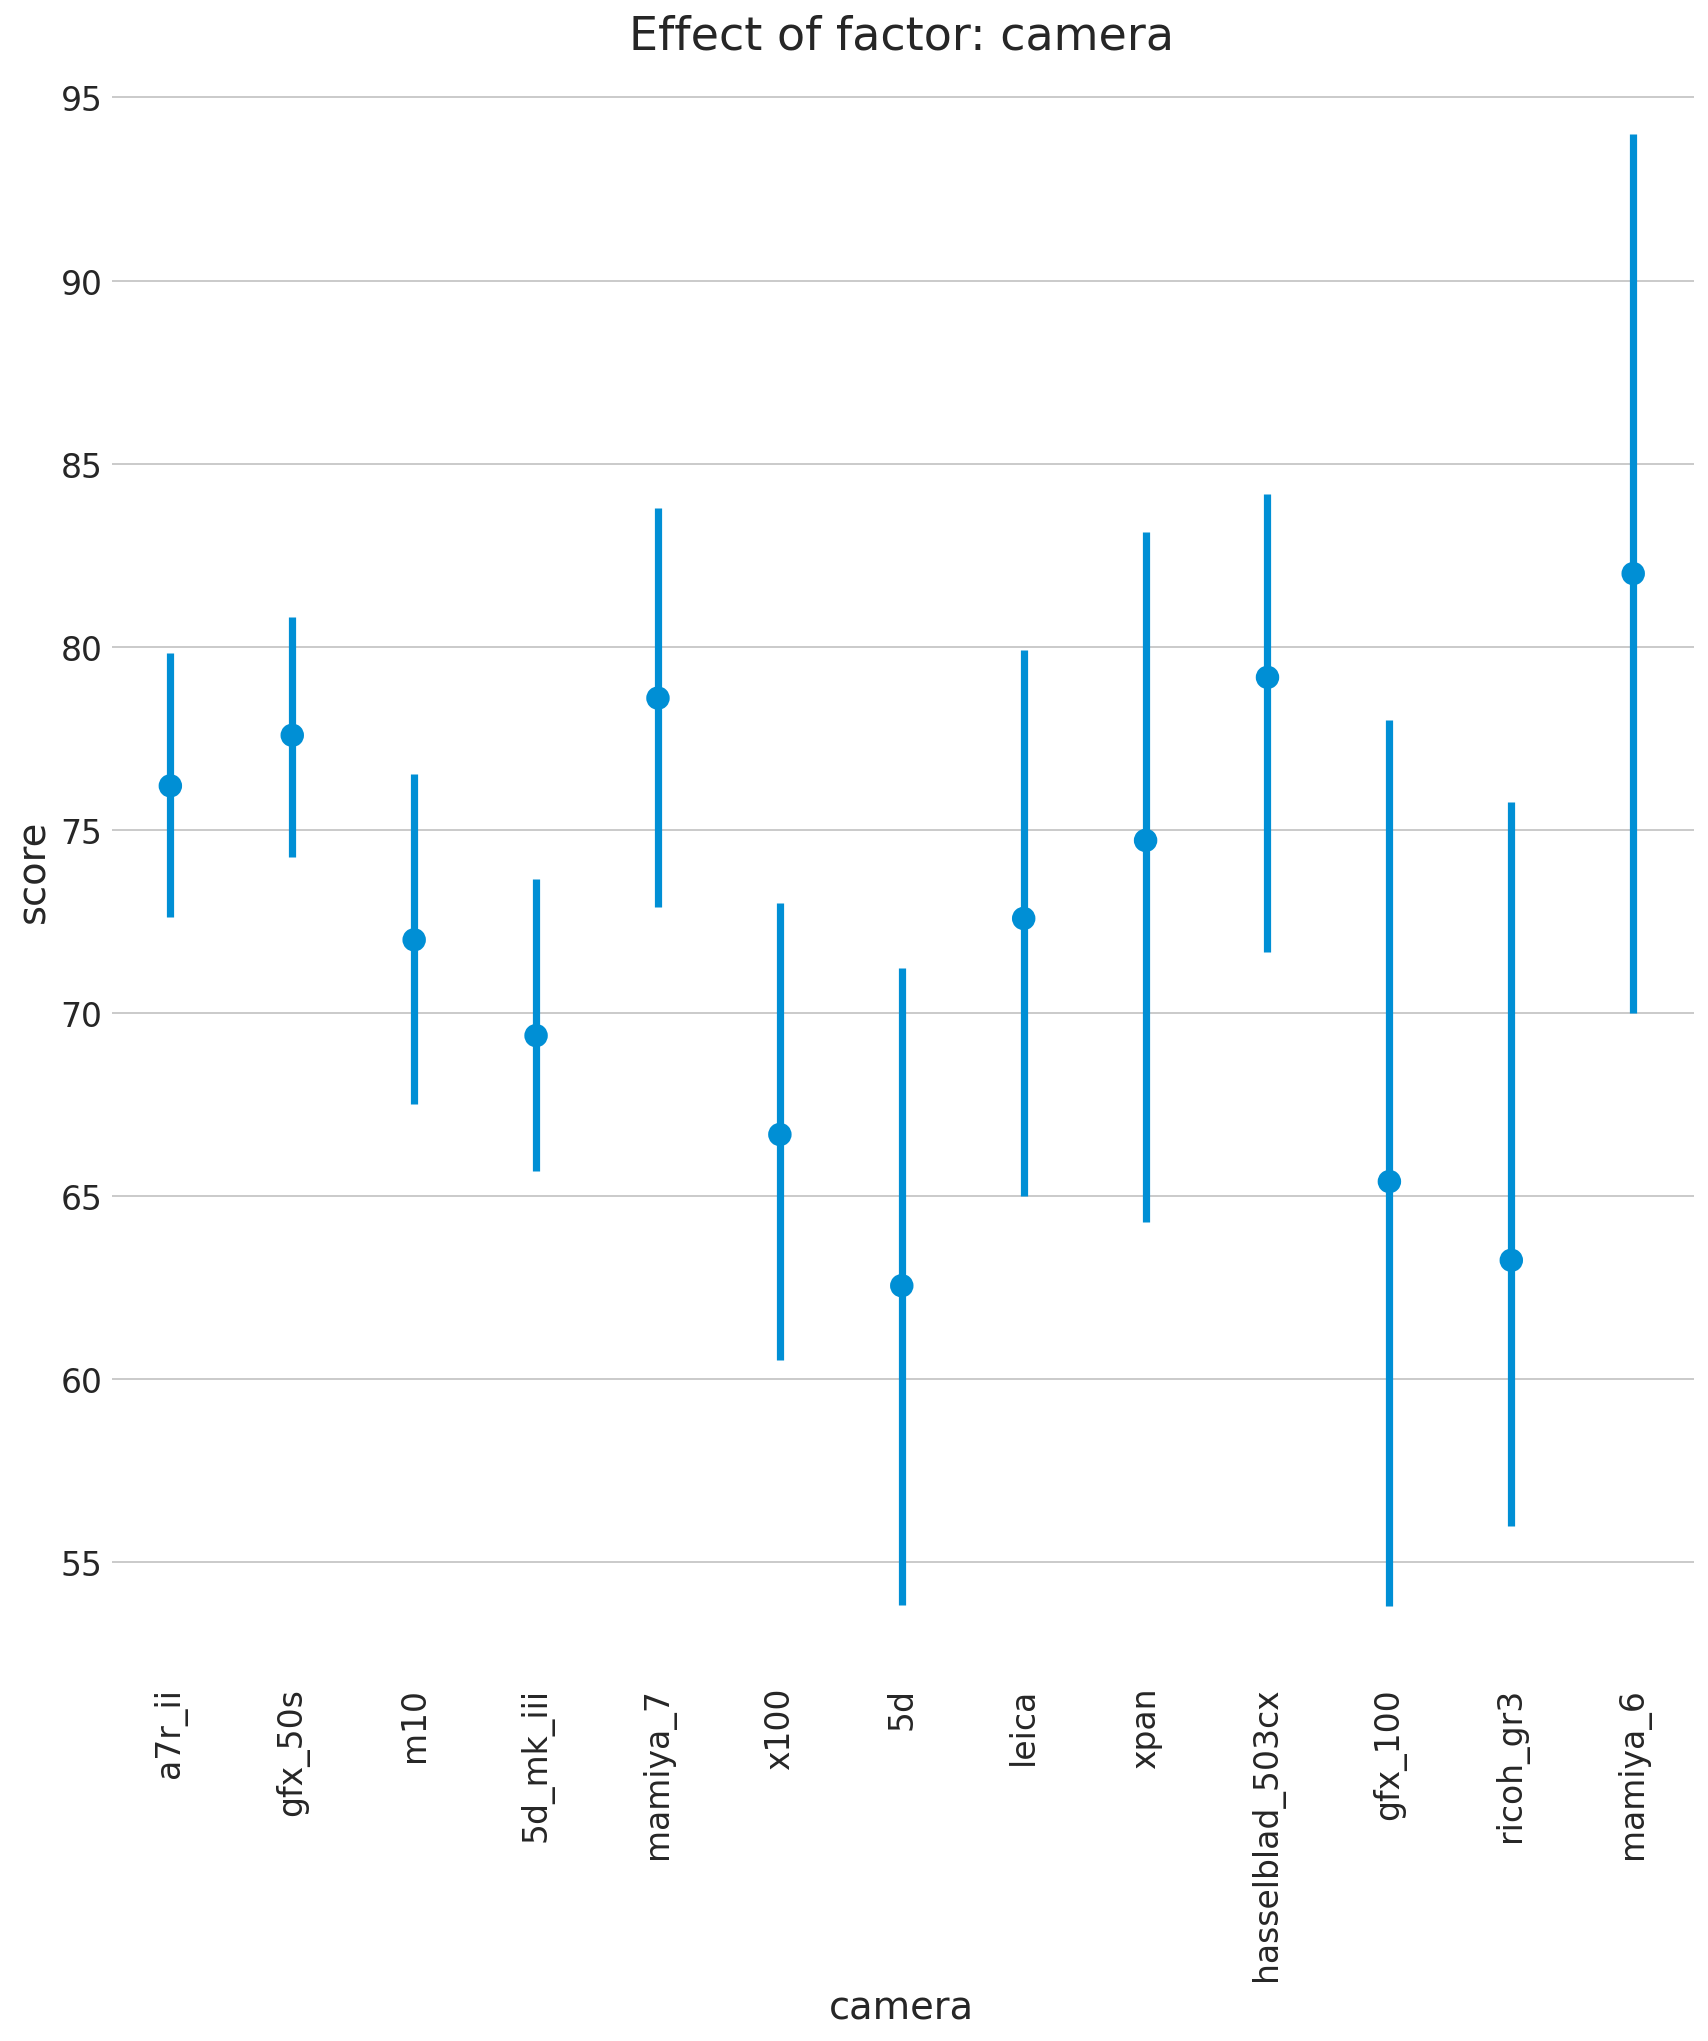

/home/jan/miniconda3/envs/jan/lib/python3.6/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5, 1.0, 'Effect of factor: camera_p_n_s')

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

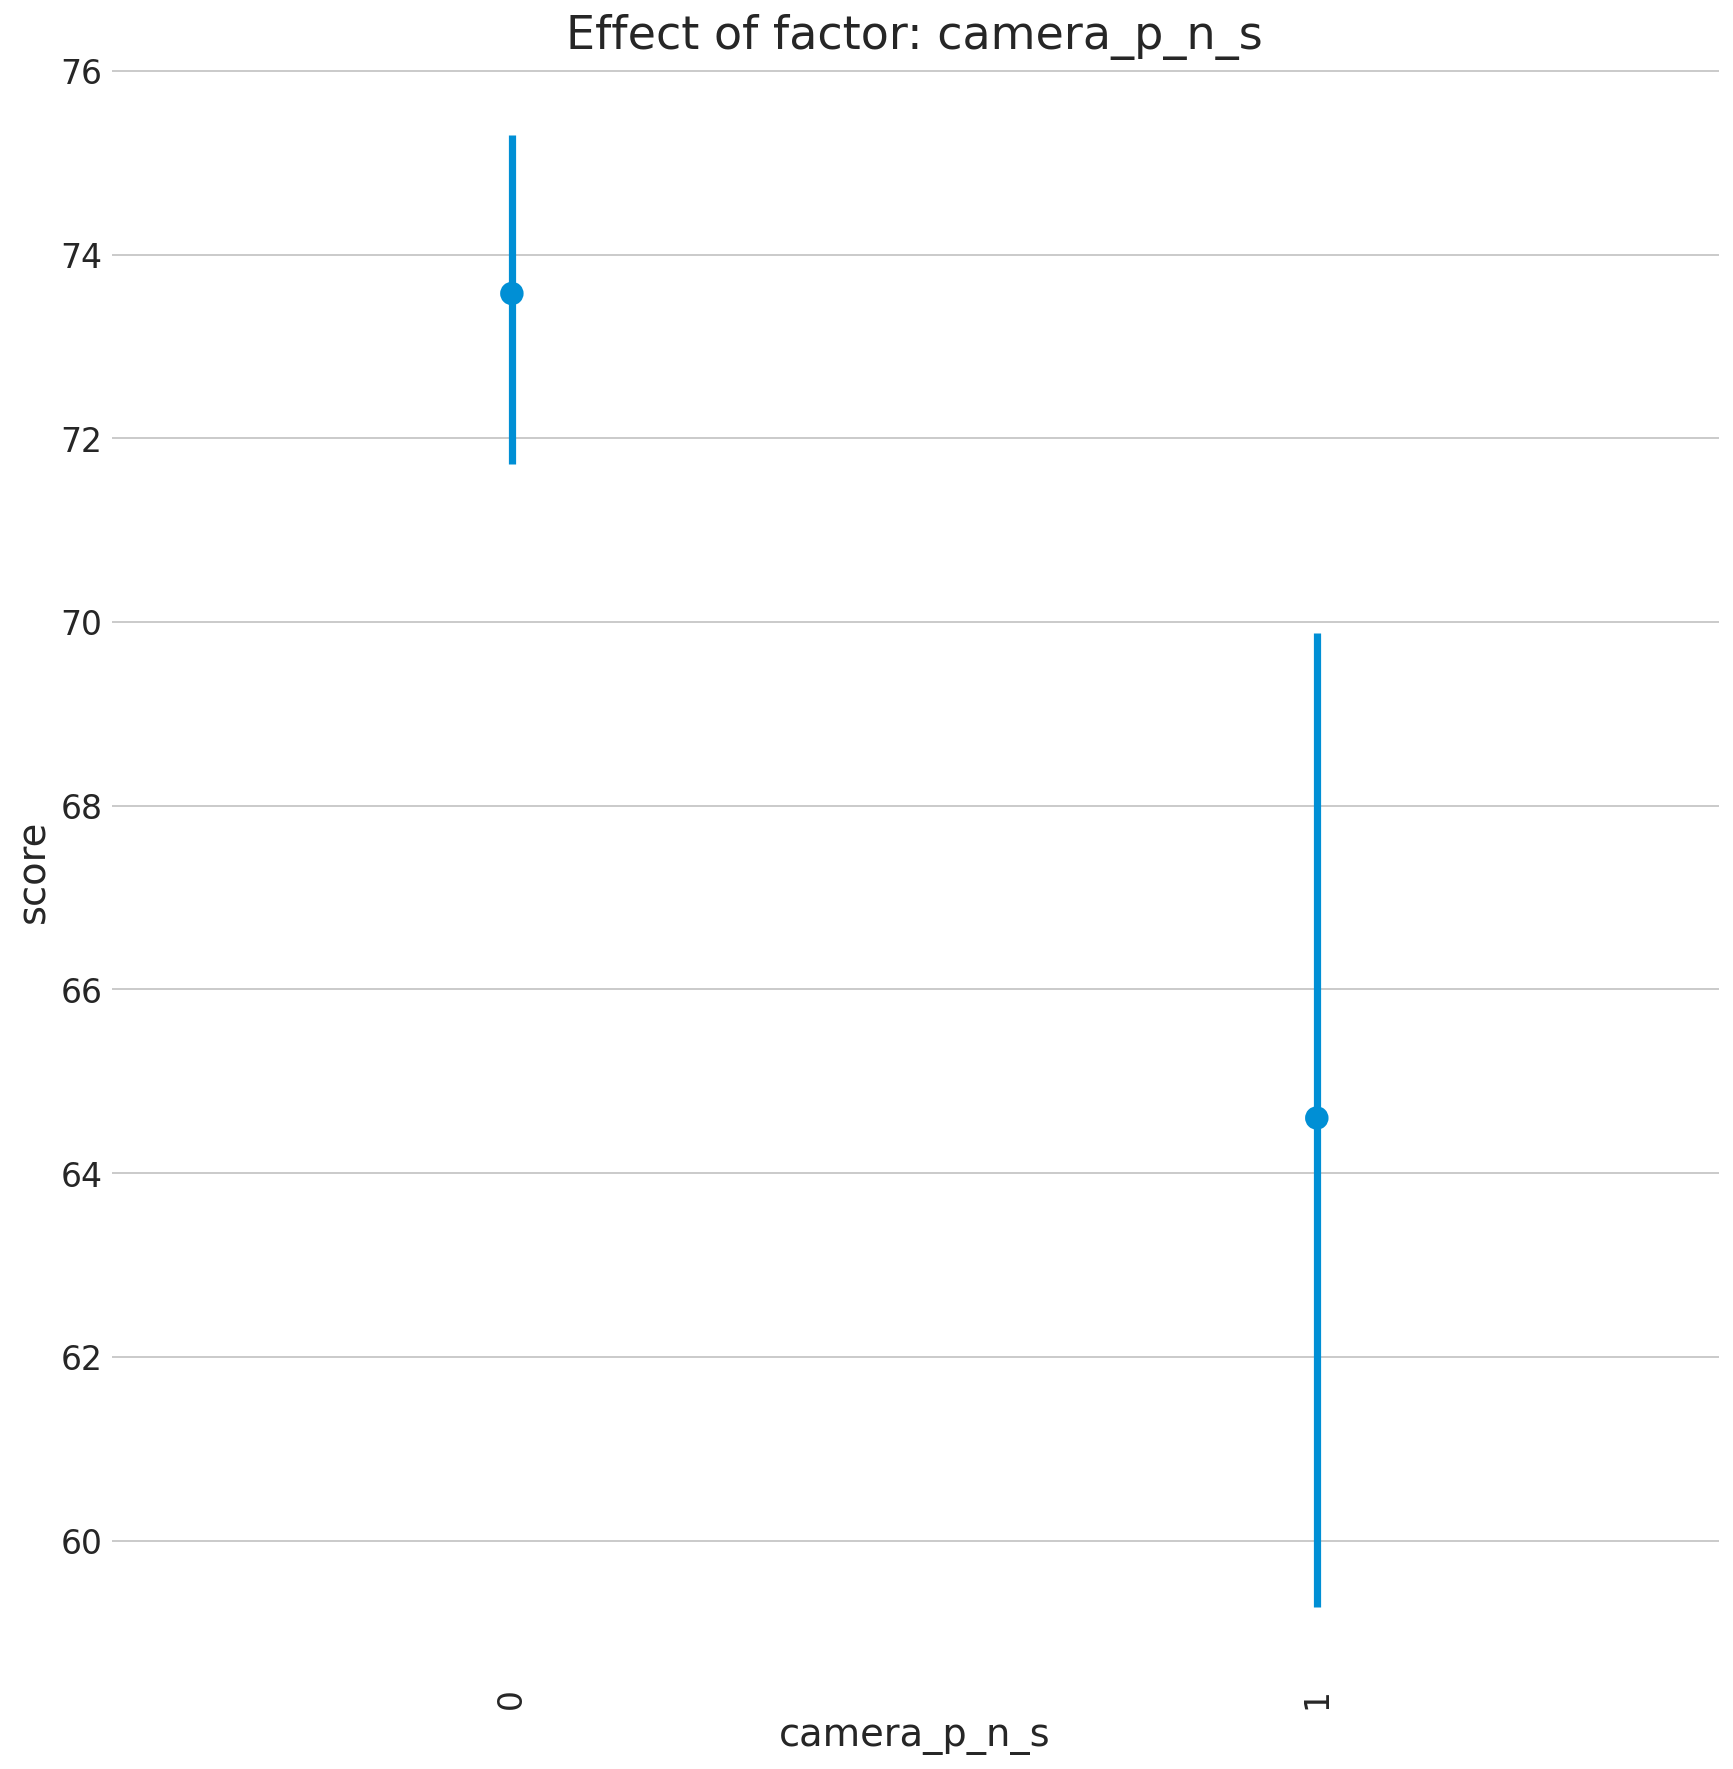

/home/jan/miniconda3/envs/jan/lib/python3.6/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5, 1.0, 'Effect of factor: 35equiv_focal')

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, '50'),
  Text(1, 0, '35'),
  Text(2, 0, '85'),
  Text(3, 0, '28'),
  Text(4, 0, '40'),
  Text(5, 0, '32'),
  Text(6, 0, '26'),
  Text(7, 0, '30')])

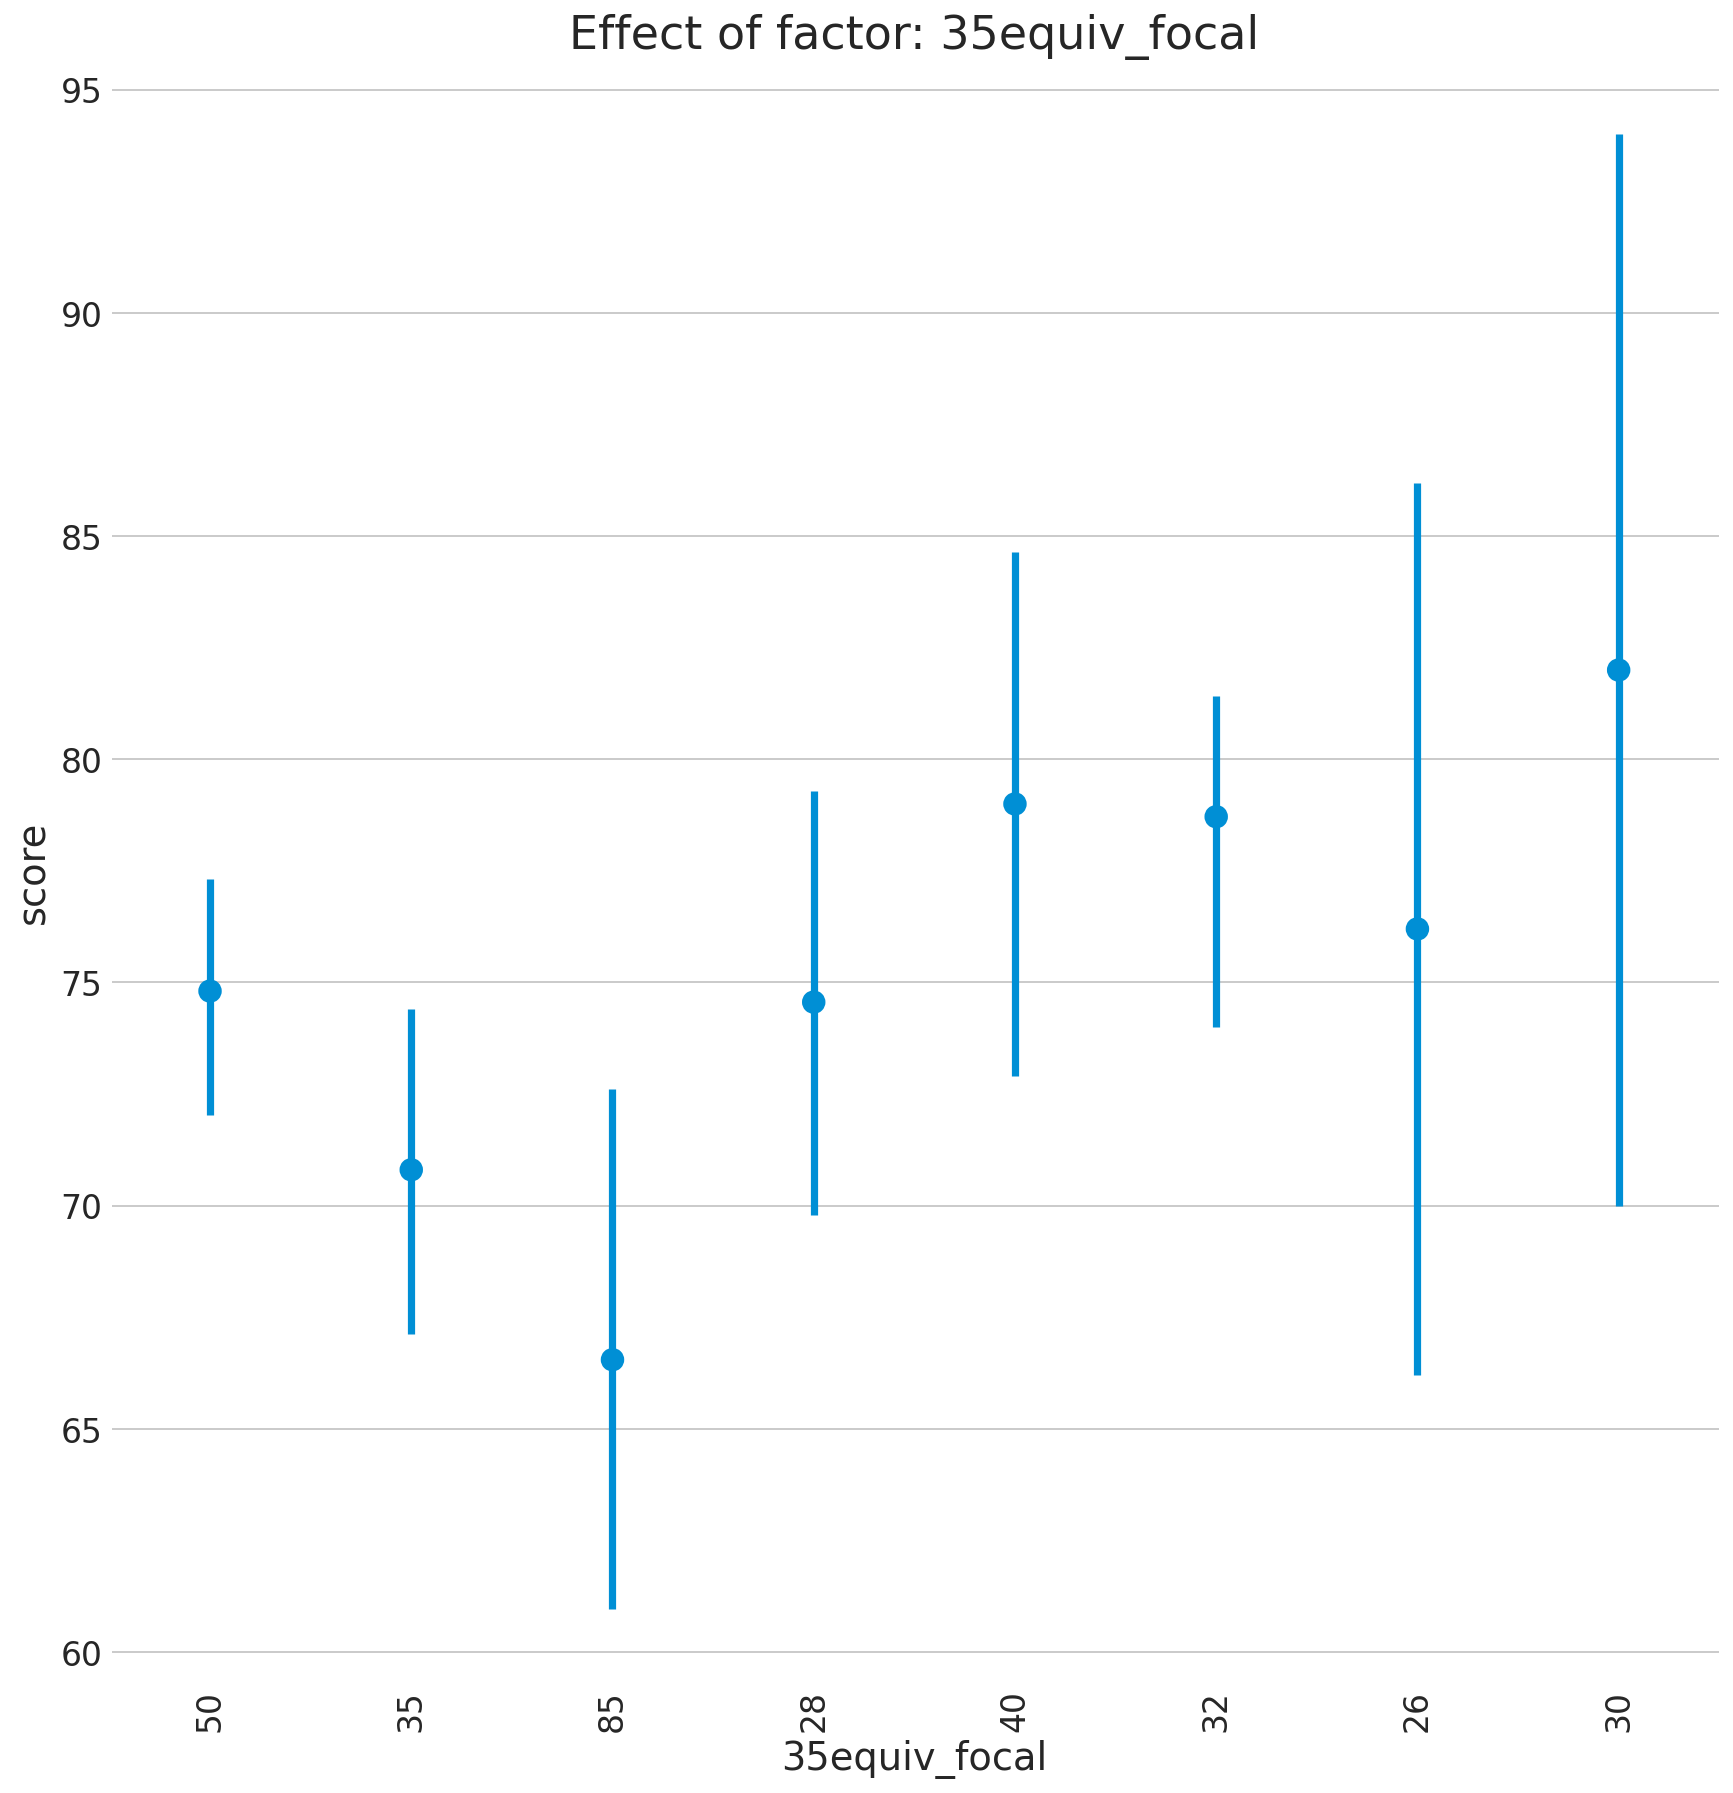

/home/jan/miniconda3/envs/jan/lib/python3.6/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5, 1.0, 'Effect of factor: film_digital')

(array([0, 1, 2]),
 [Text(0, 0, 'digital'), Text(1, 0, 'bw_film'), Text(2, 0, 'c41_film')])

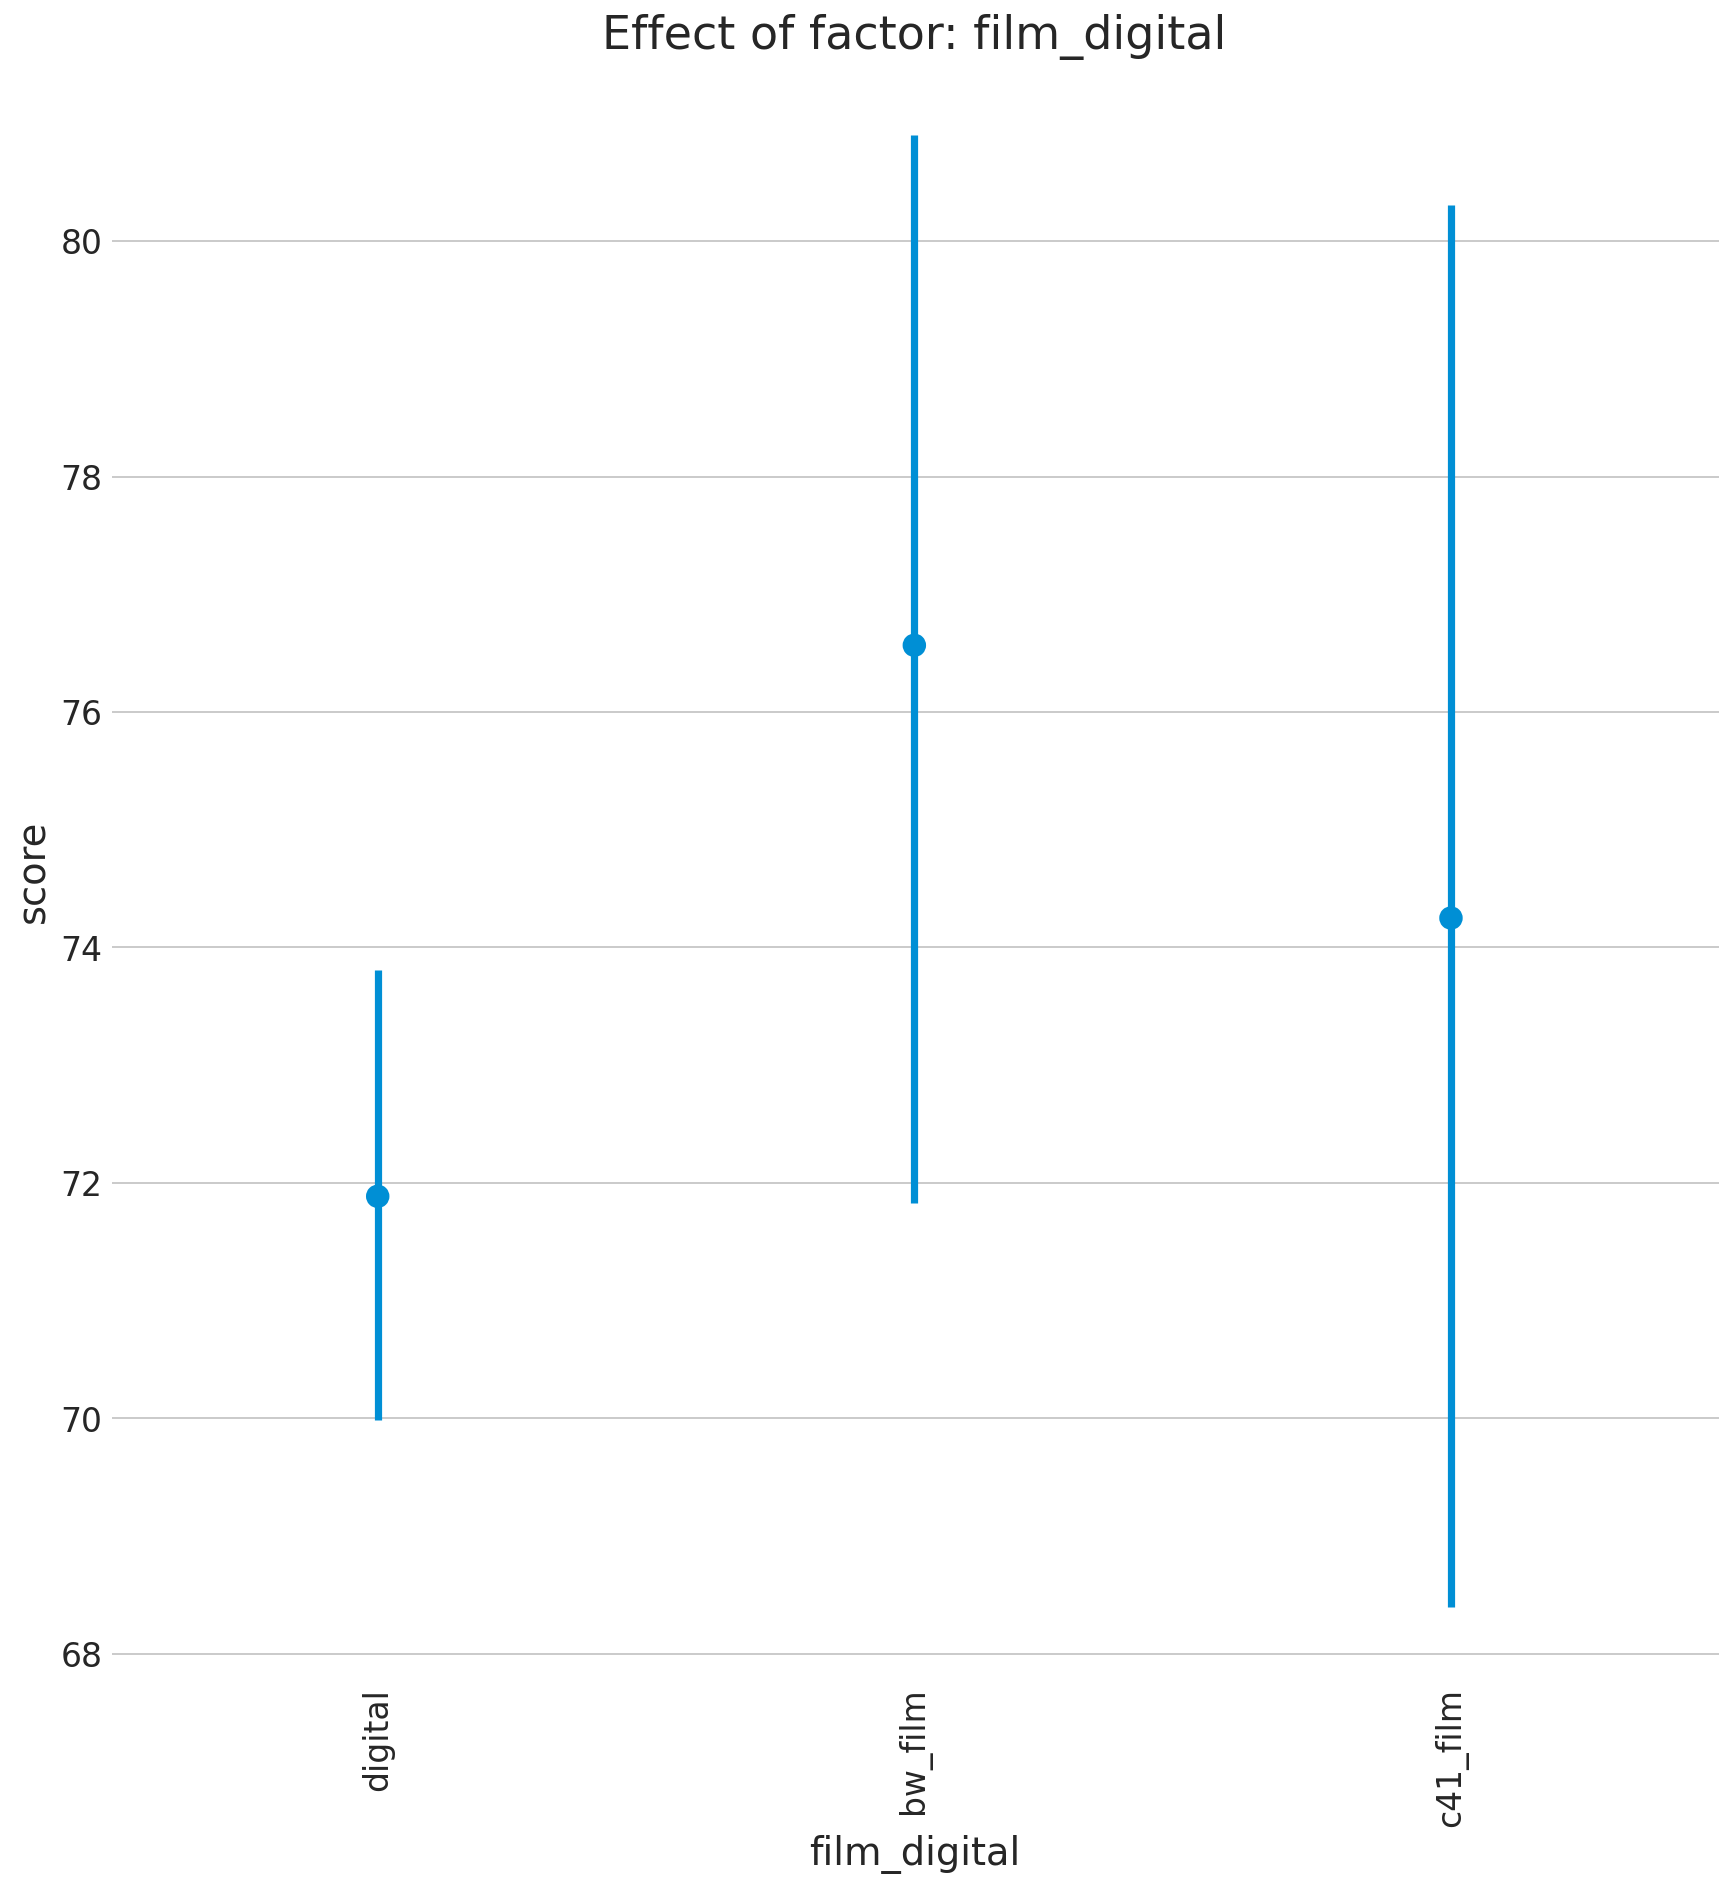

/home/jan/miniconda3/envs/jan/lib/python3.6/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5, 1.0, 'Effect of factor: format')

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'ff_digital'),
  Text(1, 0, 'mf_digital'),
  Text(2, 0, 'mf_film'),
  Text(3, 0, 'crop_digital'),
  Text(4, 0, '35mm_film'),
  Text(5, 0, 'pano_film')])

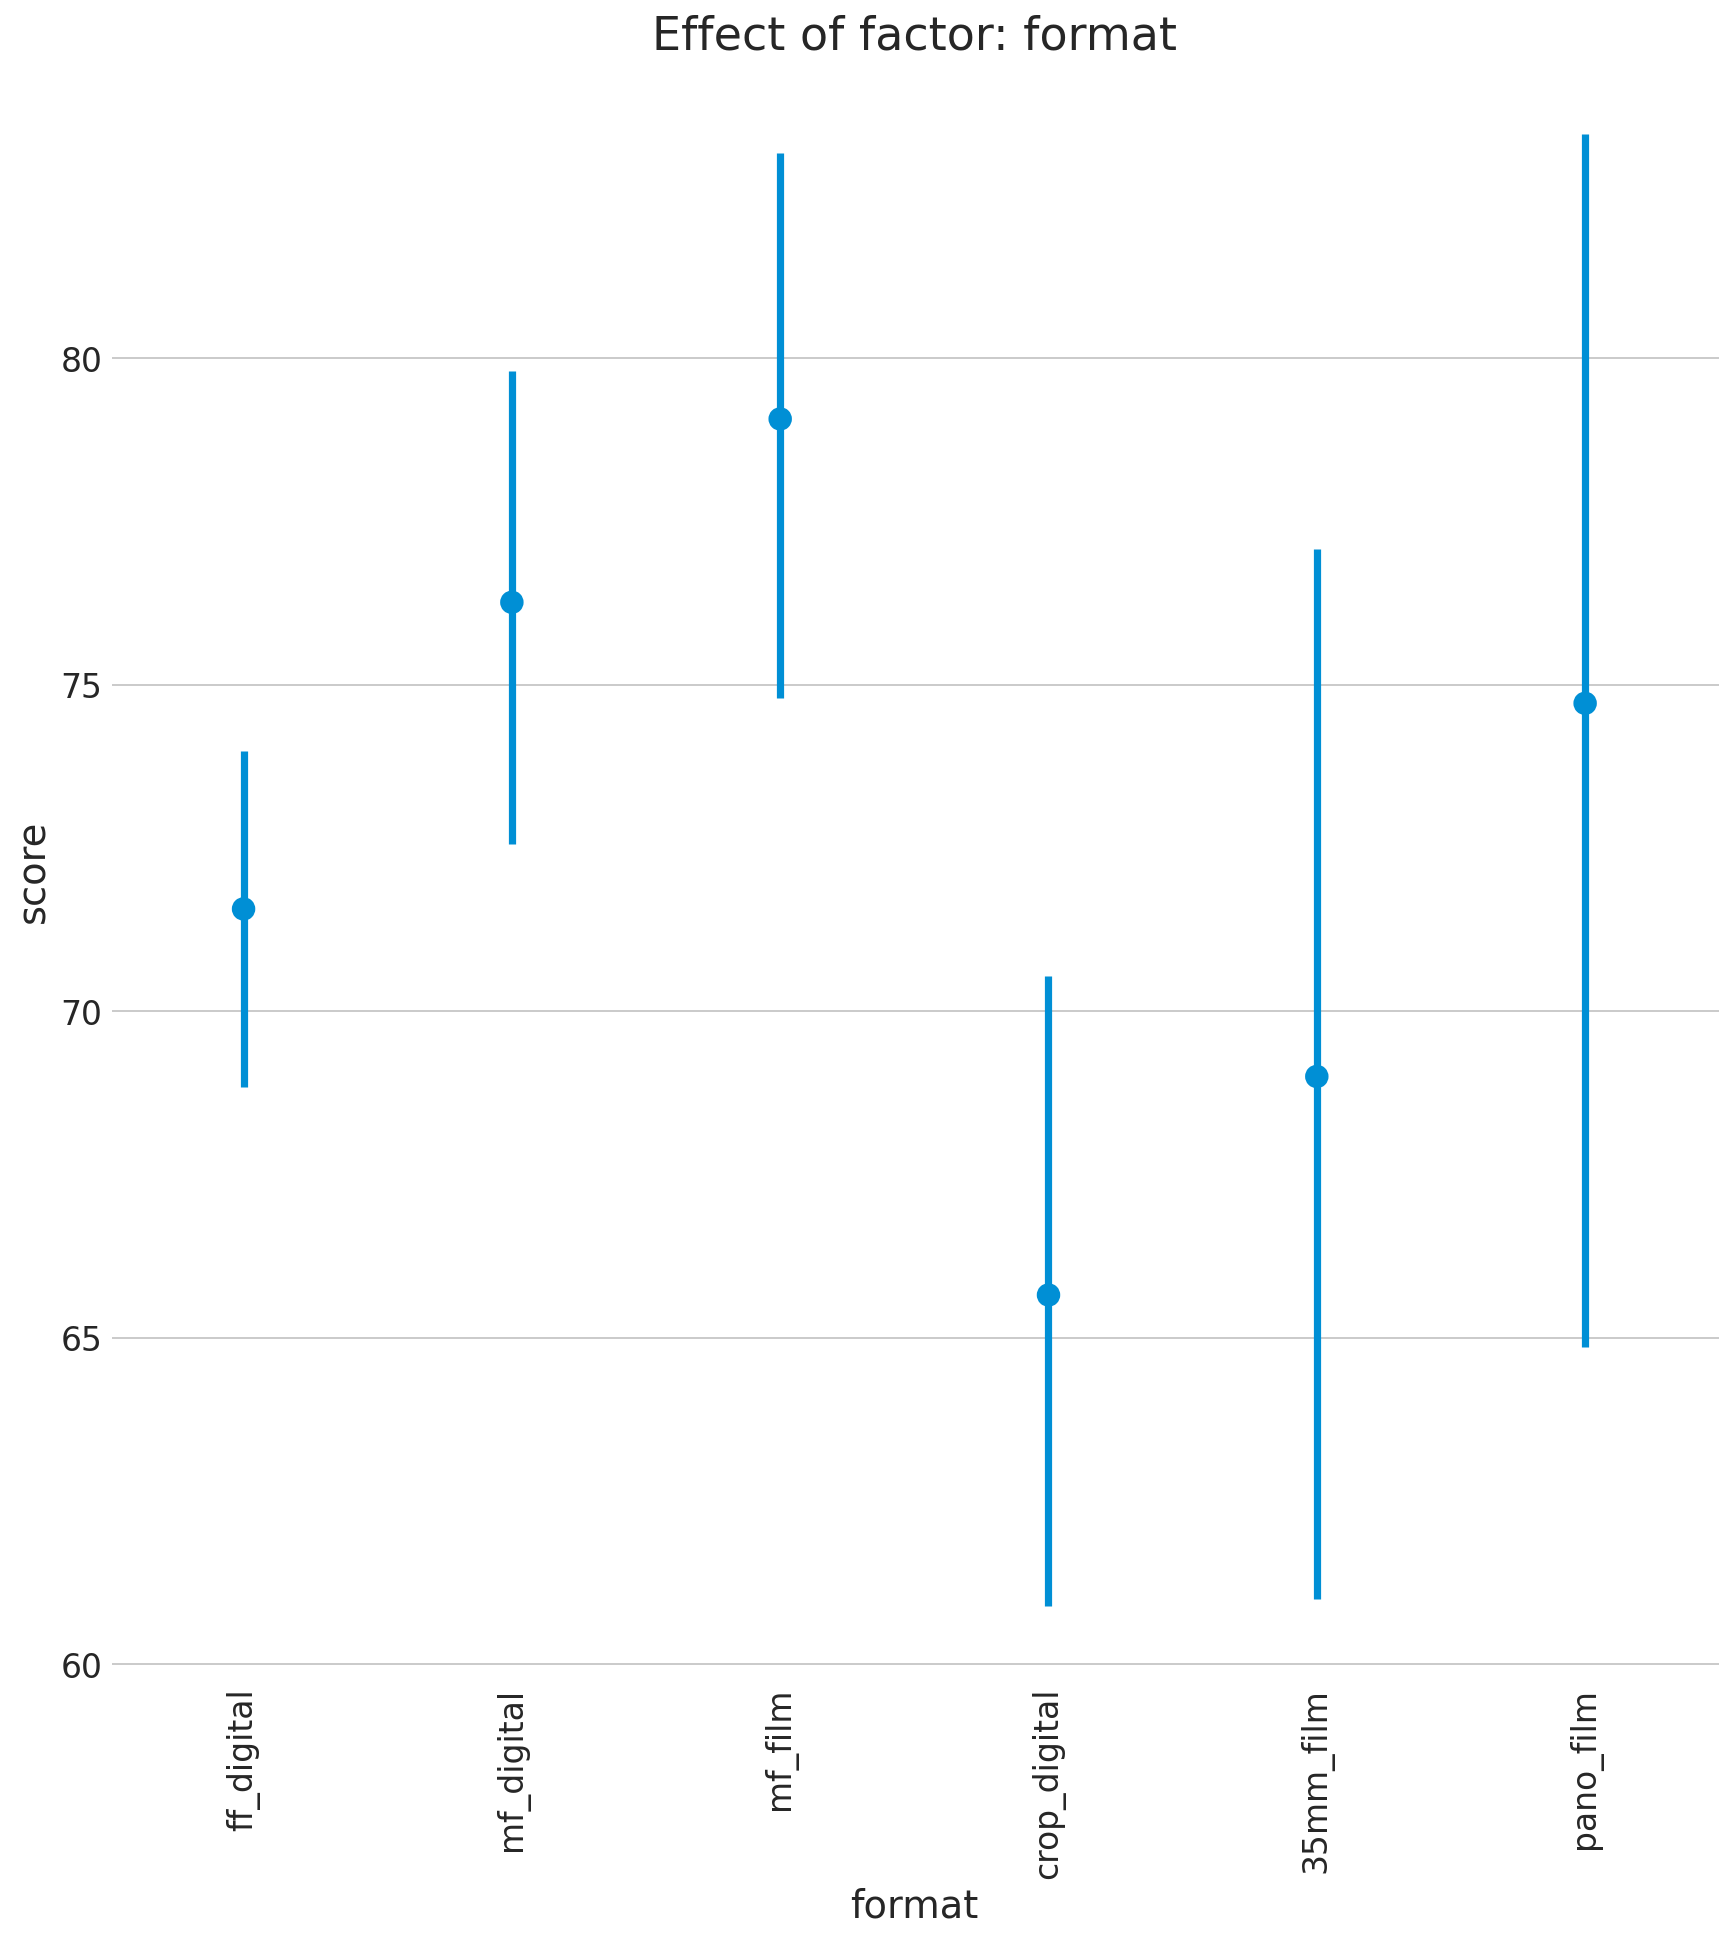

/home/jan/miniconda3/envs/jan/lib/python3.6/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5, 1.0, 'Effect of factor: shooting_circumstance')

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'vacation'),
  Text(1, 0, 'intentional'),
  Text(2, 0, 'incidental'),
  Text(3, 0, 'after_work'),
  Text(4, 0, 'newspaper')])

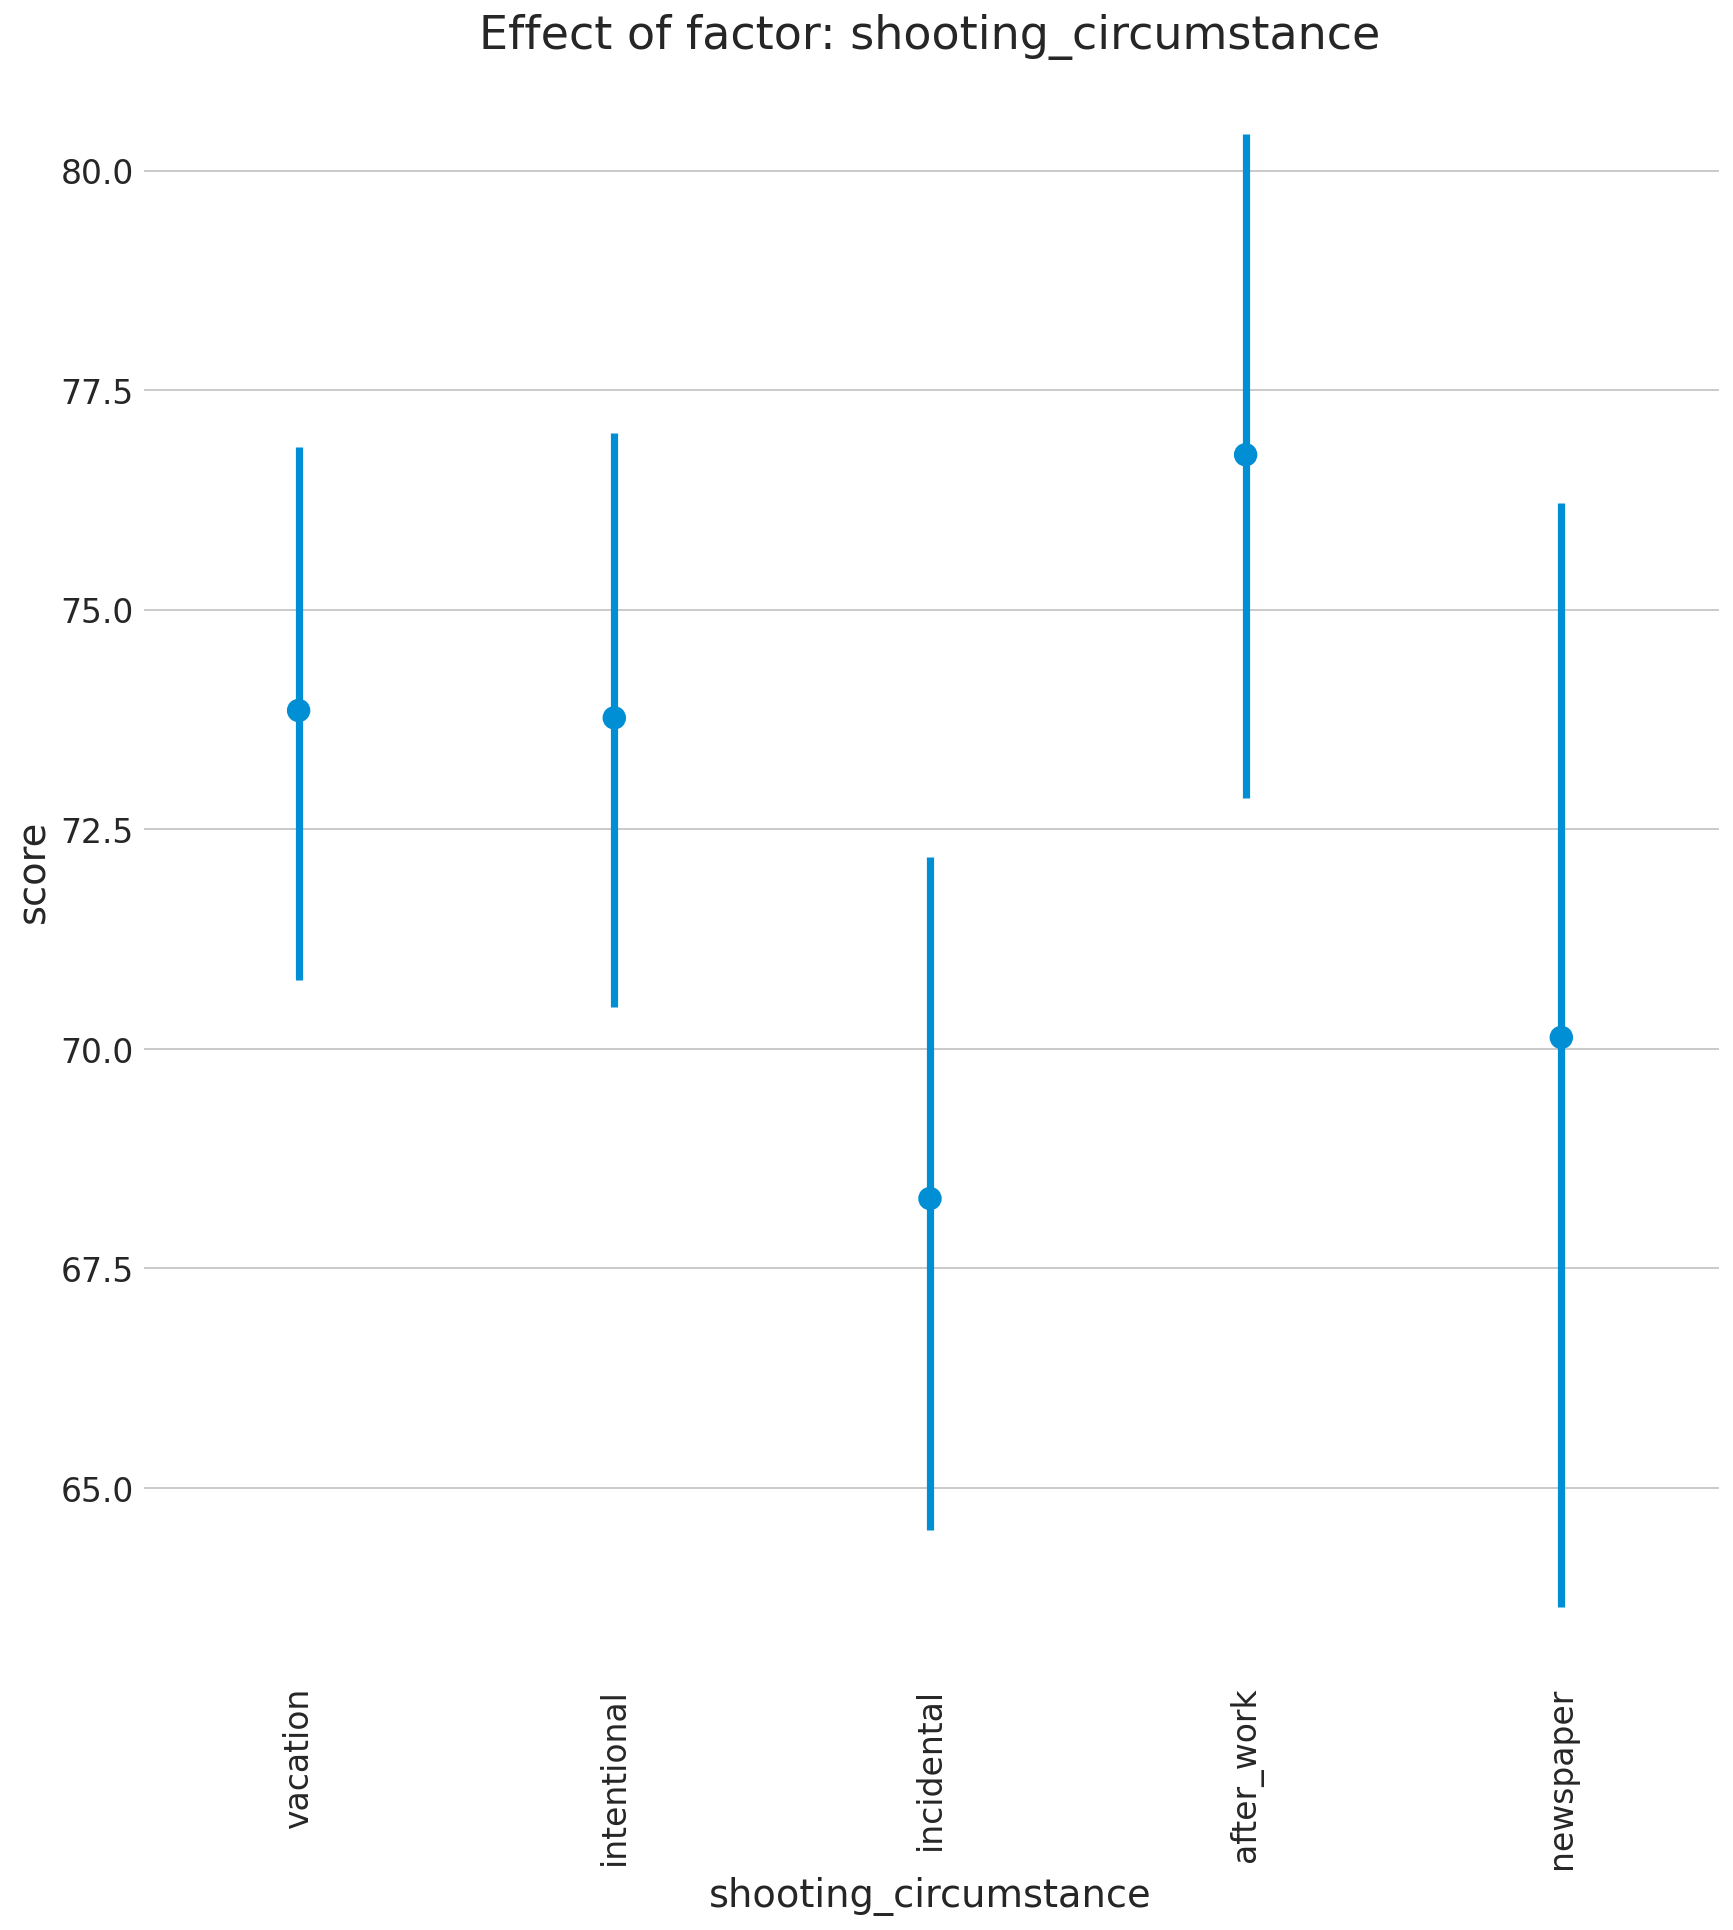

/home/jan/miniconda3/envs/jan/lib/python3.6/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5, 1.0, 'Effect of factor: filmstock')

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 't-max 400'),
  Text(1, 0, 'ektar'),
  Text(2, 0, 'portra 400'),
  Text(3, 0, 't-max 100'),
  Text(4, 0, 'hp5'),
  Text(5, 0, 'portra 160'),
  Text(6, 0, 'agfa vista'),
  Text(7, 0, 'tri-x')])

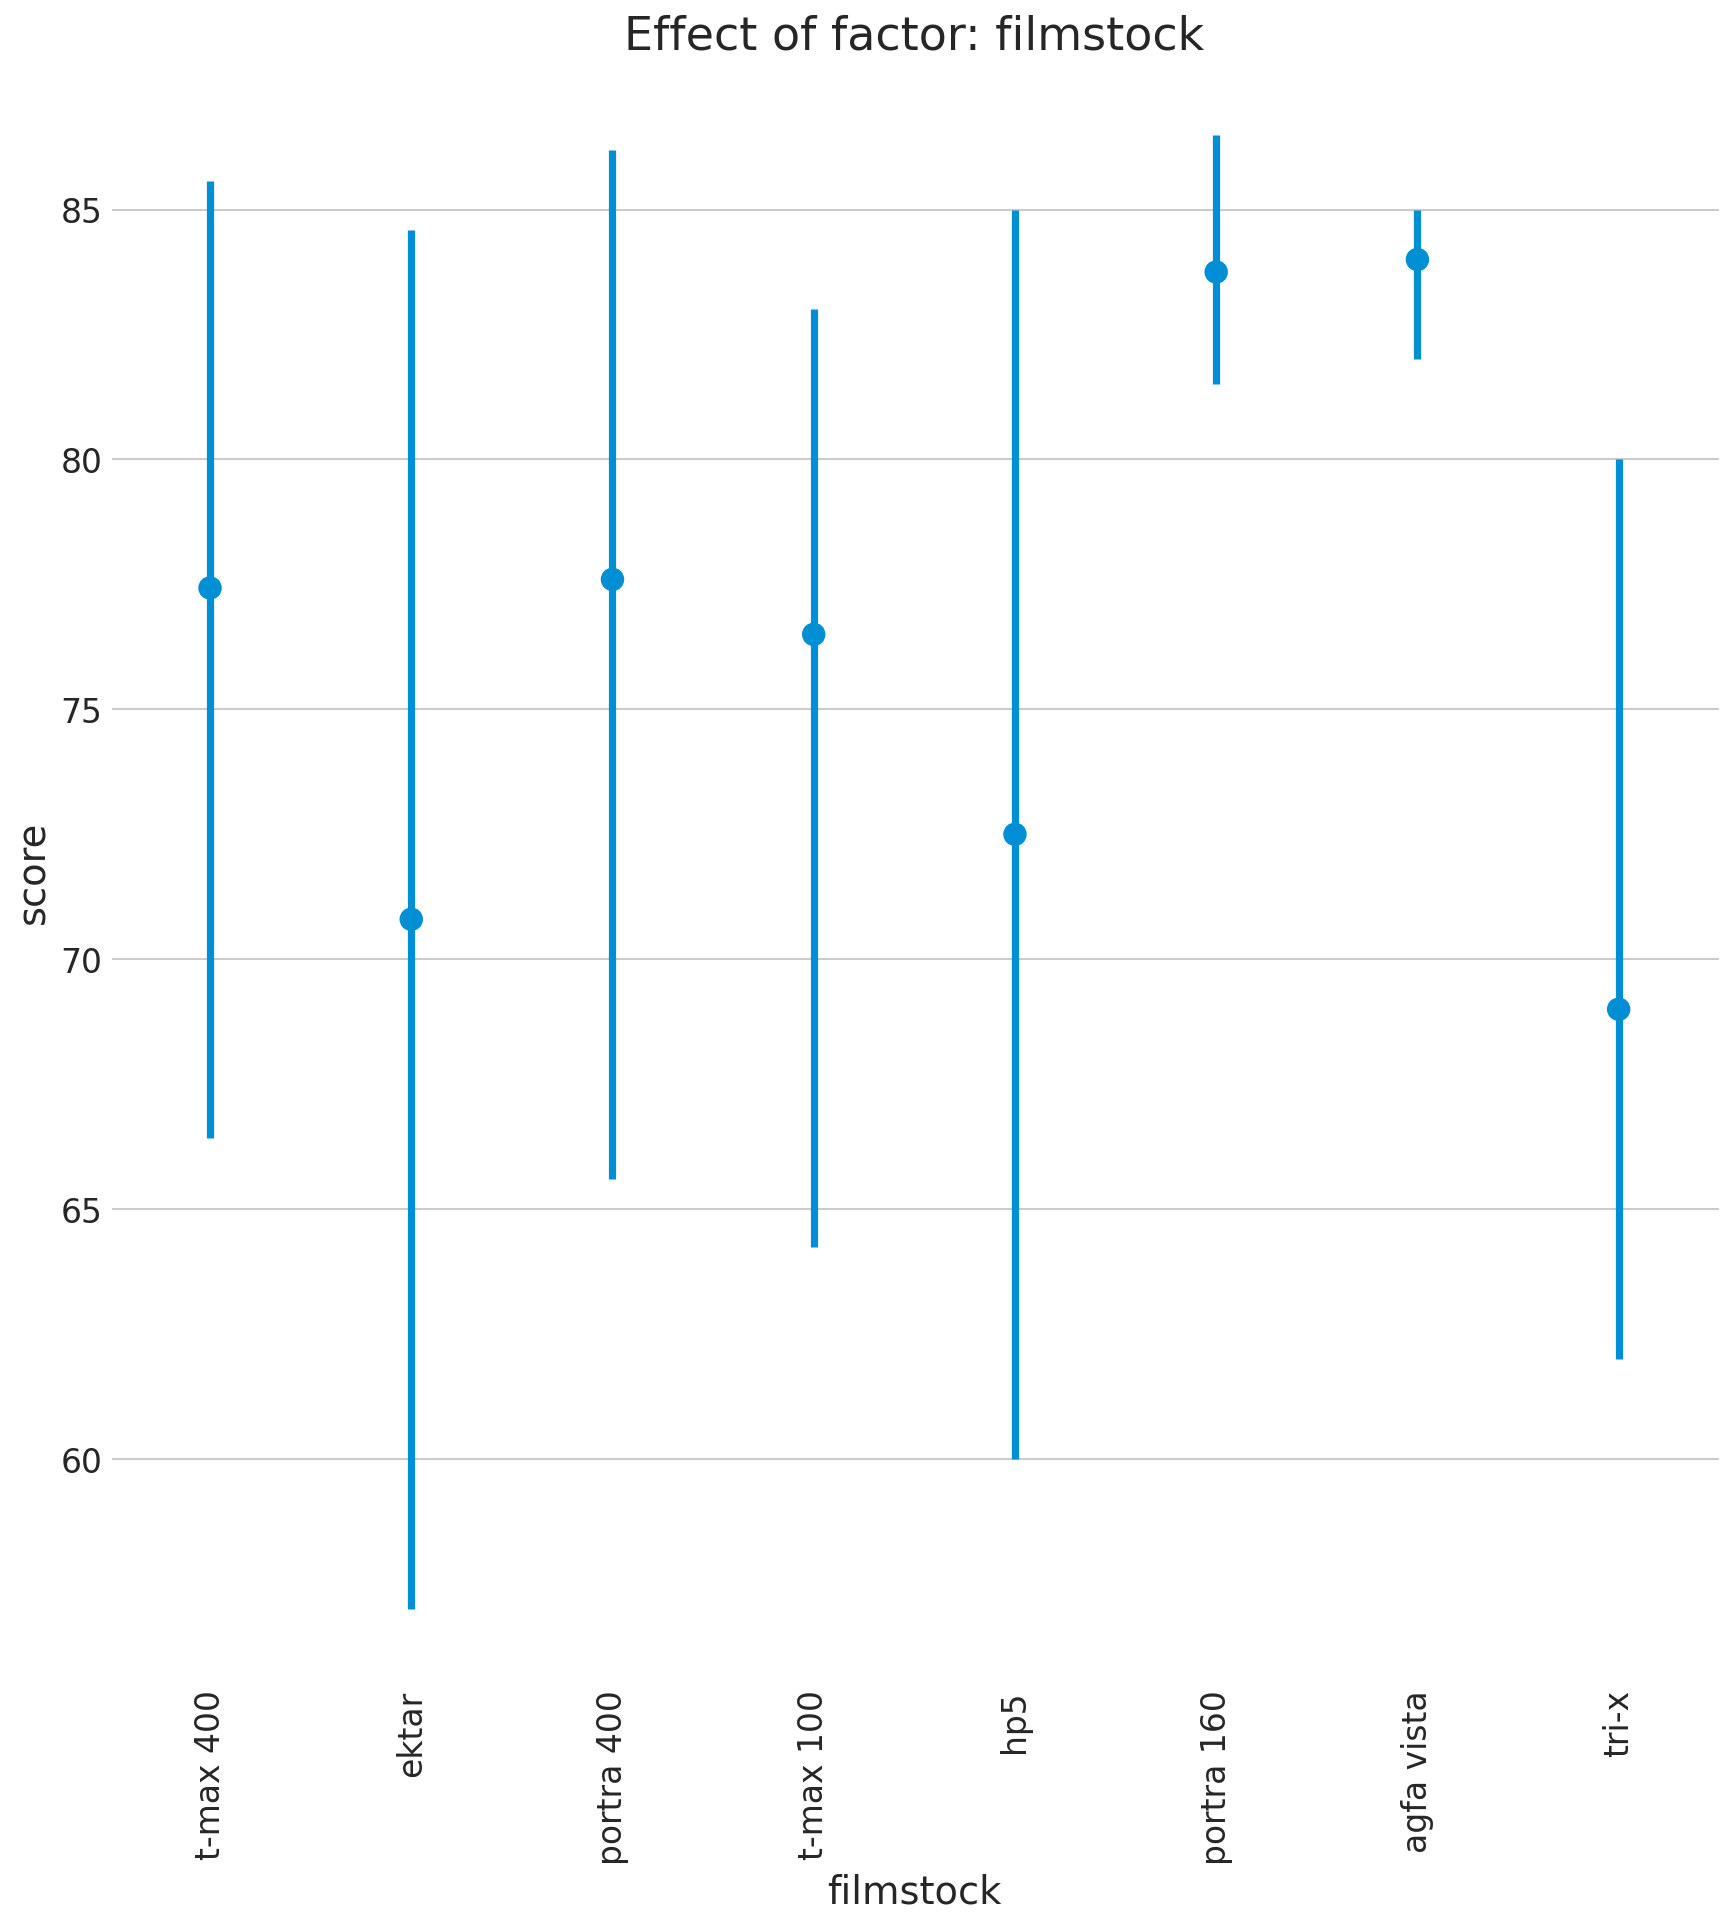

/home/jan/miniconda3/envs/jan/lib/python3.6/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5, 1.0, 'Effect of factor: lighting')

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'non-soft'),
  Text(1, 0, 'soft'),
  Text(2, 0, 'golden hour'),
  Text(3, 0, 'on-camera flash'),
  Text(4, 0, 'studio flash'),
  Text(5, 0, 'artificial')])

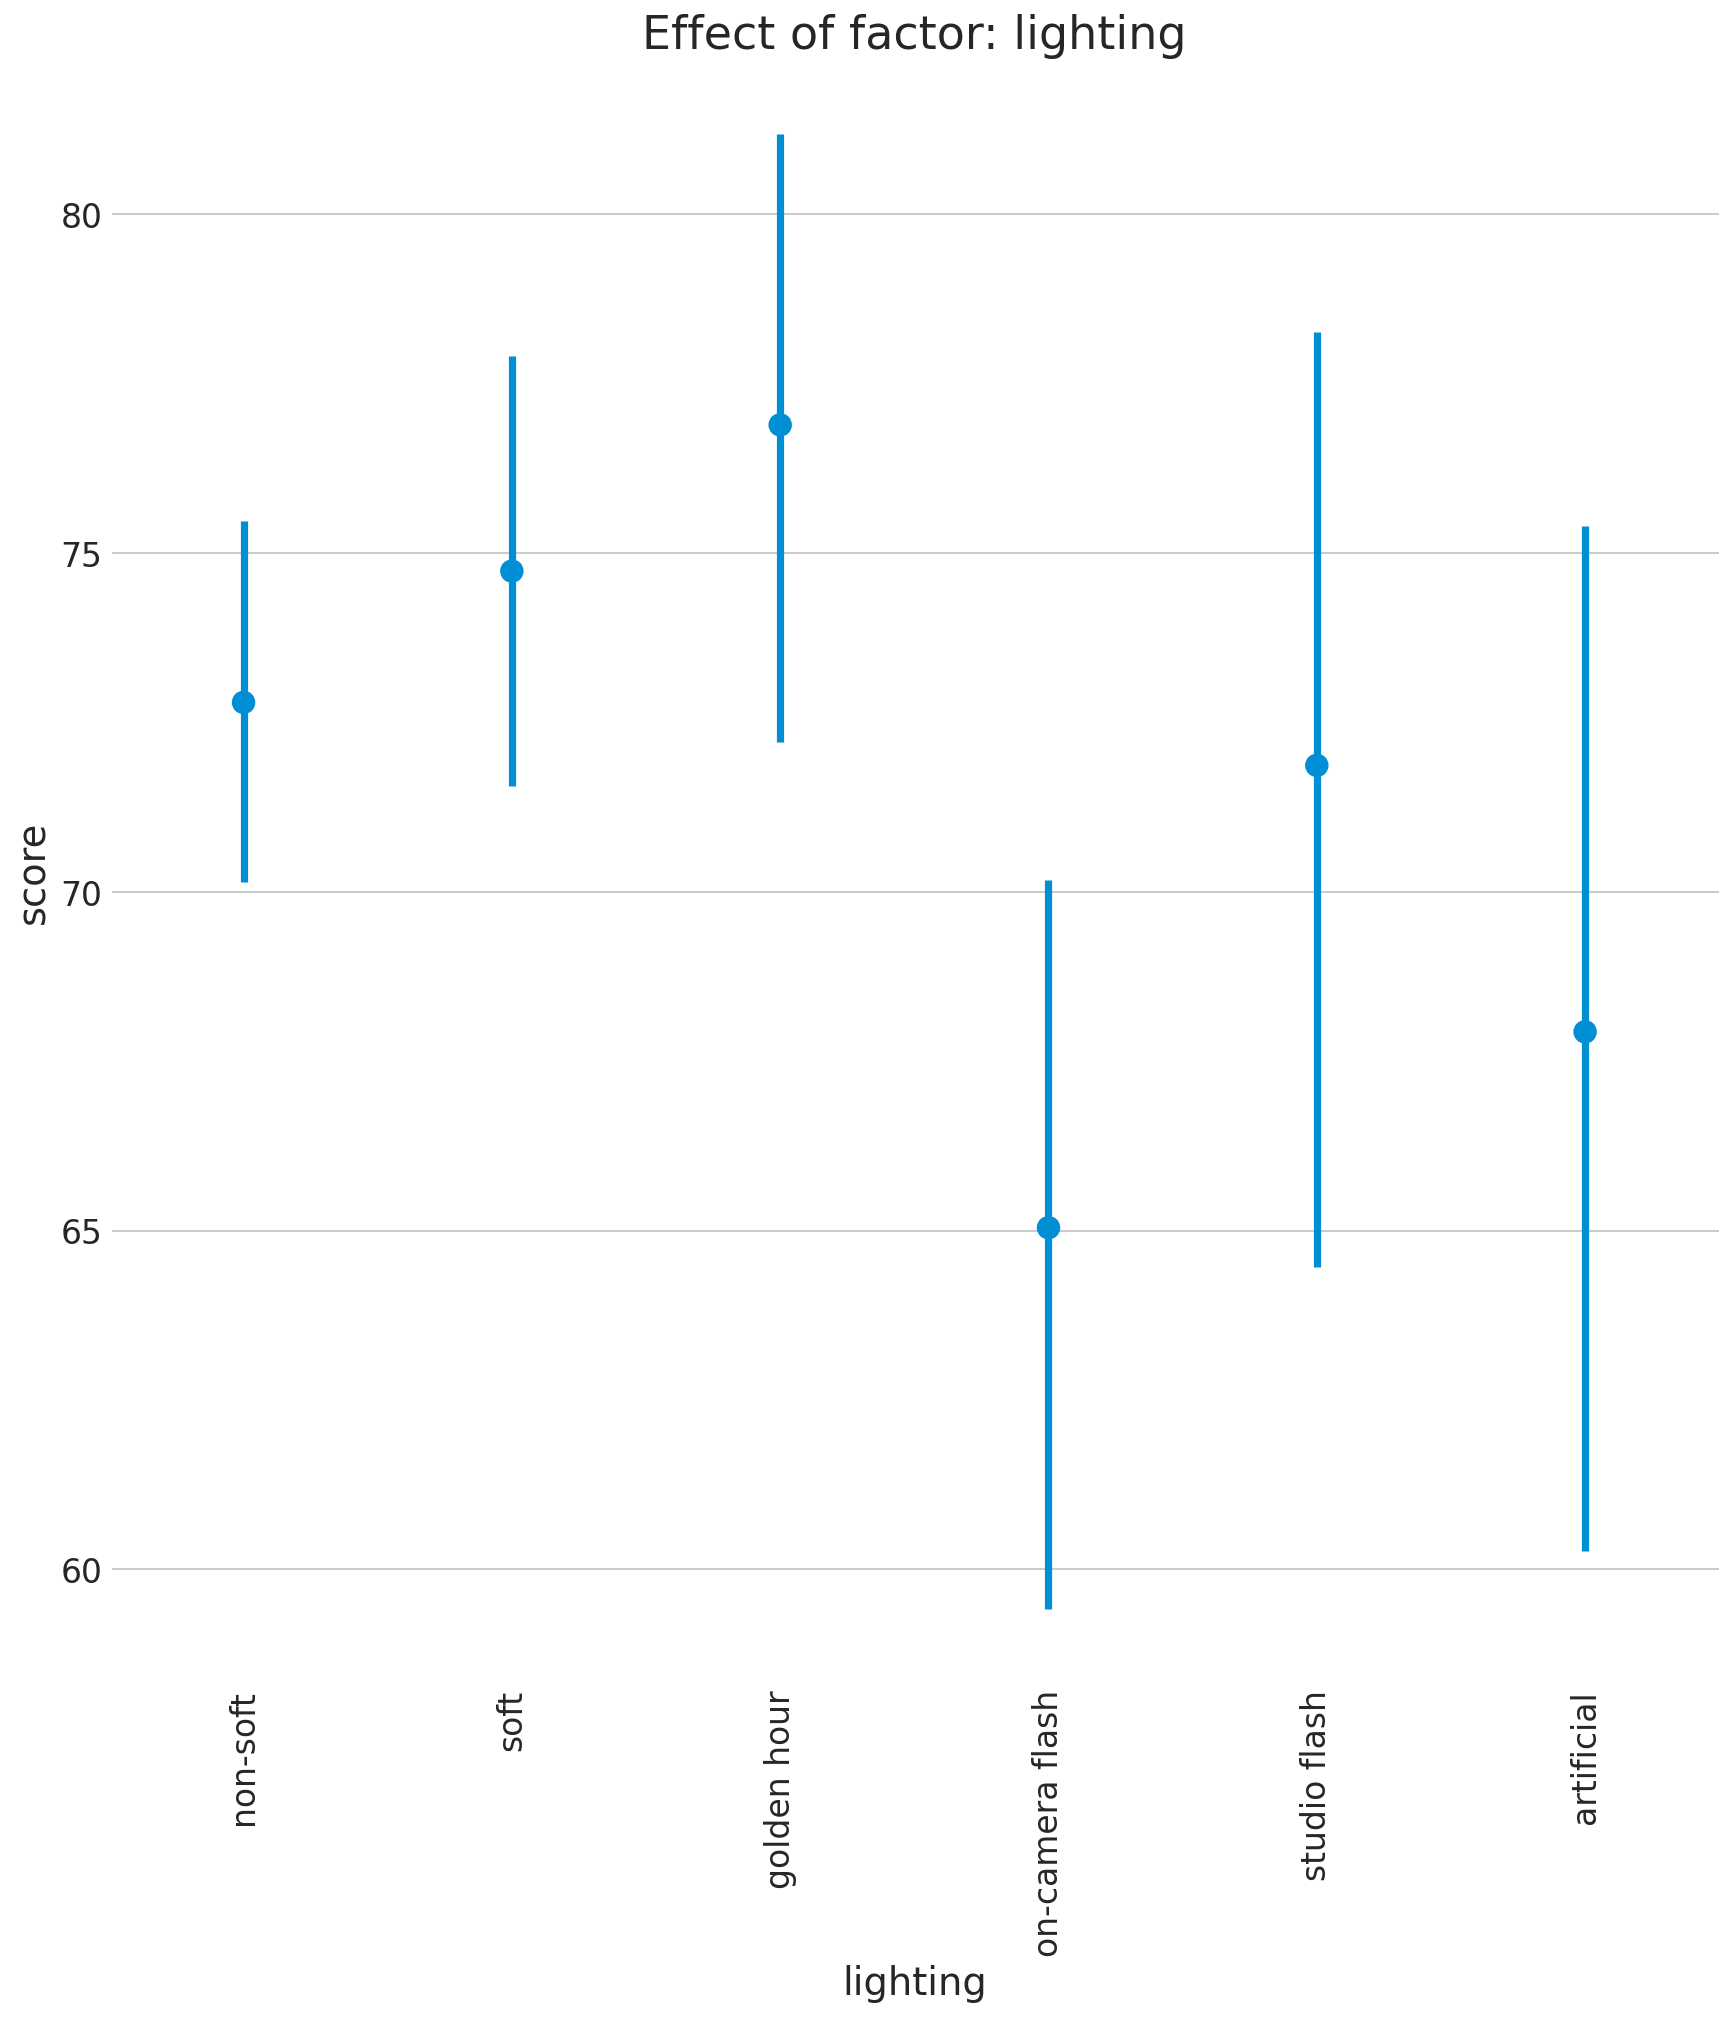

/home/jan/miniconda3/envs/jan/lib/python3.6/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5, 1.0, 'Effect of factor: photo_style')

(array([0, 1, 2, 3]),
 [Text(0, 0, 'landscape'),
  Text(1, 0, 'portrait'),
  Text(2, 0, 'event/party'),
  Text(3, 0, 'still life /  macro')])

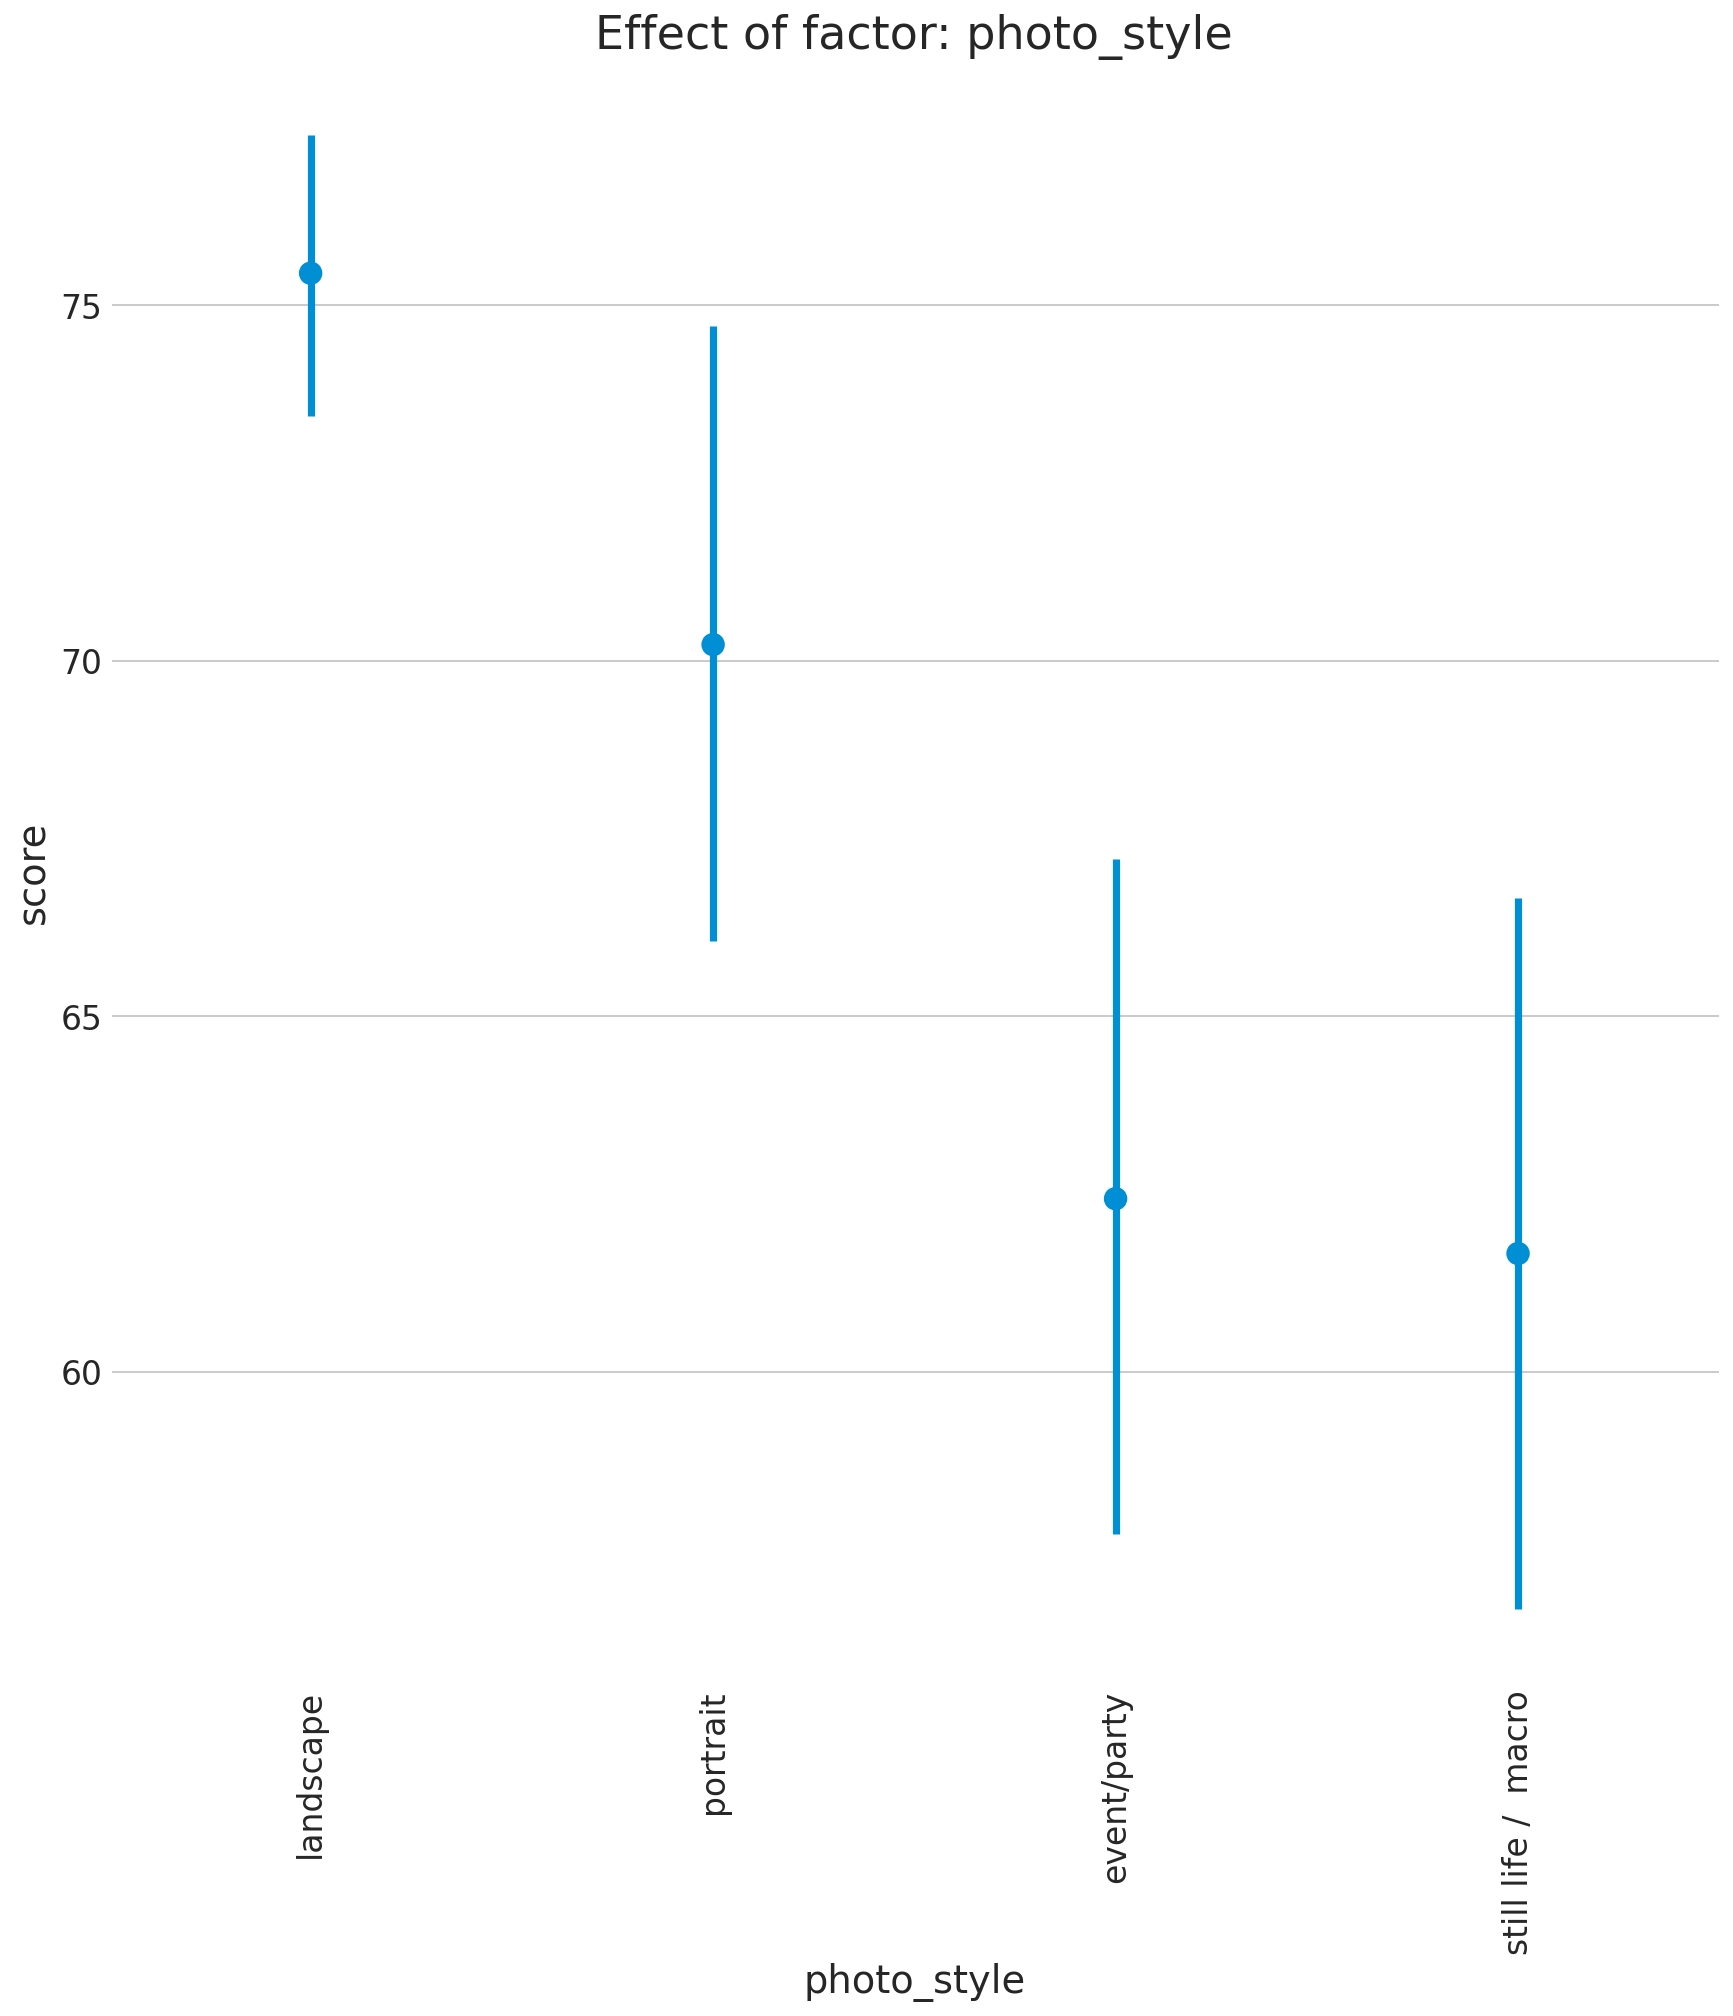

/home/jan/miniconda3/envs/jan/lib/python3.6/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5, 1.0, 'Effect of factor: month')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '3'),
  Text(1, 0, '11'),
  Text(2, 0, '8'),
  Text(3, 0, '9'),
  Text(4, 0, '2'),
  Text(5, 0, '5'),
  Text(6, 0, '4'),
  Text(7, 0, '7'),
  Text(8, 0, '10'),
  Text(9, 0, '6'),
  Text(10, 0, '12'),
  Text(11, 0, '1')])

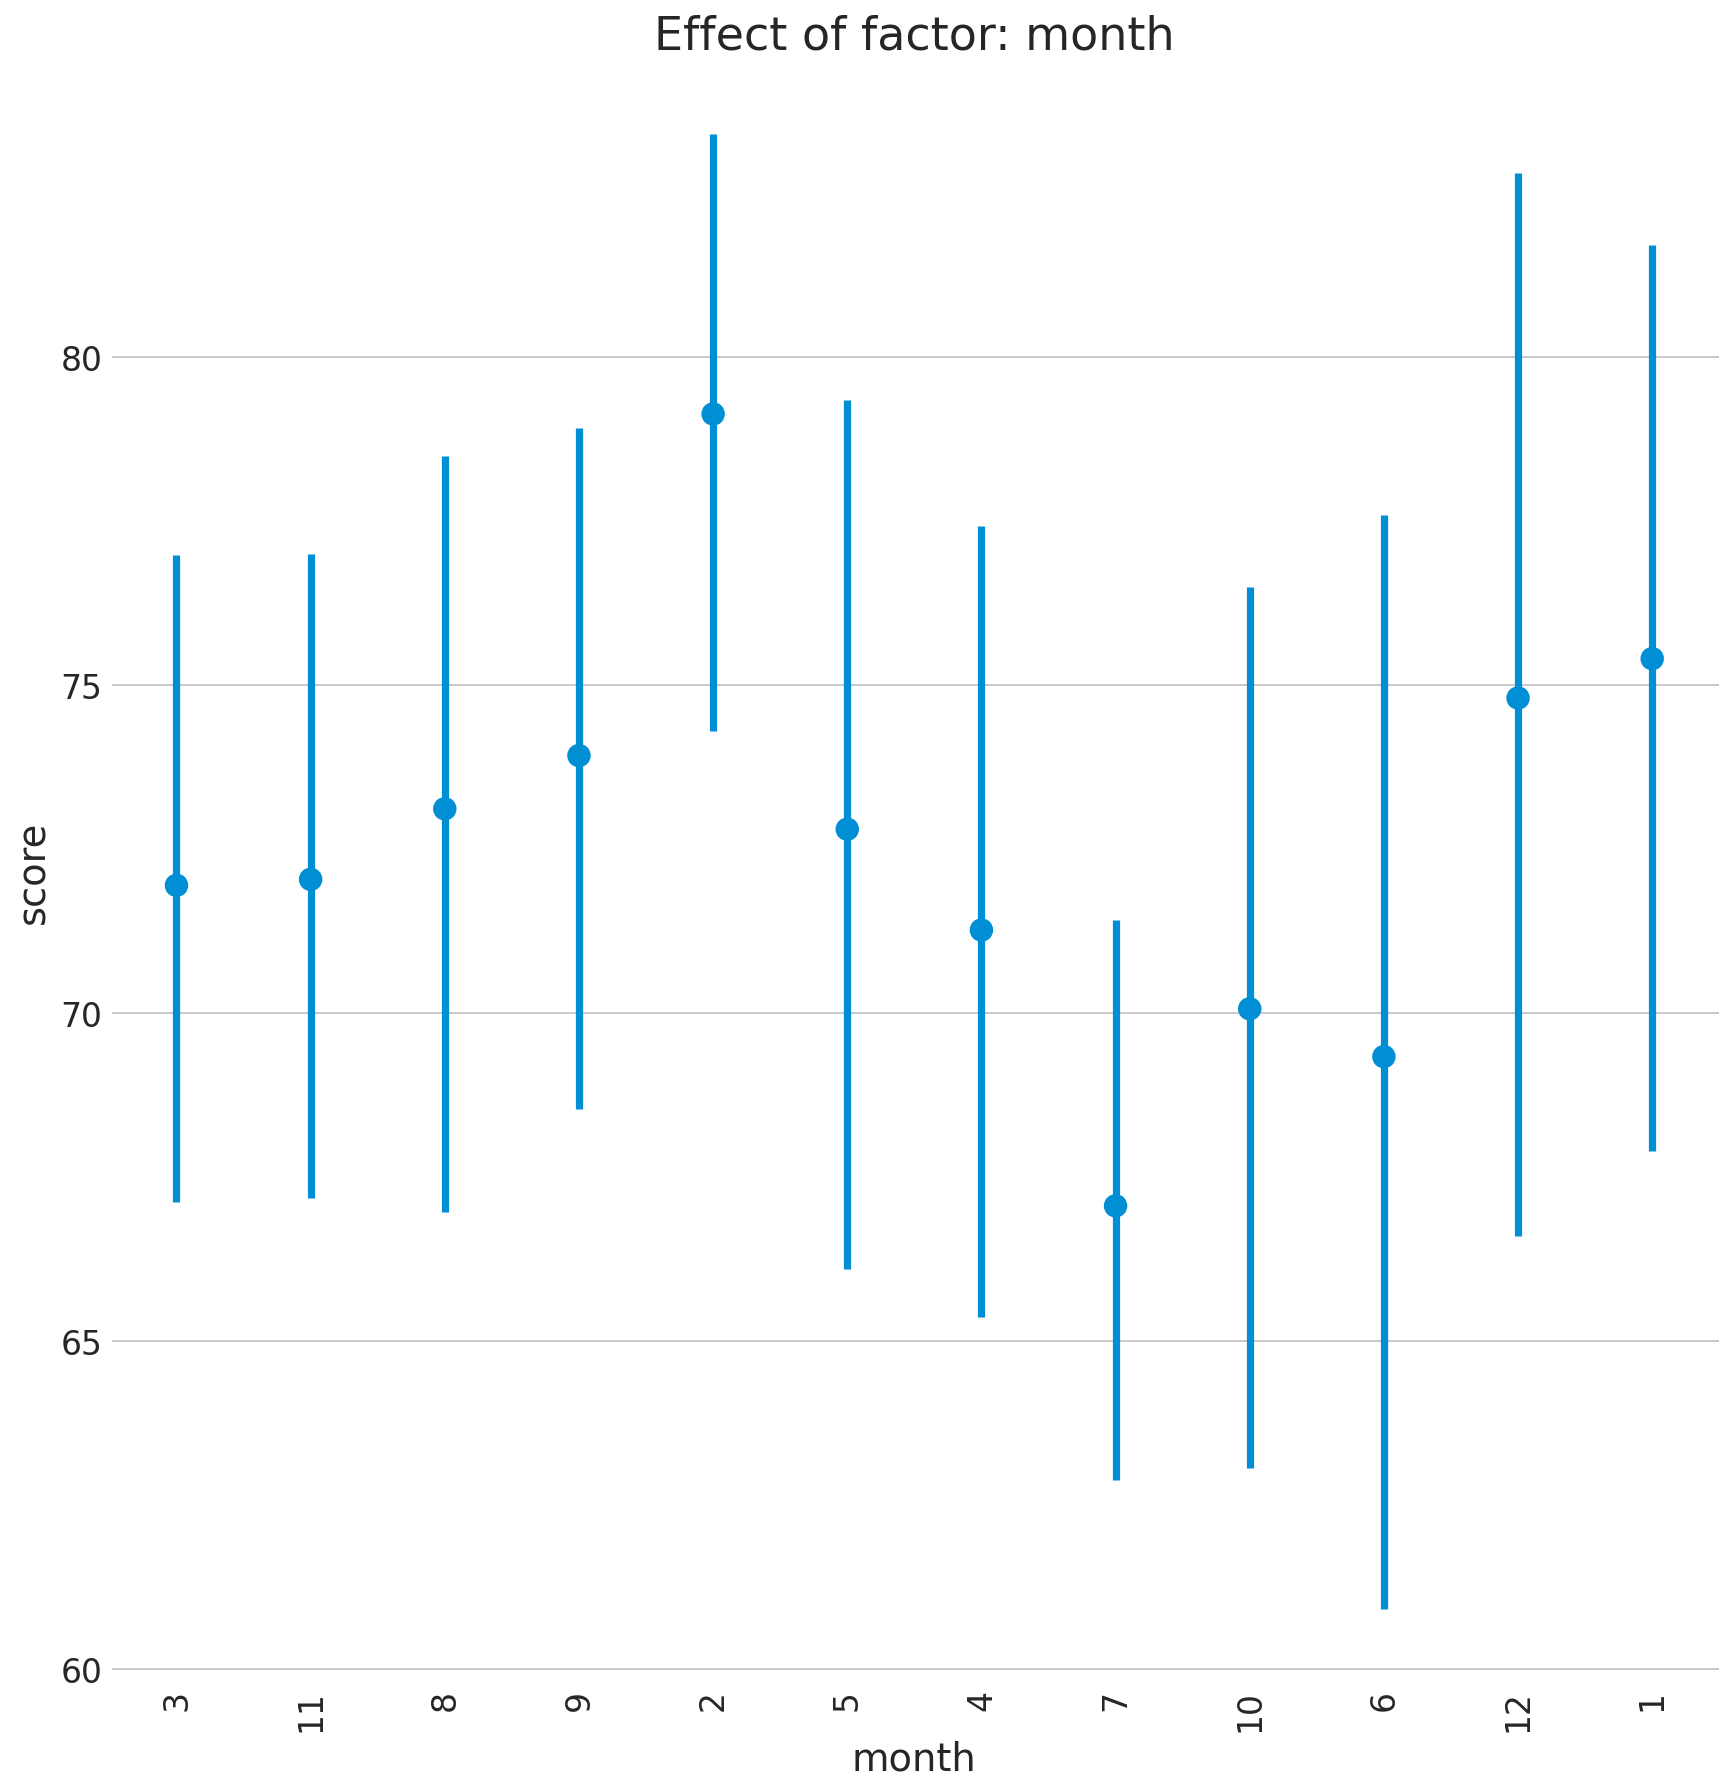

/home/jan/miniconda3/envs/jan/lib/python3.6/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5, 1.0, 'Effect of factor: ord_season')

(array([0, 1, 2, 3]),
 [Text(0, 0, '2'), Text(1, 0, '4'), Text(2, 0, '3'), Text(3, 0, '1')])

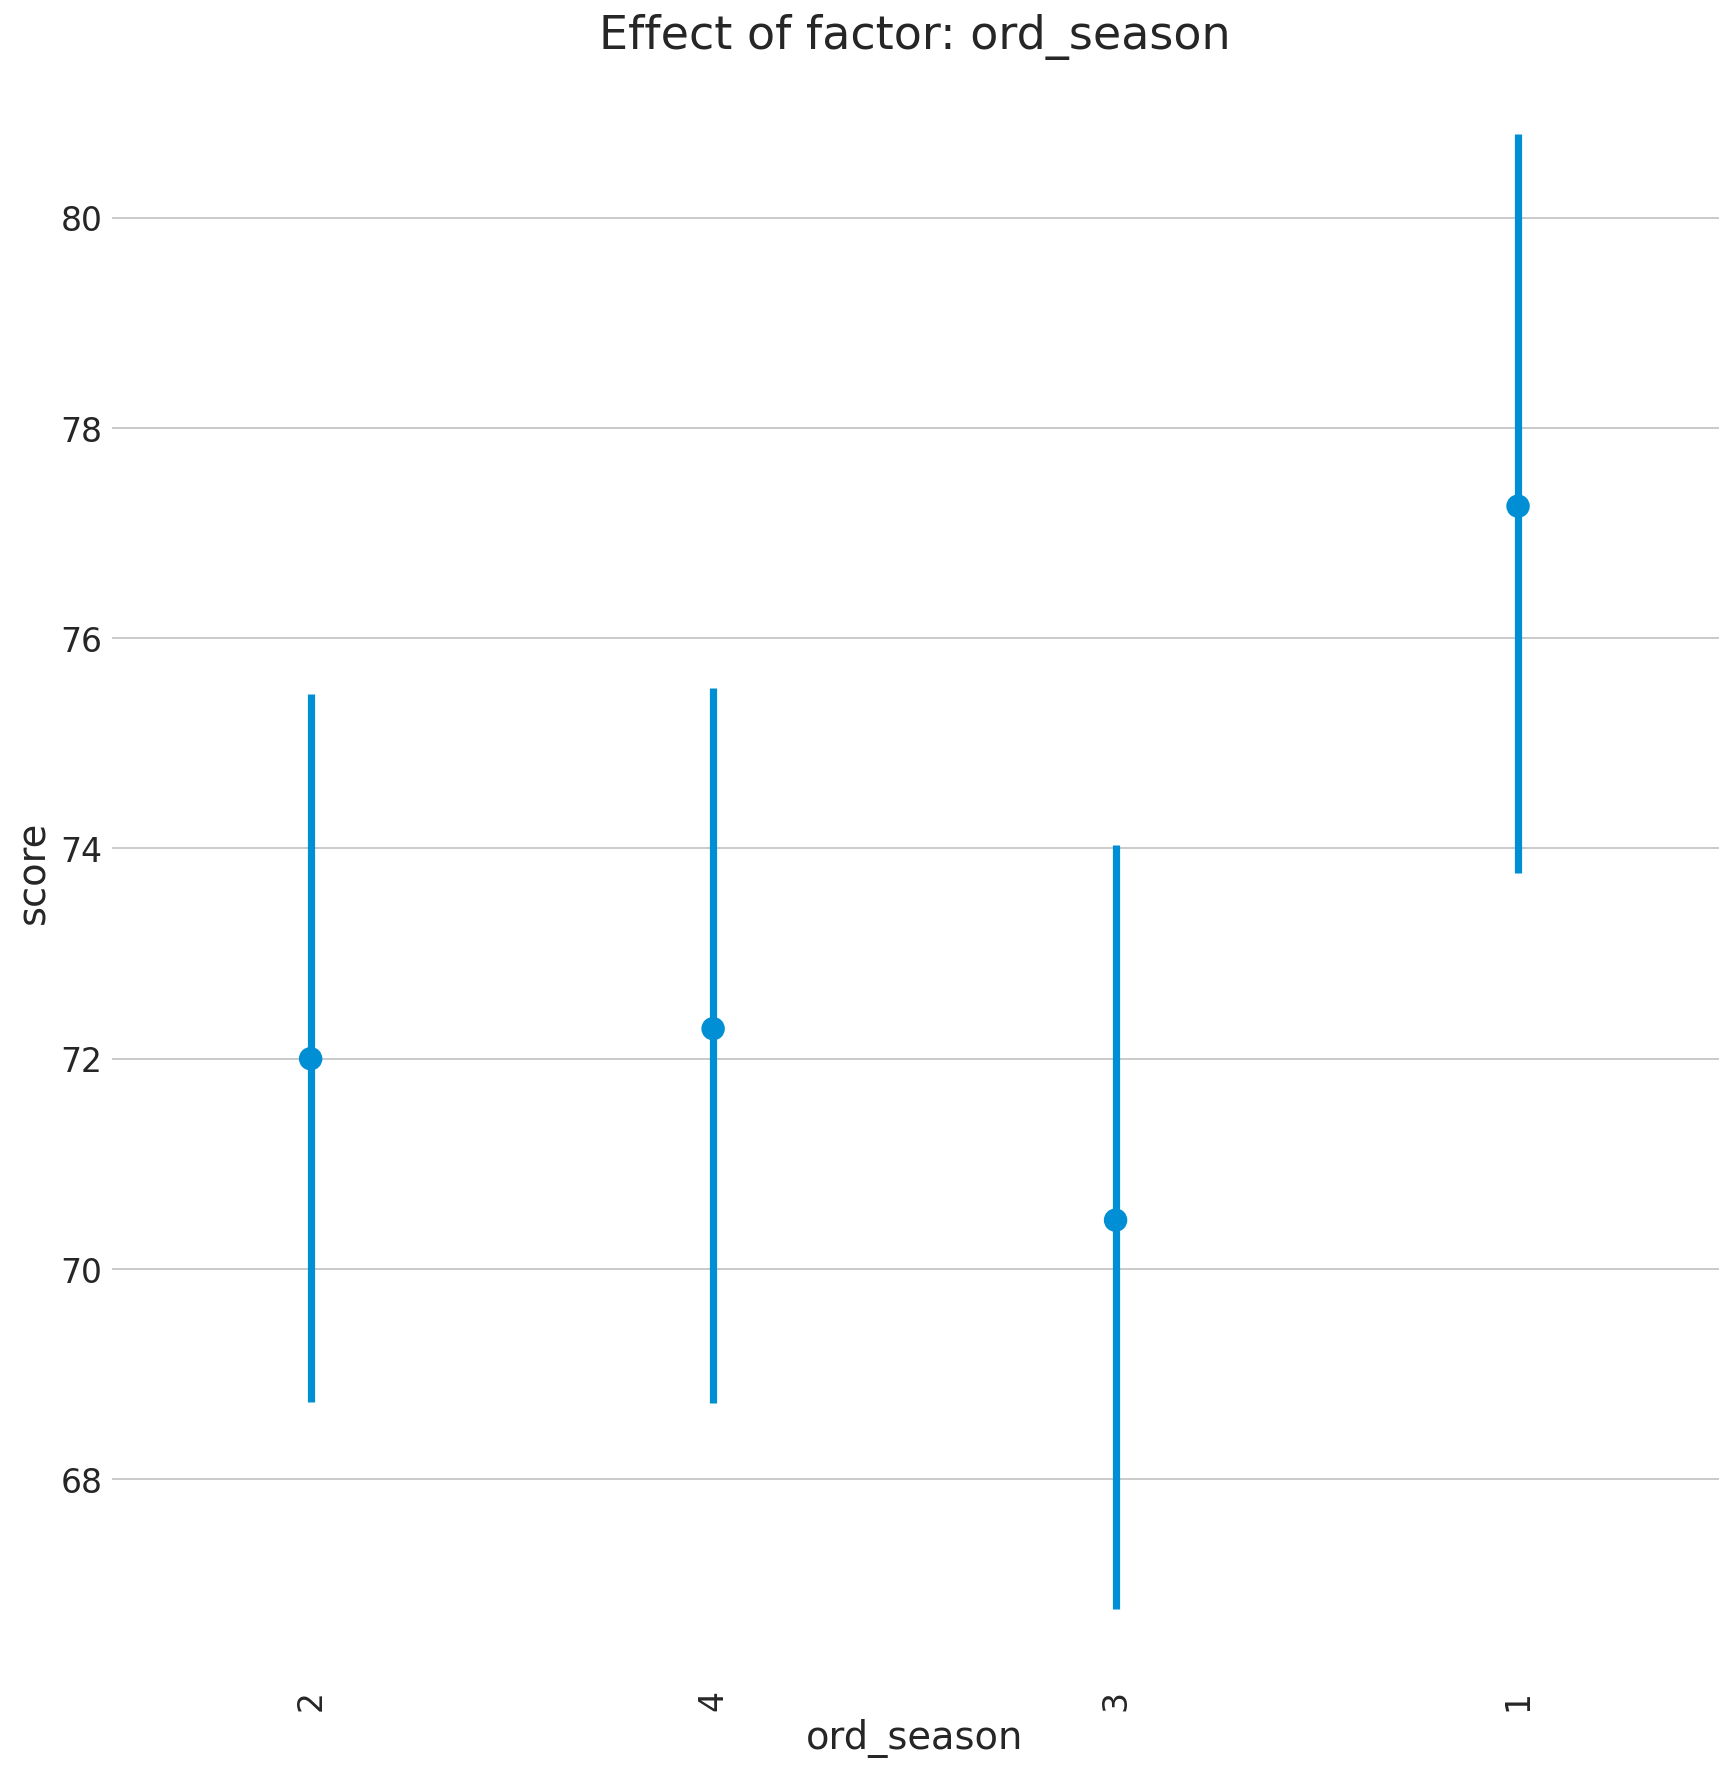

/home/jan/miniconda3/envs/jan/lib/python3.6/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5, 1.0, 'Effect of factor: year')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '2017'),
  Text(1, 0, '2018'),
  Text(2, 0, '2019'),
  Text(3, 0, '2016'),
  Text(4, 0, '2012'),
  Text(5, 0, '2013'),
  Text(6, 0, '2011'),
  Text(7, 0, '2015'),
  Text(8, 0, '2020'),
  Text(9, 0, '2014')])

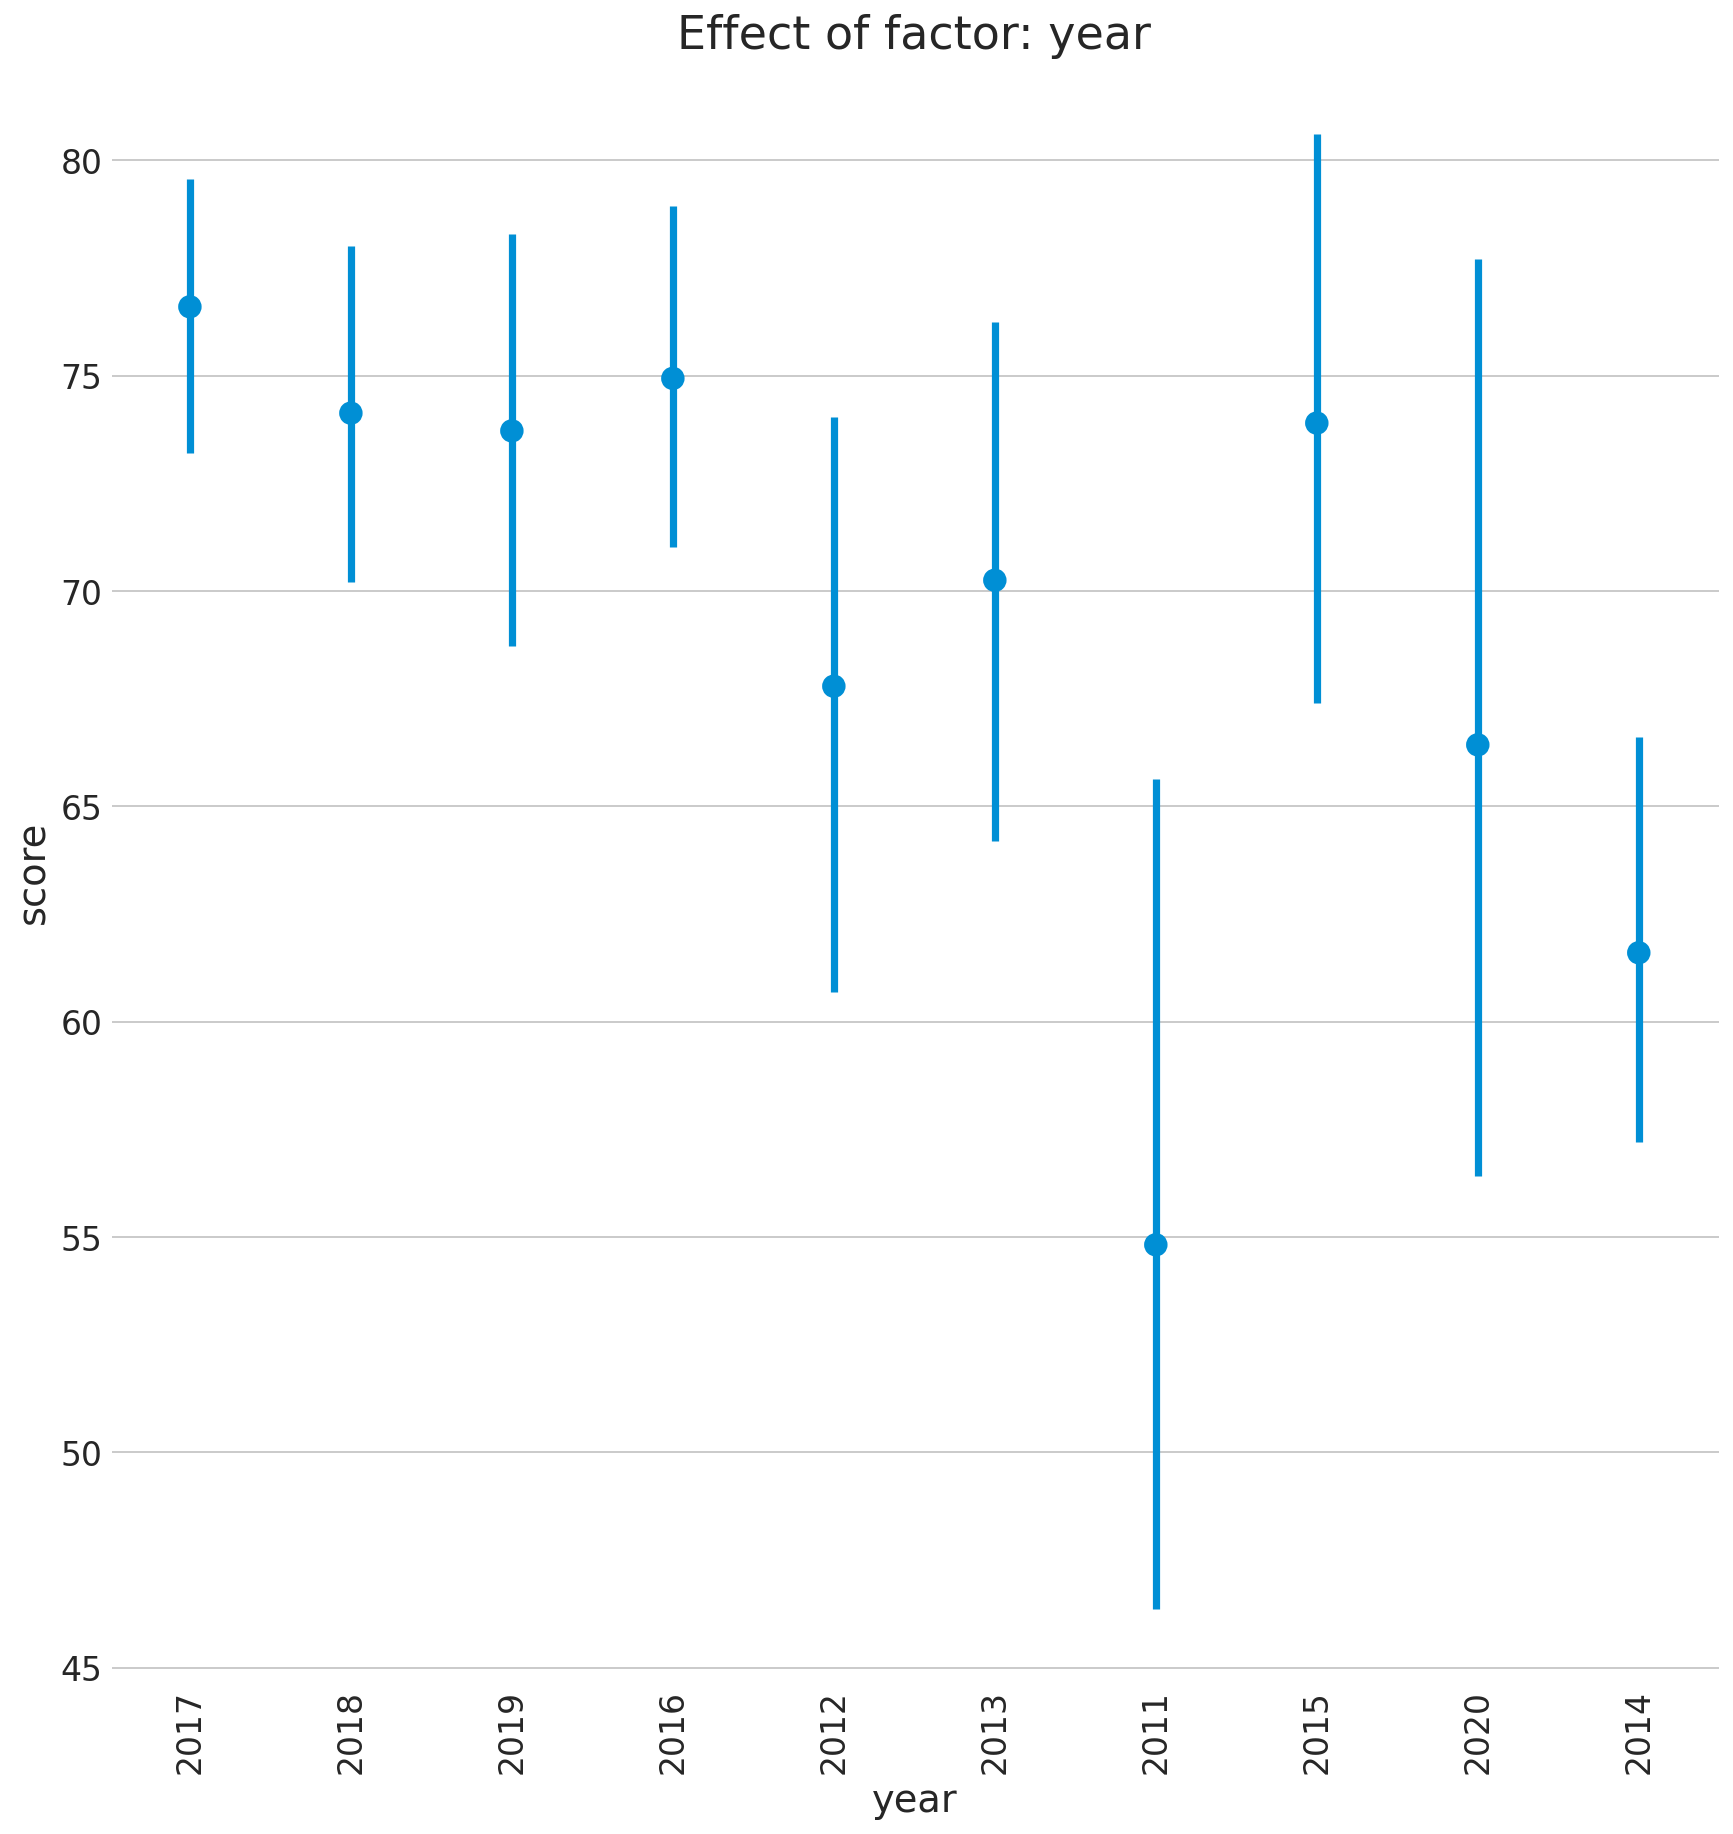

/home/jan/miniconda3/envs/jan/lib/python3.6/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5, 1.0, 'Effect of factor: tripod')

(array([0]), [Text(0, 0, 'True')])

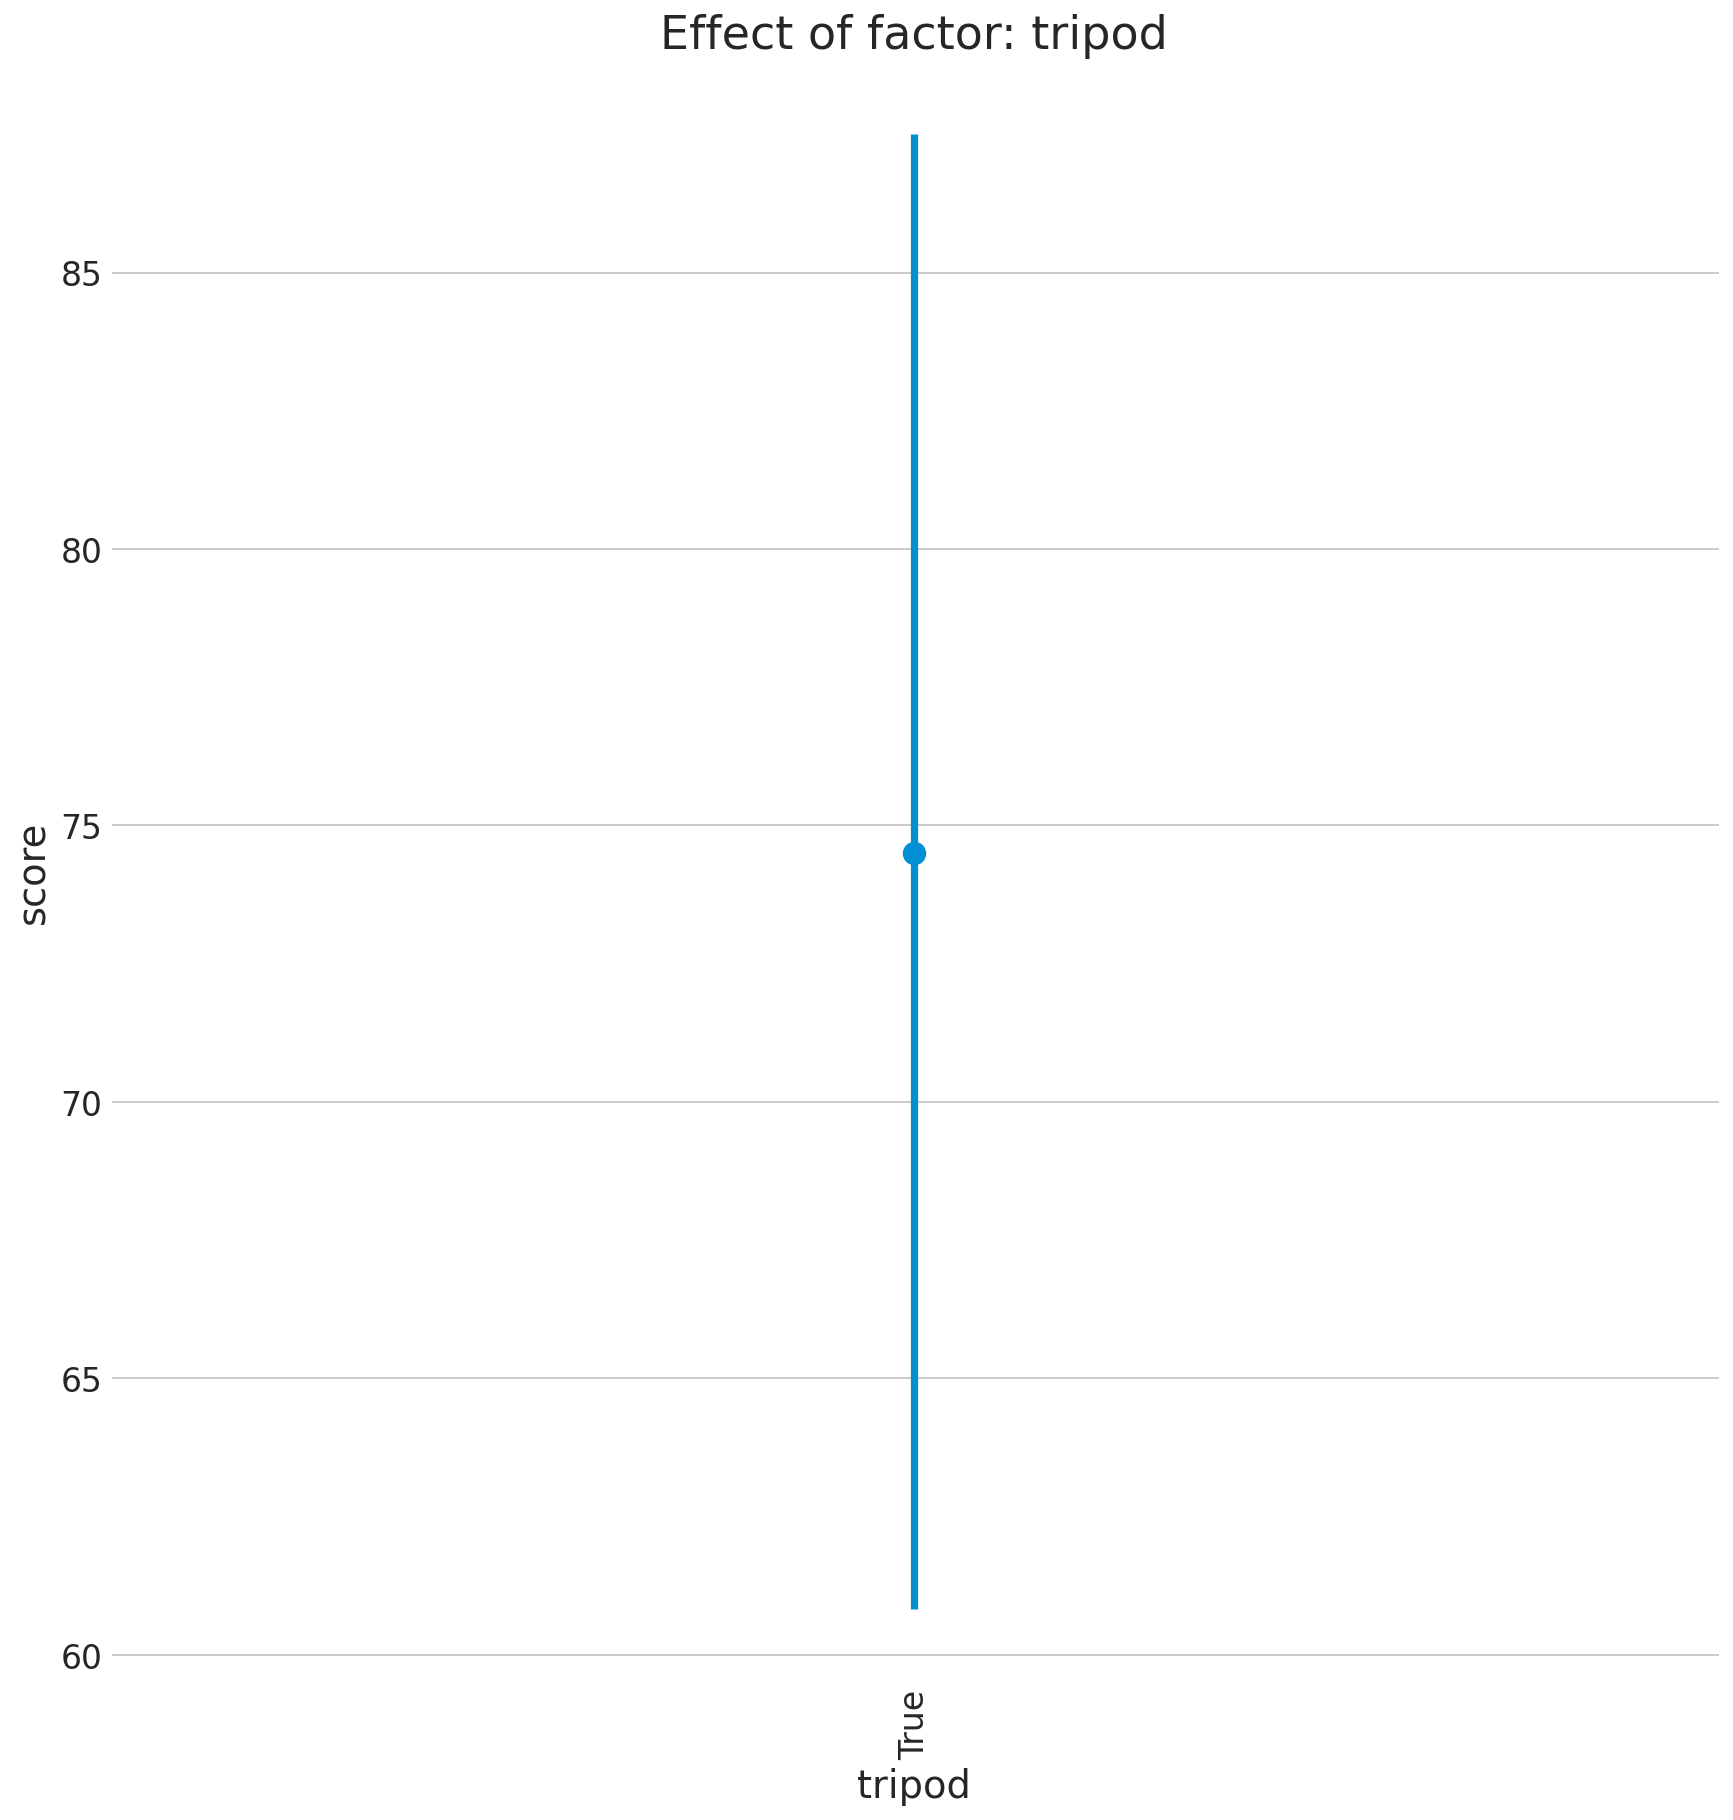

In [20]:
categorical_vars = [
    'camera',
    'camera_p_n_s',
    '35equiv_focal',
    'film_digital',
    'format',
    'shooting_circumstance',
    'filmstock',
    'lighting',
    'photo_style',
    'month',
    'ord_season',
    'year',
    'tripod',
]

for factor in categorical_vars:
    freqs = ratings[factor].value_counts()
    # Filter on level of var occurred 3+ times; sort by freq
    freqs = freqs.loc[freqs >= 3]
    levels_to_eval = freqs.index
    #print(levels_to_eval)
    
    sns.factorplot(
        x=factor,
        y='score',
        data=ratings,
        order=levels_to_eval,
        kind='point',
        join=False,
        height=12,
    )
    plt.title(f'Effect of factor: {factor}')
    plt.xticks(rotation=90)
    plt.show()

<AxesSubplot:xlabel='minutes_before_sunset', ylabel='score'>

Text(0.5, 1.0, 'Effect of minutes before sunset on photo ratings')

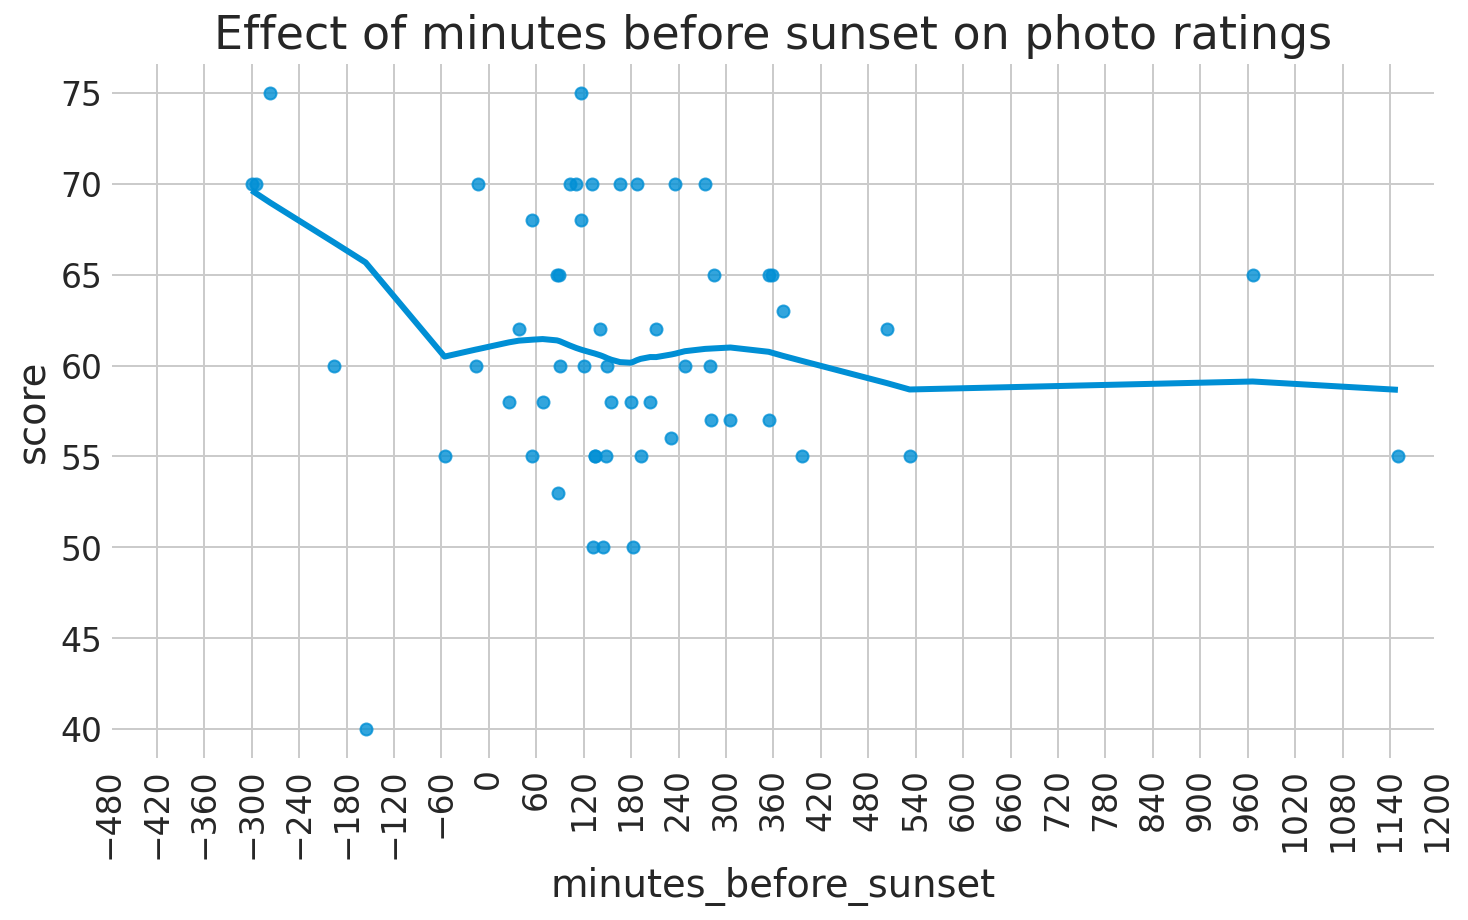

date            taken_at                    sunset  minutes_before_sunset
0  2011/11/09 2011-11-09 13:41:00 2011-11-09 17:04:45-08:00                    NaN
1  2011/11/09 2011-11-09 15:47:00 2011-11-09 17:04:45-08:00                    NaN
2  2012/01/22 2012-01-22 21:54:00 2012-01-22 17:21:15-08:00                    NaN
3  2012/03/04 2012-03-04 10:56:00 2012-03-04 18:06:22-08:00                    NaN
4  2012/09/23 2012-09-23 17:47:00 2012-09-23 19:06:23-07:00                    NaN

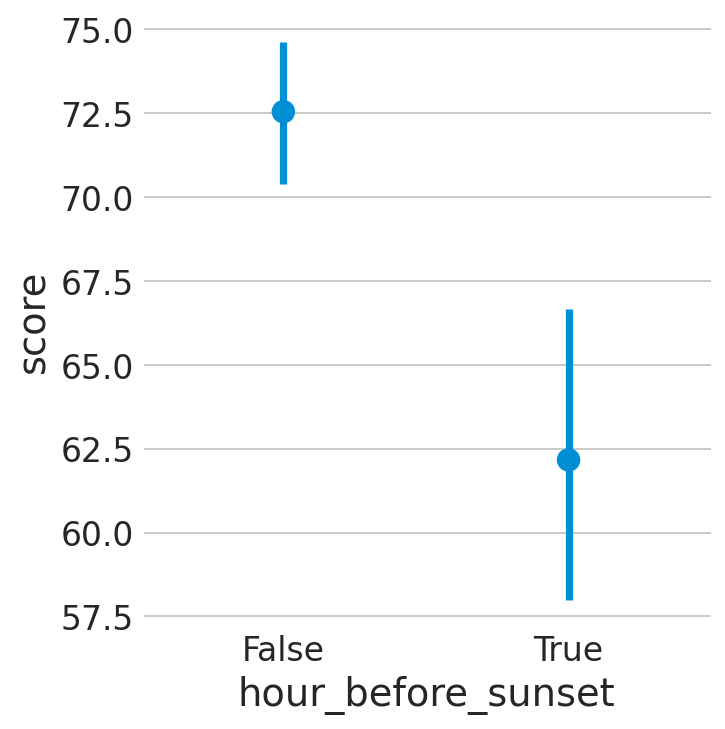

In [23]:
sns.regplot(
    x='minutes_before_sunset',
    y='score',
    data=ratings.loc[ratings.shooting_circumstance != 'vacation'],  # exclude vacation where sunset est will be off
    lowess=True
    #size=12,
    #alpha=.05,
)
_ = plt.xticks([i*60 for i in range(-8,21)], rotation=90)
plt.title(f"Effect of minutes before sunset on photo ratings")
plt.show()

ratings['hour_before_sunset'] = (ratings.minutes_before_sunset <= 60) & (ratings.minutes_before_sunset >= -30)

sns.catplot(
    x='hour_before_sunset',
    y='score',
    data=ratings.loc[ratings.shooting_circumstance != 'vacation'],  # exclude vacation where sunset est will be off
    kind='point',
    join=False,
)

ratings[['date', 'taken_at', 'sunset', 'minutes_before_sunset']].head()

Previous rule of thumb I used was to shoot 2 hours before sunset until a bit before.

But if I go on the basis of this lowess fit (obviously no CI here, subject to error), the last hour before sunset seems better than two hours before. And after sunset is still good lighting for 30 minutes to an hour or so ("blue hour").

## Basic analyses across continuous vars

<AxesSubplot:xlabel='35equiv_focal', ylabel='score'>

Text(0.5, 1.0, 'Effect of var 35equiv_focal on photo ratings')

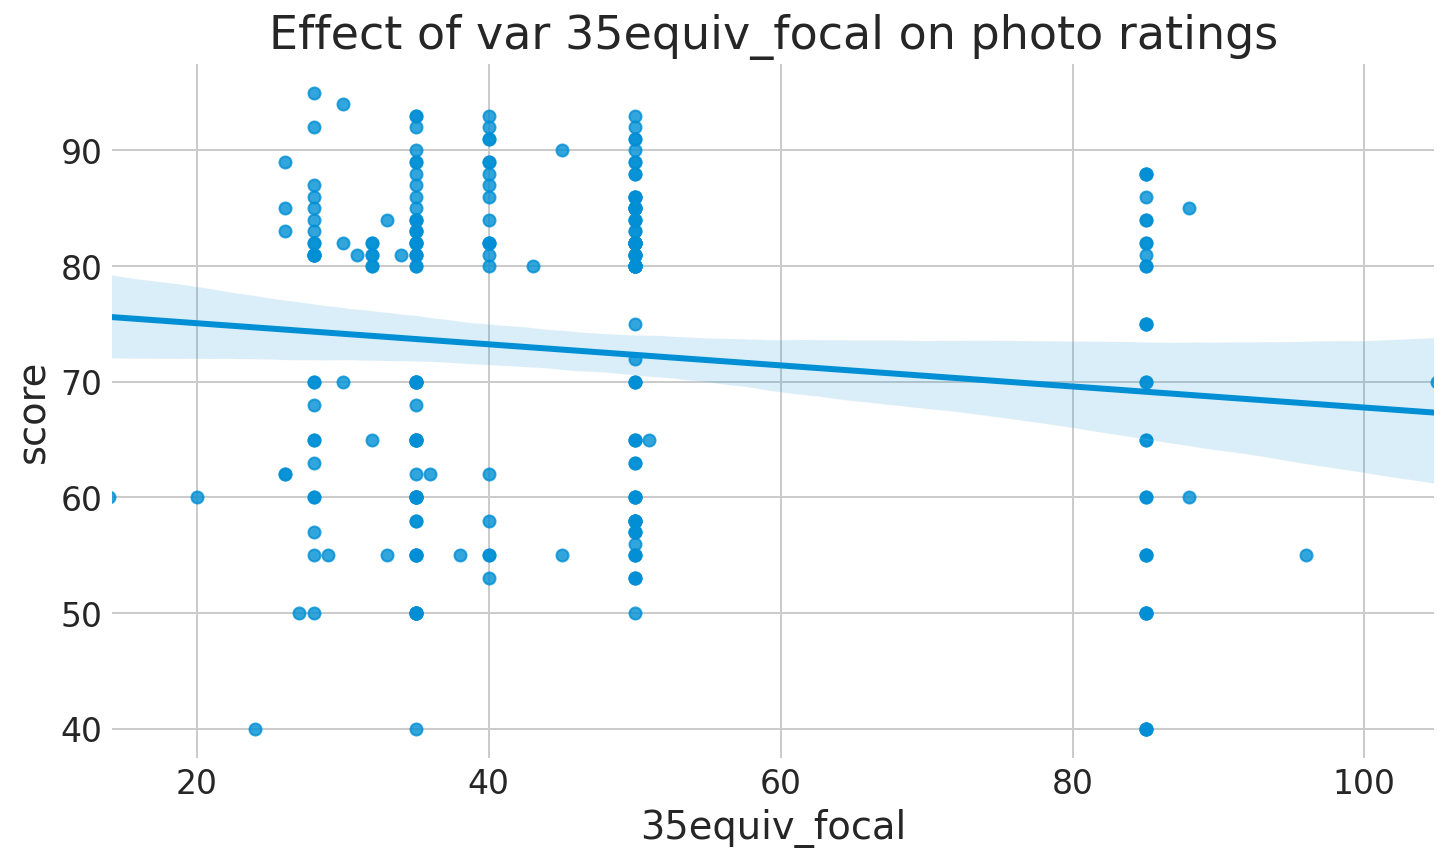

<AxesSubplot:xlabel='35equiv_focal', ylabel='score'>

Text(0.5, 1.0, 'Effect of var 35equiv_focal on photo ratings')

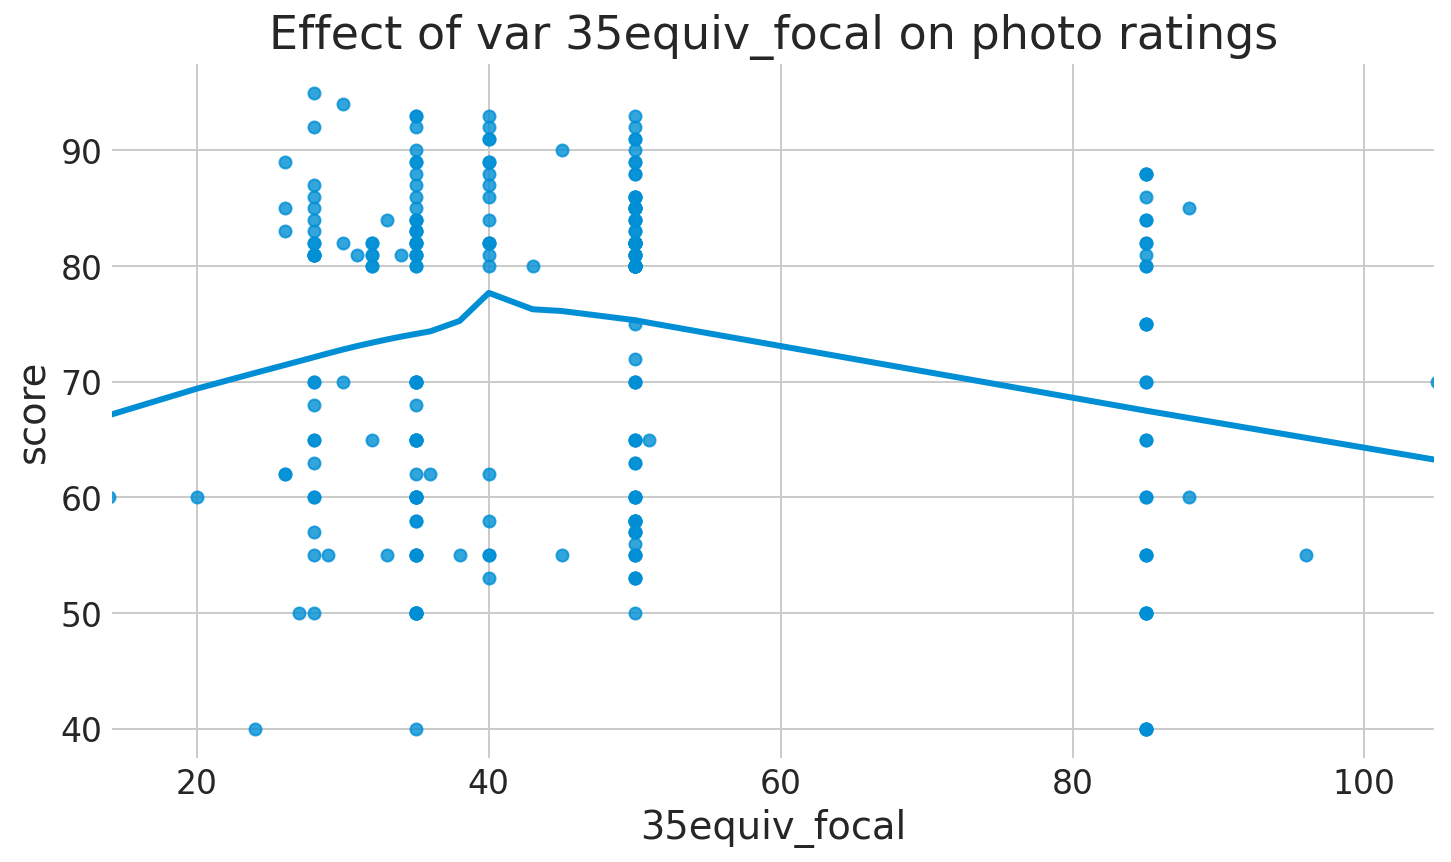

<AxesSubplot:xlabel='date_ord', ylabel='score'>

Text(0.5, 1.0, 'Effect of var date_ord on photo ratings')

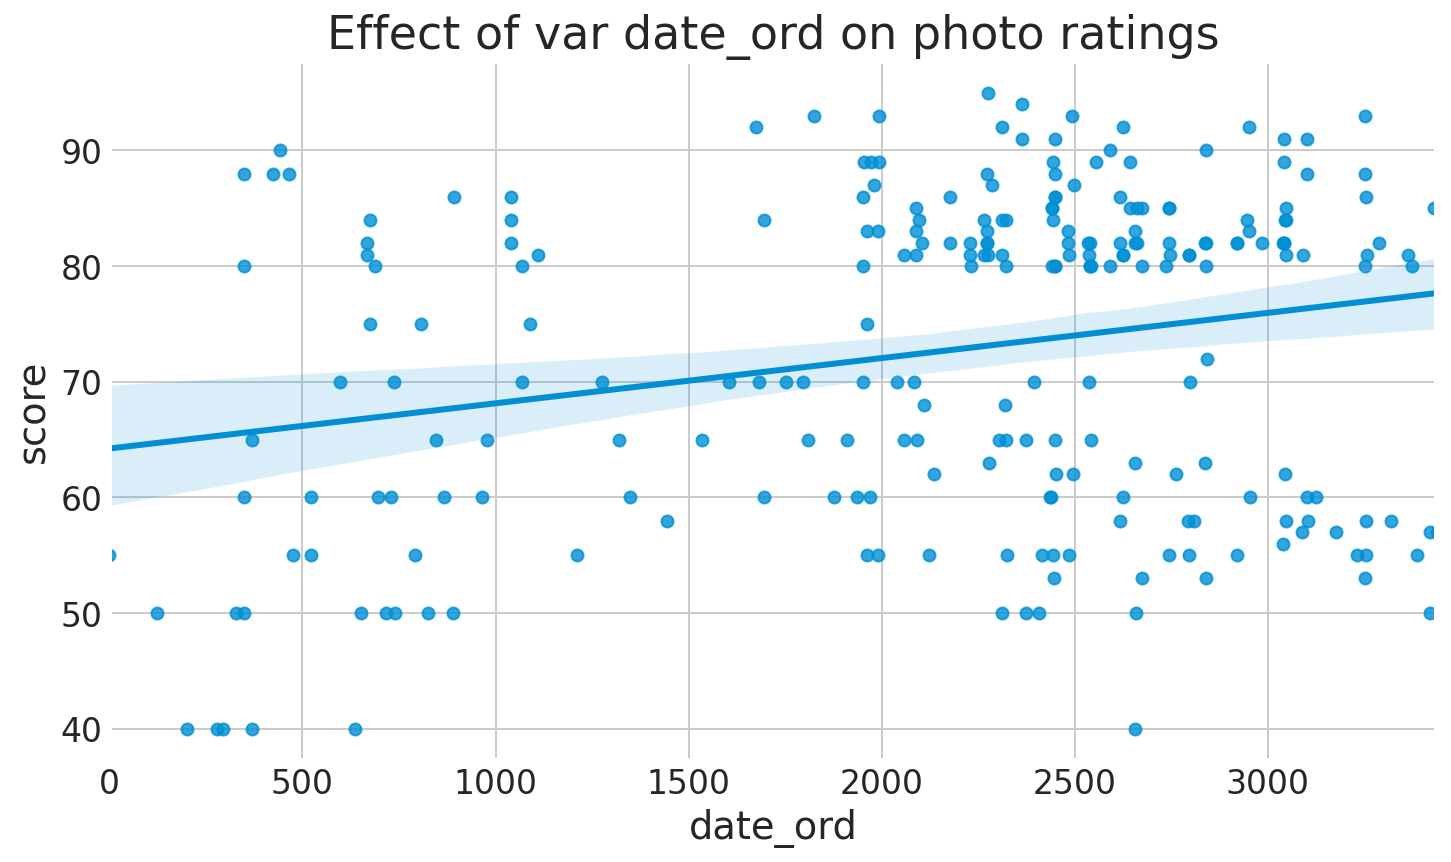

<AxesSubplot:xlabel='date_ord', ylabel='score'>

Text(0.5, 1.0, 'Effect of var date_ord on photo ratings')

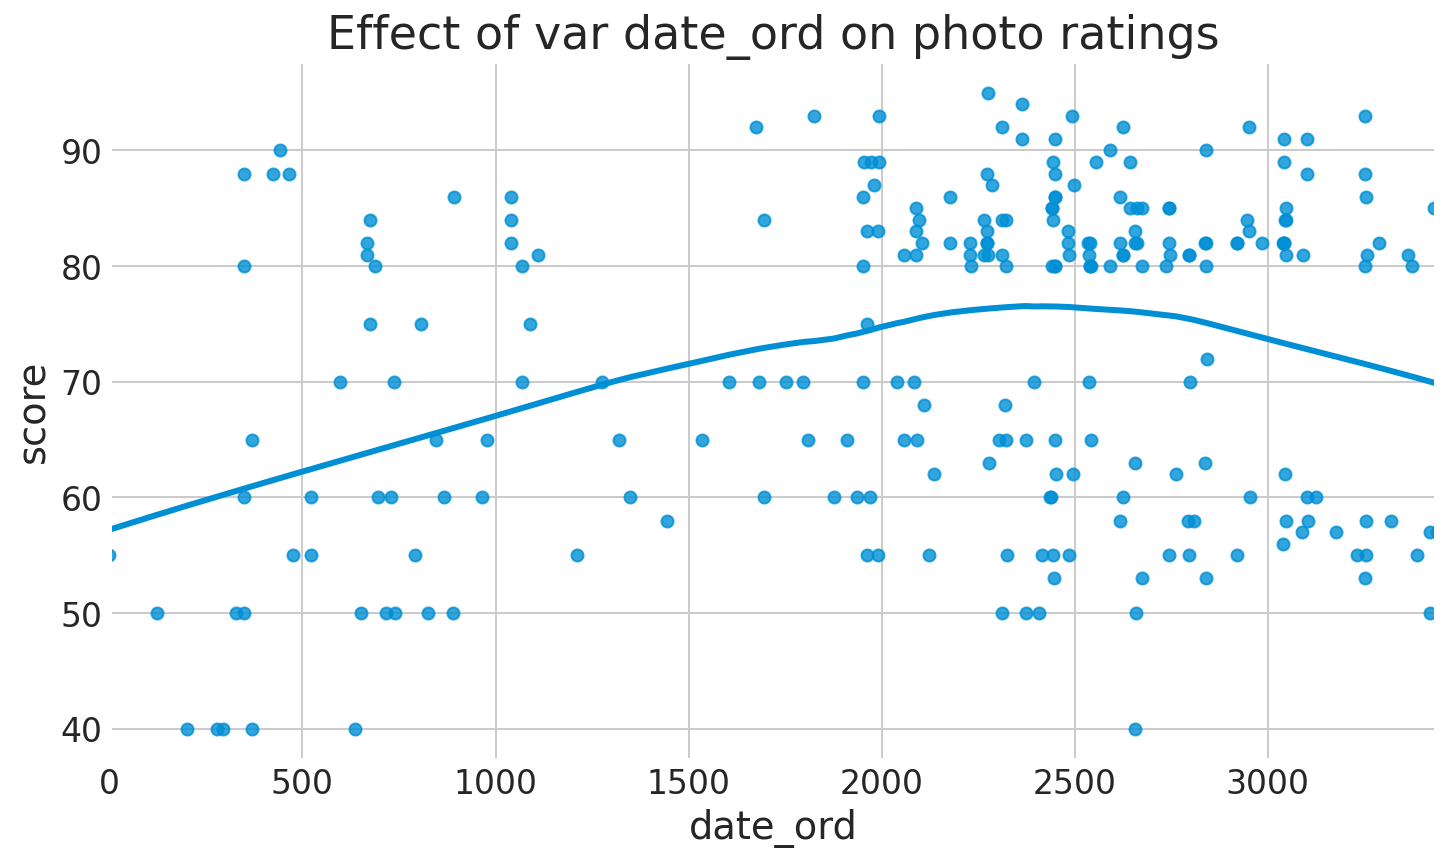

<AxesSubplot:xlabel='resolution_mp', ylabel='score'>

Text(0.5, 1.0, 'Effect of var resolution_mp on photo ratings')

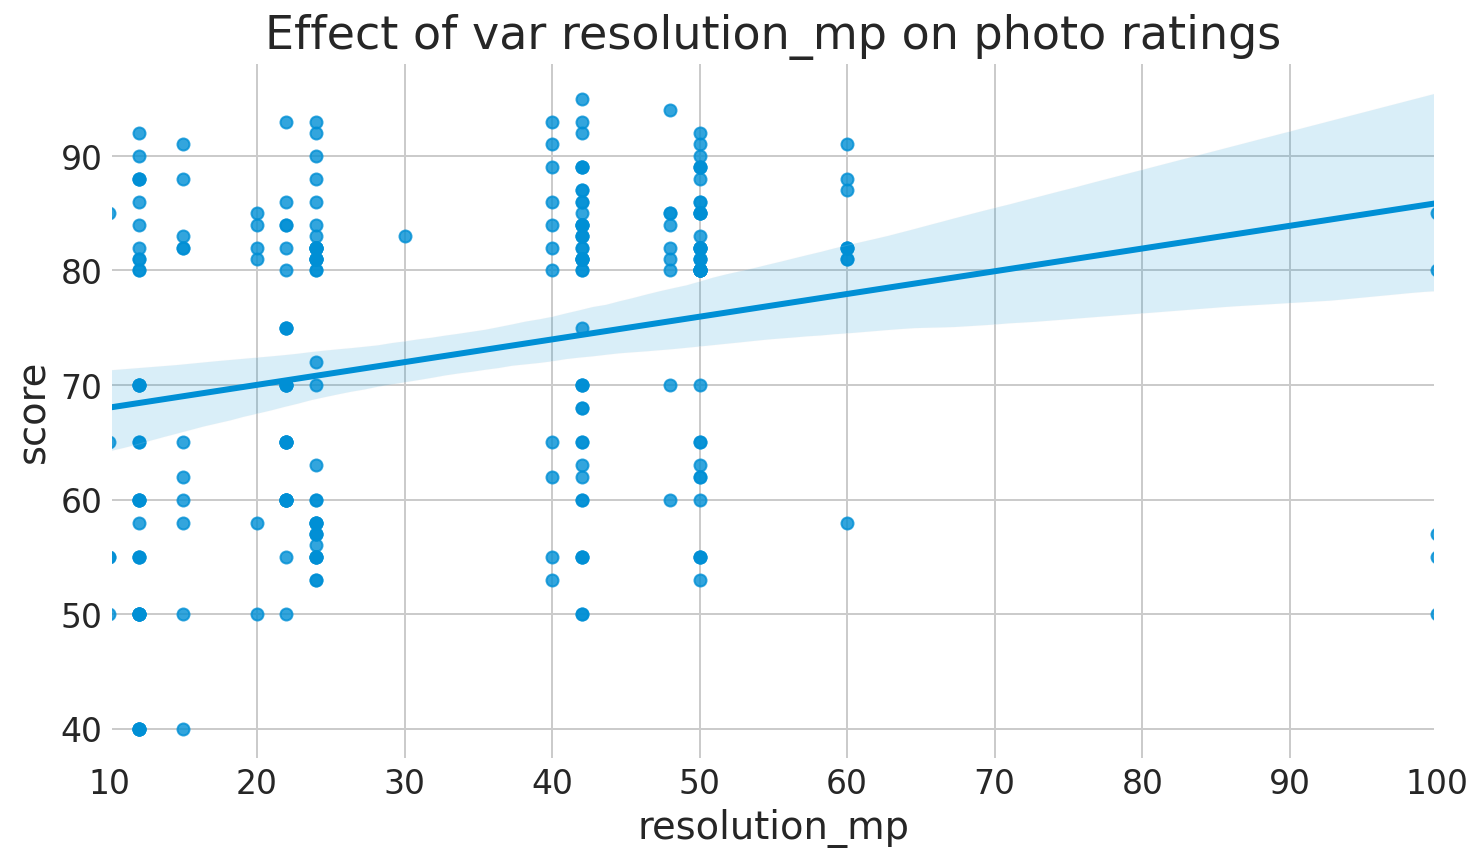

<AxesSubplot:xlabel='resolution_mp', ylabel='score'>

Text(0.5, 1.0, 'Effect of var resolution_mp on photo ratings')

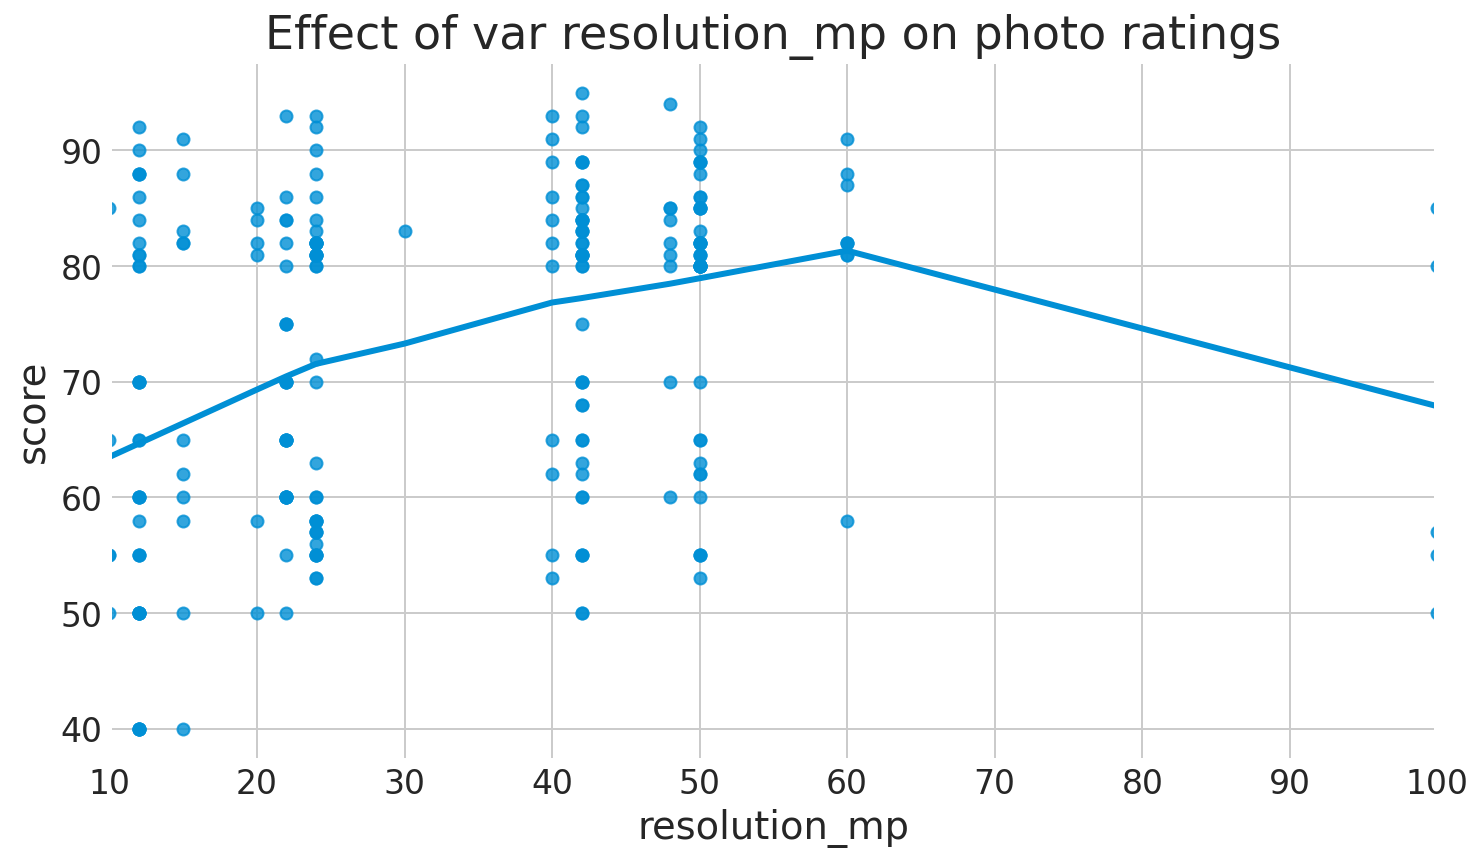

In [24]:


cts_vars = [
    '35equiv_focal',
    'date_ord',
    #'minutes_before_sunset',
    'resolution_mp',
]

for var in cts_vars:
    sns.regplot(
        x=var,
        y='score',
        data=ratings,
        #size=12,
        #alpha=.05,
    )
    plt.title(f"Effect of var {var} on photo ratings")
    plt.show()
    
    sns.regplot(
        x=var,
        y='score',
        data=ratings,
        lowess=True
        #size=12,
        #alpha=.05,
    )
    plt.title(f"Effect of var {var} on photo ratings")
    plt.show()


/home/jan/miniconda3/envs/jan/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='score', ylabel='Density'>

Text(0.5, 1.0, 'Dist of scores is bimodal / not normal via data-generating process')

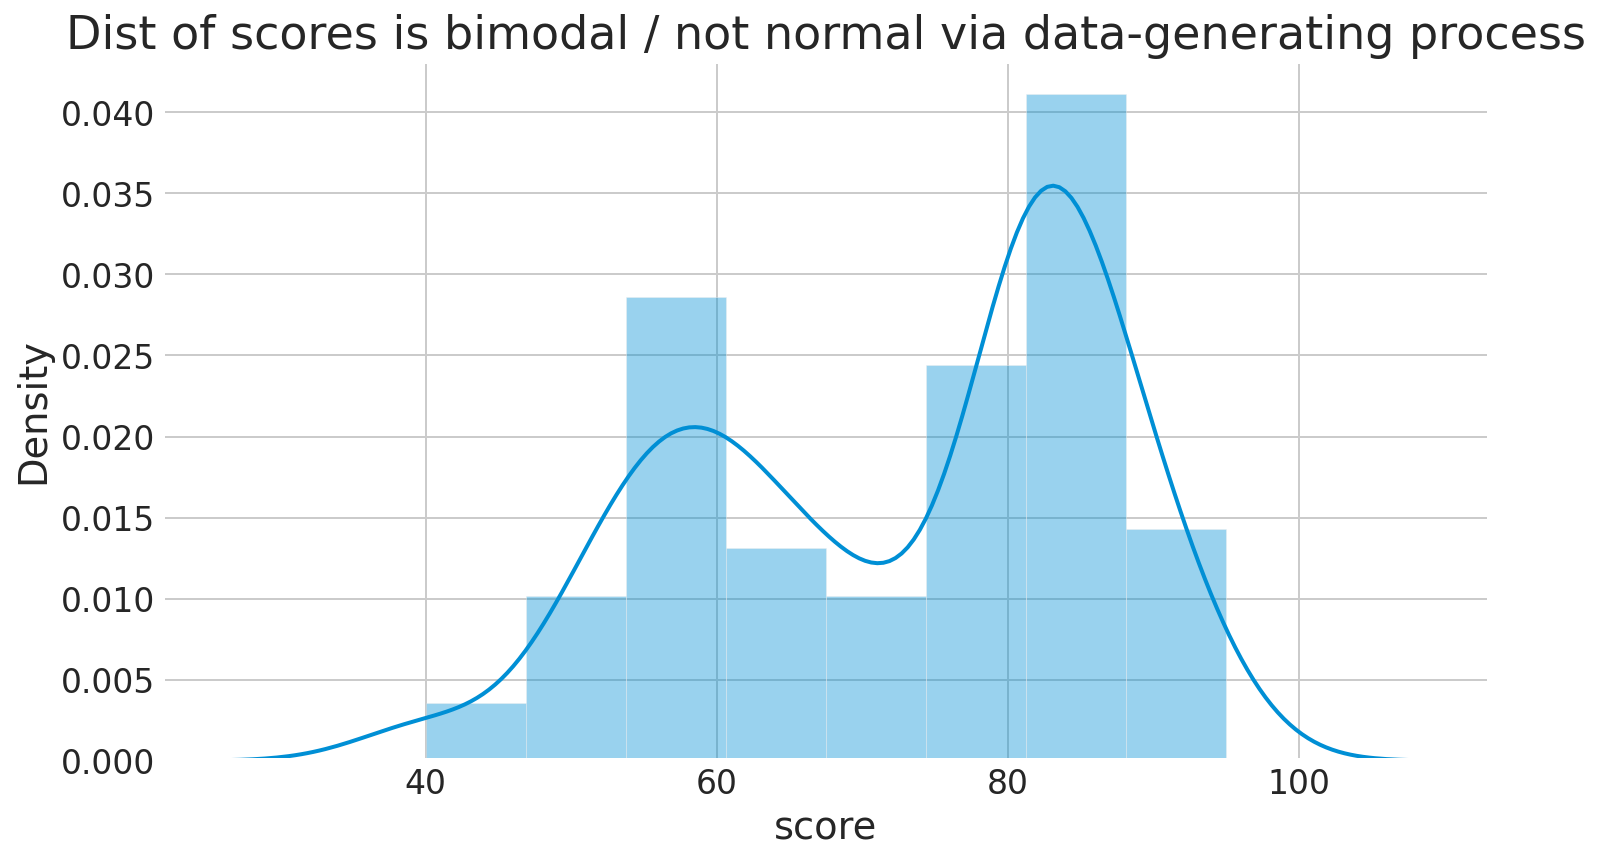

In [26]:
sns.distplot(ratings.score)
plt.title('Dist of scores is bimodal / not normal via data-generating process')
# two rating passes / sampling of "hits" and "other photos" independently
# will necessarily create this bimodality

__would be good to figure out a way to deal with score bimodality__  
unfortunately hard to avoid given that I'm sampling from two diff classes in some sense.  
could also treat as clf rather than regression, but I'd be giving up statistical power.

### Basic Frequentist Regression

In [27]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

ratings['fl'] = ratings['35equiv_focal'].copy()
formula = 'score ~ photo_style + camera_p_n_s +lighting + hour_before_sunset + shooting_circumstance + format + film_digital + date_ord + fl'

mod = smf.ols(
    formula=formula, 
    data=ratings,
)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     2.523
Date:                Mon, 28 Dec 2020   Prob (F-statistic):           0.000344
Time:                        10:03:31   Log-Likelihood:                -962.41
No. Observations:                 244   AIC:                             1971.
Df Residuals:                     221   BIC:                             2051.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               53.9910      8.429      6.405      0.000      37.379      70.603
photo_style[T.landscape]                13.6826      4.717      2.901      0.004       4.387      22.978
photo_style[T.portrait]                  5.8709      4.871      1.205      0.229      -3.728      15.470
photo_style[T.still life /  macro]      -5.0321      7.302     -0.689      0.491     -19.423       9.359
lighting[T.golden hour]                  3.0233      4.600      0.657      0.512      -6.041      12.088
lighting[T.non-soft]                    -1.6853      4.038     -0.417      0.677      -9.644       6.273
lighting[T.on-camera flash]              9.4157      5.432      1.733      0.084      -1.289      20.121
lighting[T.soft]                         0.3680      4.129      0.089      0.929      -7.770       8.506
lighting[T.studio flash]                 0.1891      6.119      0.031      0.975     -11.870      12.248
hour_before_sunset[T.True]              -9.1680      5.275     -1.738      0.084     -19.564       1.228
shooting_circumstance[T.incidental]     -1.5480      3.368     -0.460      0.646      -8.186       5.090
shooting_circumstance[T.intentional]    -0.1112      3.208     -0.035      0.972      -6.433       6.210
shooting_circumstance[T.newspaper]      10.8582      5.877      1.847      0.066      -0.724      22.441
shooting_circumstance[T.vacation]       -2.2613      3.026     -0.747      0.456      -8.224       3.702
format[T.crop_digital]                   2.6664      4.933      0.541      0.589      -7.055      12.388
format[T.ff_digital]                    -0.0699      2.375     -0.029      0.977      -4.750       4.610
format[T.mf_digital]                     2.1927      2.684      0.817      0.415      -3.096       7.482
format[T.mf_film]                        9.8053      4.750      2.064      0.040       0.444      19.167
format[T.pano_film]                      8.2829      7.023      1.179      0.240      -5.559      22.124
film_digital[T.c41_film]                -3.2739      4.293     -0.763      0.447     -11.735       5.187
film_digital[T.digital]                  4.7892      3.202      1.496      0.136      -1.520      11.099
camera_p_n_s                            -6.6688      7.121     -0.937      0.350     -20.702       7.365
date_ord                                 0.0023      0.002      1.326      0.186      -0.001       0.006
fl                                      -0.0430      0.070     -0.616      0.538      -0.181       0.095
==============================================================================
Omnibus:                       18.103   Durbin-Watson:                   0.646
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               12.573
Skew:      

significant features: 
- type of photo: event/party, landscape, portrait  
- shooting occasion: incidental shooting (non-intentional), intentional, trend toward signif for vacation
- film format: medium-format film, pano film, trend for MF digital

In [28]:
# simplified model

mod = smf.ols(
    formula='score ~ photo_style + hour_before_sunset + format', 
    data=ratings,
)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     4.691
Date:                Mon, 28 Dec 2020   Prob (F-statistic):           9.81e-06
Time:                        10:03:41   Log-Likelihood:                -969.51
No. Observations:                 244   AIC:                             1959.
Df Residuals:                     234   BIC:                             1994.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             59.1471      4.594     12.874      0.000      50.095      68.199
photo_style[T.landscape]              11.2010      2.976      3.764      0.000       5.338      17.064
photo_style[T.portrait]                6.3332      3.595      1.762      0.079      -0.749      13.416
photo_style[T.still life /  macro]    -0.5592      6.101     -0.092      0.927     -12.578      11.460
hour_before_sunset[T.True]            -9.1382      5.116     -1.786      0.075     -19.217       0.940
format[T.crop_digital]                 2.5501      4.720      0.540      0.589      -6.748      11.848
format[T.ff_digital]                   4.6018      3.754      1.226      0.222      -2.795      11.998
format[T.mf_digital]                   6.5347      4.021      1.625      0.105      -1.387      14.456
format[T.mf_film]                      8.8887      4.301      2.067      0.040       0.415      17.362
format[T.pano_film]                    5.7570      6.101      0.944      0.346      -6.263      17.777
==============================================================================
Omnibus:                       19.466   Durbin-Watson:                   0.524
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.188
Skew:                          -0.444   Prob(JB):                      0.00137
Kurtosis:                       2.286   Cond. No.                         15.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## honestly, not sure how much value we'll get from a bayesian model, but sure, why not

- use above filtering to inform model; this is obviously problematic and will make results seem more signif

In [22]:
ratings.score.mean()

72.65573770491804

In [23]:
MCMC_SAMPLES = 10000
TUNE_ITERS = 2000
FEATS = [
    'photo_style', 
    'hour_before_sunset',
    #'shooting_circumstance',
    'format',
]
import category_encoders as ce

In [24]:
import category_encoders as ce

ohe = ce.OneHotEncoder(
    use_cat_names=True,
)

xs = ratings[FEATS].copy()
xs = ohe.fit_transform(xs).astype('float32')
xs.head()
labels = xs.columns.tolist()


with pm.Model() as model: 
    # Mildly informative priors
    priors = {
        f'{feat}': pm.StudentT.dist(sd=50, mu=0, nu=5) for i, feat in enumerate(xs.columns.tolist())  # nu is df
    }
    # I'm going to nudge the intercept toward the mean rating to make results more interpretable.
    priors['Intercept'] = pm.StudentT.dist(mu=ratings.score.mean(), sd=50, nu=5)
    #priors['lam'] = pm.HalfStudentT.dist(sd=50, mu=0, nu=3)

    family = pm.glm.families.StudentT()

    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    pm.glm.linear.GLM(
        x=xs.values,
        y=ratings['score'].values,
        labels=labels,  # 'labels' as in names, not y var
        family=family,
        priors=priors,
    )
    trace = pm.sample(
        MCMC_SAMPLES,
        tune=TUNE_ITERS,
        nuts_kwargs={'max_treedepth': 14}, 
        random_seed=42,
        target_accept=.85
    )

photo_style_event/party  photo_style_portrait  photo_style_landscape  photo_style_still life /  macro  hour_before_sunset  \
0                      1.0                   0.0                    0.0                              0.0                 0.0   
1                      1.0                   0.0                    0.0                              0.0                 0.0   
2                      1.0                   0.0                    0.0                              0.0                 0.0   
3                      0.0                   1.0                    0.0                              0.0                 0.0   
4                      0.0                   1.0                    0.0                              0.0                 0.0   

   format_ff_digital  format_crop_digital  format_mf_film  format_35mm_film  format_mf_digital  format_pano_film  
0                1.0                  0.0             0.0               0.0                0.0               0.0  
1                1.0                  0.0             0.0               0.0                0.0               0.0  
2                1.0                  0.0             0.0               0.0                0.0               0.0  
3                1.0                  0.0             0.0               0.0                0.0               0.0  
4                1.0                  0.0             0.0               0.0                0.0               0.0

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam, format_pano_film, format_mf_digital, format_35mm_film, format_mf_film, format_crop_digital, format_ff_digital, hour_before_sunset, photo_style_still life /  macro, photo_style_landscape, photo_style_portrait, photo_style_event/party, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 48000/48000 [07:32<00:00, 106.14draws/s]
The number of effective samples is smaller than 25% for some parameters.


mean      sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  ess_bulk  ess_tail  r_hat
Intercept                        68.306  26.366  18.941  118.395      0.261    0.185   10208.0  10208.0   10190.0   13257.0    1.0
photo_style_event/party         -11.680  22.265 -52.822   30.985      0.216    0.159   10604.0   9746.0   10605.0   12822.0    1.0
photo_style_portrait              4.961  22.290 -36.338   47.872      0.216    0.164   10649.0   9268.0   10655.0   12678.0    1.0
photo_style_landscape            11.090  22.188 -30.897   52.643      0.216    0.162   10576.0   9406.0   10579.0   12639.0    1.0
photo_style_still life /  macro  -6.985  22.327 -48.249   35.564      0.216    0.161   10714.0   9559.0   10720.0   12990.0    1.0
hour_before_sunset                5.676   2.032   1.766    9.430      0.013    0.009   24630.0  23527.0   24603.0   21300.0    1.0
format_ff_digital                 1.264  18.157 -32.391   36.267      0.191    0.135    9001.0   9001.0    8997.0   10837.0    1.0
format_crop_digital               0.806  18.397 -34.925   34.886      0.192    0.136    9151.0   9151.0    9150.0   11431.0    1.0
format_mf_film                    2.845  18.189 -32.413   36.198      0.191    0.135    9036.0   9036.0    9032.0   11161.0    1.0
format_35mm_film                 -8.075  18.664 -43.493   26.712      0.192    0.136    9436.0   9436.0    9438.0   12738.0    1.0
format_mf_digital                 1.653  18.196 -33.044   35.811      0.192    0.136    9002.0   9002.0    8998.0   10785.0    1.0
format_pano_film                 -1.668  18.488 -37.091   32.740      0.193    0.136    9206.0   9206.0    9203.0   12309.0    1.0
lam                               0.023   0.005   0.015    0.031      0.000    0.000   23112.0  21681.0   24351.0   20583.0    1.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f230e29c7f0>,
      dtype=object)

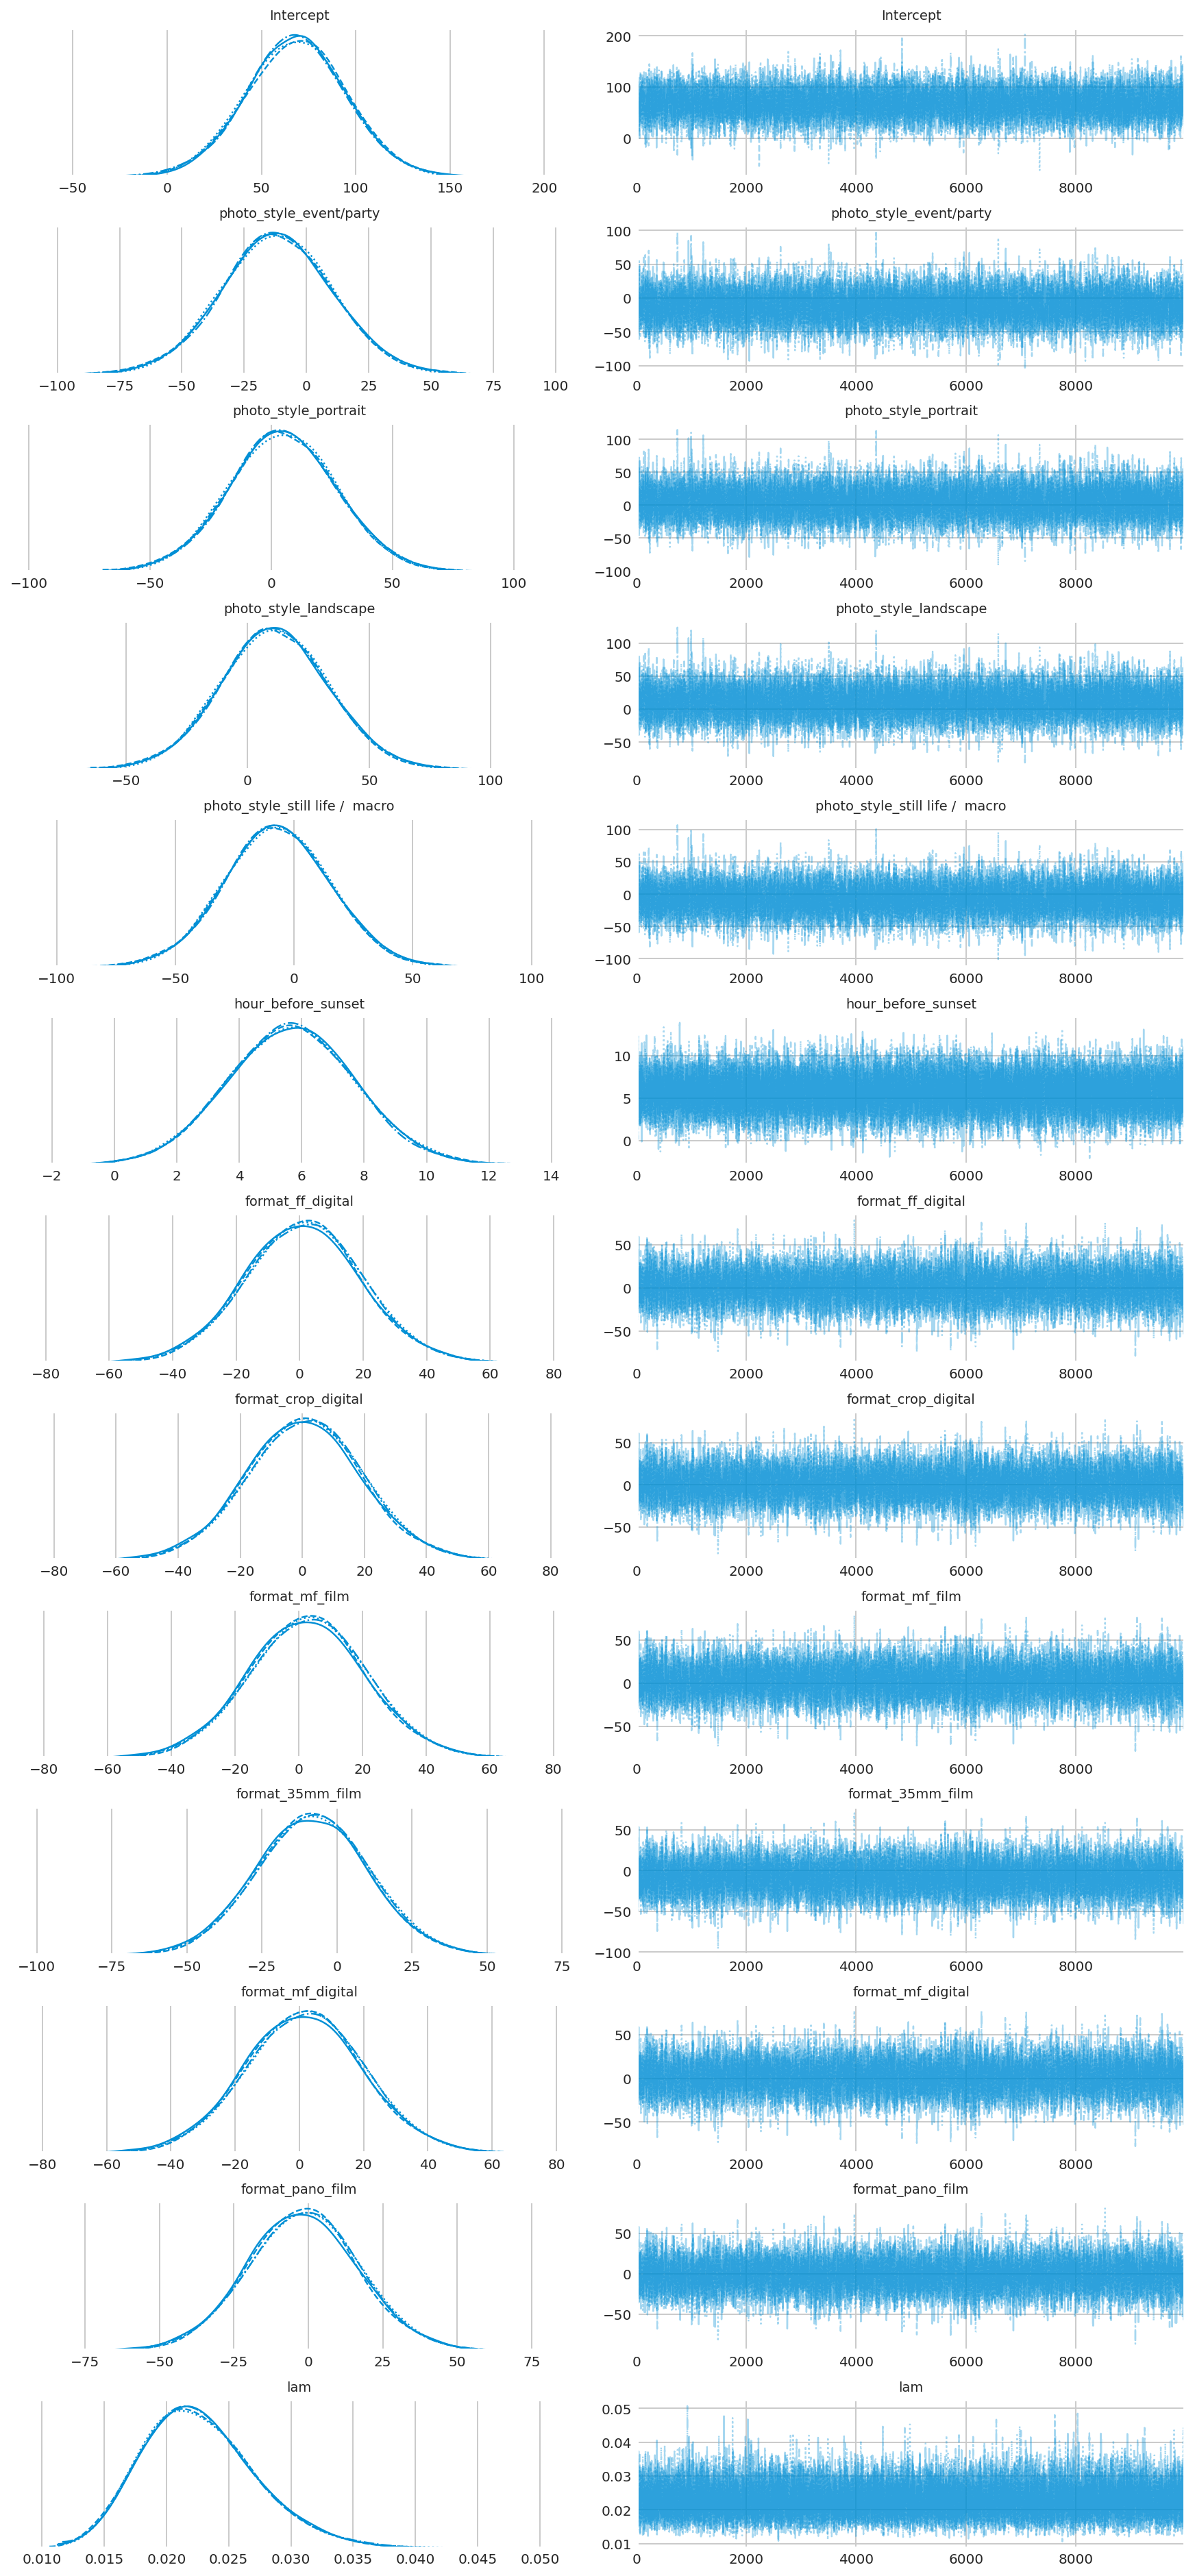

In [25]:
pm.summary(trace).round(4)

_ = pm.traceplot(trace)
plt.show()

/home/jan/miniconda3/envs/jan/lib/python3.6/site-packages/arviz/plots/plot_utils.py:653: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (52) in plot_autocorr, generating only 40 plots
  UserWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f22fe6ccc18>,
      dtype=object)

<Figure size 864x576 with 0 Axes>

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f230e139908>],
      dtype=object)

<Figure size 864x576 with 0 Axes>

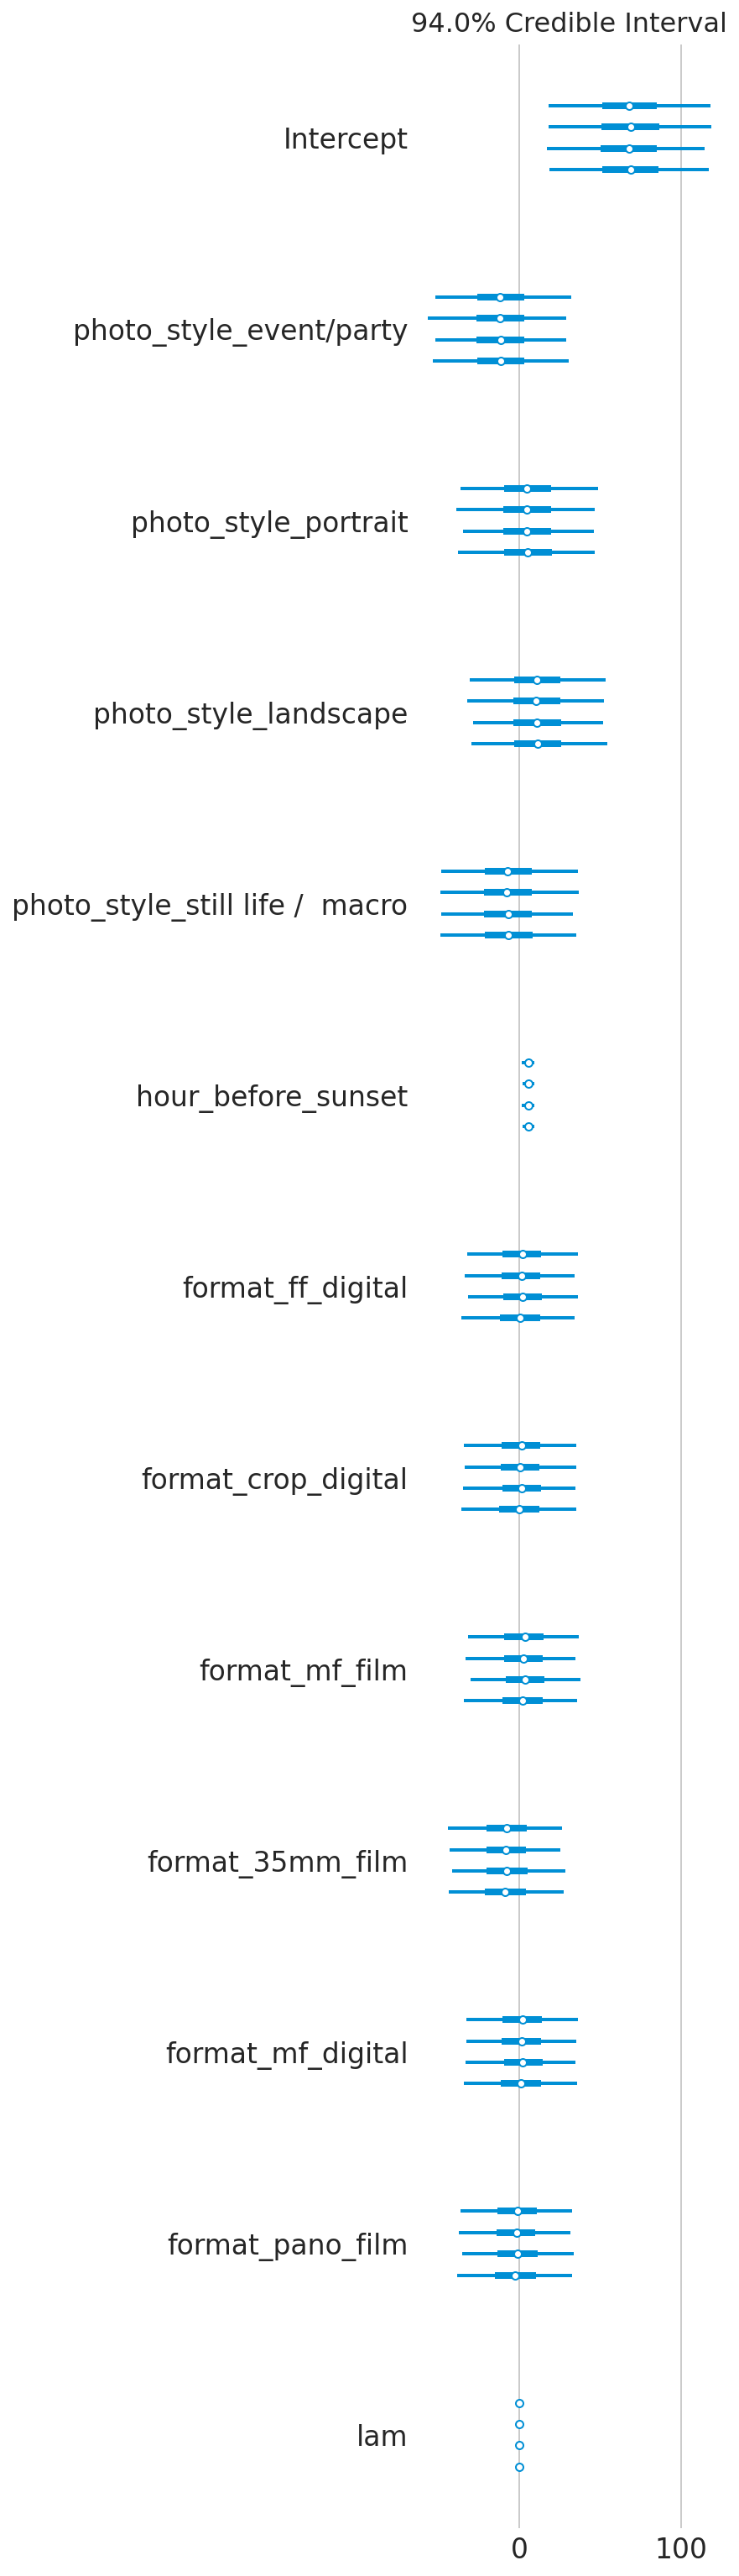

In [26]:
# check on convergence and "significance" (highest posteriod density / credible interval)

_ = pm.autocorrplot(trace)
plt.show()

plt.figure(figsize=(12,8))
_ = pm.forestplot(trace)
plt.show()

- this is to say we can't learn very much ;)  
- just take some photos and don't worry about your gear?  

## Treat this as a classification problem

In [27]:
ratings_clf = ratings.loc[((ratings.rating >= 2) | (ratings.rating == 0))]

ratings_clf

photo_description        date   time   camera  35equiv_focal film_digital      format  \
0                            man with a megaphone  2011/11/09  13:41       5d             85      digital  ff_digital   
1                          police officer praying  2011/11/09  15:47       5d             85      digital  ff_digital   
2                 man playing guitar with streaks  2012/01/22  21:54       5d             85      digital  ff_digital   
3    man holding a football with upside down flag  2012/03/04  10:56       5d             85      digital  ff_digital   
4            football player with horizontal ball  2012/09/23  17:47       5d             85      digital  ff_digital   
..                                            ...         ...    ...      ...            ...          ...         ...   
242            24000: plant at huntington library  2019/12/28  13:18      m10             50      digital  ff_digital   
243                        24217: american bag co  2020/03/04  16:12  gfx_100             40      digital  mf_digital   
244      24400: self portrait wearing ramie shirt  2020/04/07  16:55  gfx_100             50      digital  mf_digital   
245                     24600: TA w/ studio flash  2020/04/07  14:52      m10             50      digital  ff_digital   
246          24800: TA weird lean studio portrait  2020/04/26  15:17  gfx_100             50      digital  mf_digital   

    shooting_circumstance filmstock      lighting  minutes_before_sunset  photo_style  rating  score note            taken_at  month  \
0               newspaper       NaN      non-soft             203.750000  event/party     2.0     80  NaN 2011-11-09 13:41:00     11   
1               newspaper       NaN      non-soft              77.750000  event/party     2.0     88  NaN 2011-11-09 15:47:00     11   
2               newspaper       NaN    artificial            -272.750000  event/party     2.0     88  NaN 2012-01-22 21:54:00      1   
3               newspaper       NaN      non-soft             430.366667     portrait     2.0     88  NaN 2012-03-04 10:56:00      3   
4               newspaper       NaN  studio flash              79.383333     portrait     2.0     81  NaN 2012-09-23 17:47:00      9   
..                    ...       ...           ...                    ...          ...     ...    ...  ...                 ...    ...   
242              vacation       NaN      non-soft            1440.000000    landscape     0.0     58  NaN 2019-12-28 13:18:00     12   
243            after_work       NaN          soft            1440.000000    landscape     0.0     55  NaN 2020-03-04 16:12:00      3   
244           intentional       NaN  studio flash                    NaN     portrait     0.0     50  NaN 2020-04-07 16:55:00      4   
245           intentional       NaN  studio flash                    NaN     portrait     0.0     57  NaN 2020-04-07 14:52:00      4   
246           intentional       NaN  studio flash                    NaN     portrait     0.0     57  NaN 2020-04-26 15:17:00      4   

     year  ord_season     date_ord                    sunset  hour_before_sunset  fl  
0    2011           4   348.122917 2011-11-09 17:04:45-08:00               False  85  
1    2011           4   348.210417 2011-11-09 17:04:45-08:00               False  85  
2    2012           1   422.465278 2012-01-22 17:21:15-08:00               False  85  
3    2012           2   464.008333 2012-03-04 18:06:22-08:00               False  85  
4    2012           4   667.293750 2012-09-23 19:06:23-07:00               False  85  
..    ...         ...          ...                       ...                 ...  ..  
242  2019           1  3319.106944 2020-04-07 19:38:12-07:00               False  50  
243  2020           2  3386.227778 2020-04-26 19:55:40-07:00               False  40  
244  2020           2  3420.257639                       NaT               False  50  
245  2020           2  3420.172222                       NaT               F

In [42]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

ratings_clf['fl'] = ratings_clf['35equiv_focal'].copy()
ratings_clf['good_photo'] = (ratings.rating >= 2).astype('int')

# normalize cts vars: date ord and focal length
ratings_clf['date_norm'] = (ratings_clf['date_ord'] - ratings_clf['date_ord'].mean()) / ratings_clf['date_ord'].std()
ratings_clf['fl_norm'] = (ratings_clf['fl'] - ratings_clf['fl'].mean()) / ratings_clf['fl'].std()

mod = smf.logit(
    formula='good_photo ~ photo_style + lighting + hour_before_sunset + shooting_circumstance + format + film_digital + date_norm + fl_norm', 
    data=ratings_clf,
)
res = mod.fit(
    maxiter=1000,
    method='bfgs',
)
# trouble converging, try adding very small amount of reg
# res = mod.fit_regularized(
#     method='l1',
#     alpha=.0001, 
#     maxiter=1000,
#     qc_verbose=True,
# )
res.summary()

Optimization terminated successfully.
         Current function value: 0.550341
         Iterations: 148
         Function evaluations: 149
         Gradient evaluations: 149


/home/jan/miniconda3/envs/jan/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/jan/miniconda3/envs/jan/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/jan/miniconda3/envs/jan/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             good_photo   No. Observations:                  236
Model:                          Logit   Df Residuals:                      214
Method:                           MLE   Df Model:                           21
Date:                Sat, 09 May 2020   Pseudo R-squ.:                  0.2000
Time:                        23:50:21   Log-Likelihood:                -129.88
converged:                       True   LL-Null:                       -162.36
Covariance Type:            nonrobust   LLR p-value:                 2.206e-06
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -2.5929      1.313     -1.975      0.048      -5.167      -0.019
photo_style[T.landscape]                 2.3489      0.950      2.471      0.013       0.486       4.212
photo_style[T.portrait]                  0.9826      0.917      1.072      0.284      -0.814       2.779
photo_style[T.still life /  macro]     -14.8961    683.563     -0.022      0.983   -1354.654    1324.862
lighting[T.golden hour]                 -0.1169      0.842     -0.139      0.890      -1.767       1.533
lighting[T.non-soft]                    -0.0801      0.739     -0.108      0.914      -1.528       1.367
lighting[T.on-camera flash]              2.0813      1.120      1.858      0.063      -0.115       4.277
lighting[T.soft]                        -0.1018      0.756     -0.135      0.893      -1.584       1.381
lighting[T.studio flash]                -0.6877      1.124     -0.612      0.541      -2.891       1.516
hour_before_sunset[T.True]               1.7659      0.703      2.513      0.012       0.389       3.143
shooting_circumstance[T.incidental]     -0.8761      0.604     -1.452      0.147      -2.059       0.307
shooting_circumstance[T.intentional]    -0.2170      0.596     -0.364      0.716      -1.386       0.952
shooting_circumstance[T.newspaper]       1.4091      1.198      1.176      0.240      -0.939       3.758
shooting_circumstance[T.vacation]       -0.7598      0.558     -1.362      0.173      -1.853       0.334
format[T.crop_digital]                  -0.3066   1.03e+08  -2.97e-09      1.000   -2.02e+08    2.02e+08
format[T.ff_digital]                     0.3483   1.03e+08   3.37e-09      1.000   -2.02e+08    2.02e+08
format[T.mf_digital]                     0.7605   1.03e+08   7.37e-09      1.000   -2.02e+08    2.02e+08
format[T.mf_film]                        1.9733      0.881      2.240      0.025       0.247       3.700
format[T.pano_film]                      2.1728      1.435      1.514      0.130      -0.640       4.985
film_digital[T.c41_film]                -0.8542      0.840     -1.018      0.309      -2.500       0.791
film_digital[T.digital]                  0.8022   1.03e+08   7.77e-09      1.000   -2.02e+08    2.02e+08
date_norm                                0.4187      0.270      1.552      0.121      -0.110       0.947
fl_norm                                  0.1035      0.250      0.414      0.679      -0.386       0.593
========================================================================================================
"""

interpretation - more likely to be a successful image (note: _not_ to be rated higher! there's a distinction between "good on average" and "occasionally really good"):
- photos that are landscapes  
- (ish, trending) that have on-camera flash  
- shot in the hour before sunset ("golden hour")
- shot on medium format film (note confound of shooting less on MF film because it's expensive)

_approximately similar result from regression approach_


## Try Causal Approach (DoWhy)

As with the rest of this analysis, we'll be a bit silly :)  
I wanted to try to eliminate some of the bias inherent in an observational study. (Realisitcally, I am not going to destroy my average photo quality by running an experiment. And it would take a whole lot of time!)  
Of course, we're pretty limited in sample size, and we expect that bias is pretty severe and true causal effects are small - a worst case!   
Let's do it anyway ;)

__one major confound I haven't attempted to control for: "expected photo quality" - bring out "nicer" cameras for more special subjects.__

__start w/ simple binary treatment: the age-old film vs. digital__

### Causal Q1: Film vs. digital

In [455]:
# start w/ basic causal graph
# I would like to generate a full graph eventually (and have drawn one up), but let's start basic.
# say photo quality determined by treatment, confounded by date and circumstance (e.g. landscape, portrait)

from dowhy import CausalModel

COMMON_CAUSES = [
    'date_ord',
    'shooting_circumstance',
]
OUTCOME = 'score'
TREATMENT = 'is_film'

ratings['is_film'] = ratings.film_digital != 'digital'

# also exclude p&s since they score low (confounded)
ratings_ = ratings.copy(deep=True).loc[ratings.camera_p_n_s == 0, [TREATMENT] + [OUTCOME] + COMMON_CAUSES]

# normalize numeric feature(s)
ratings_.date_ord = (ratings_.date_ord - ratings_.date_ord.mean()) / ratings_.date_ord.std()

model = CausalModel(
        data = ratings_,
        treatment=TREATMENT,
        outcome=OUTCOME,
        common_causes=COMMON_CAUSES,
)

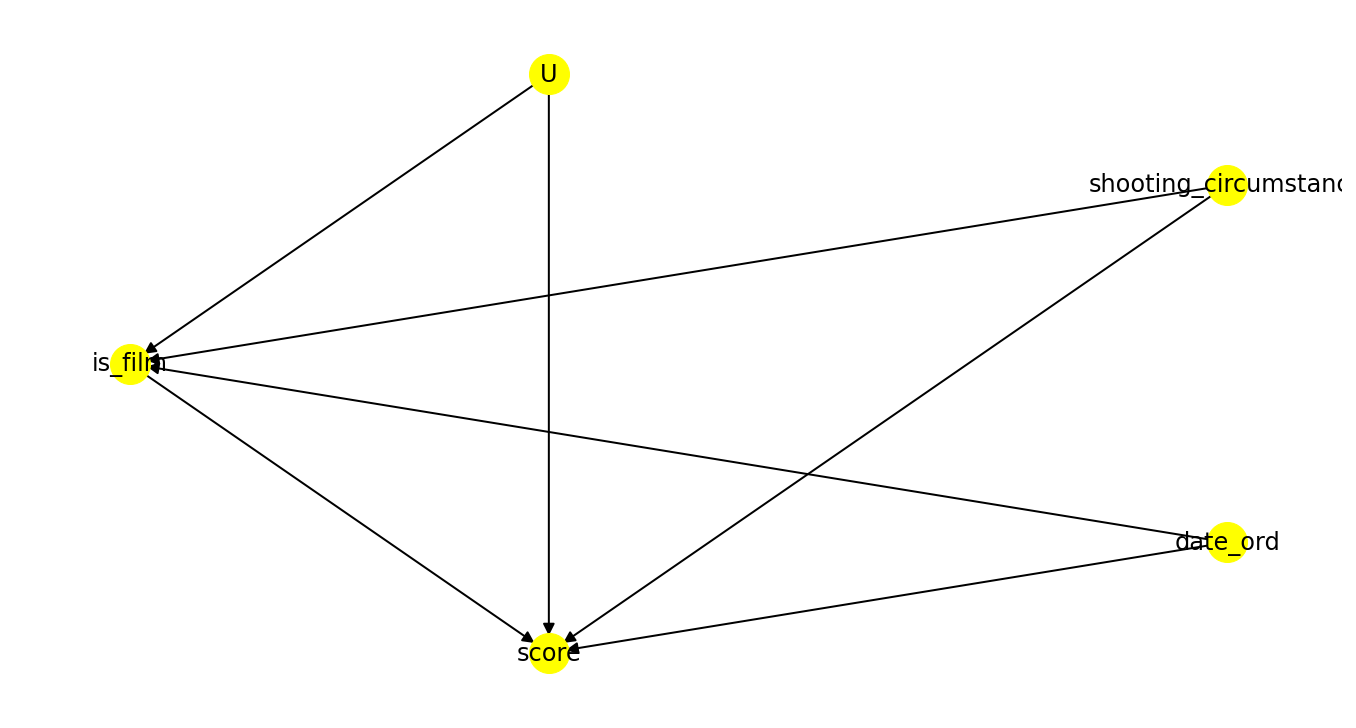

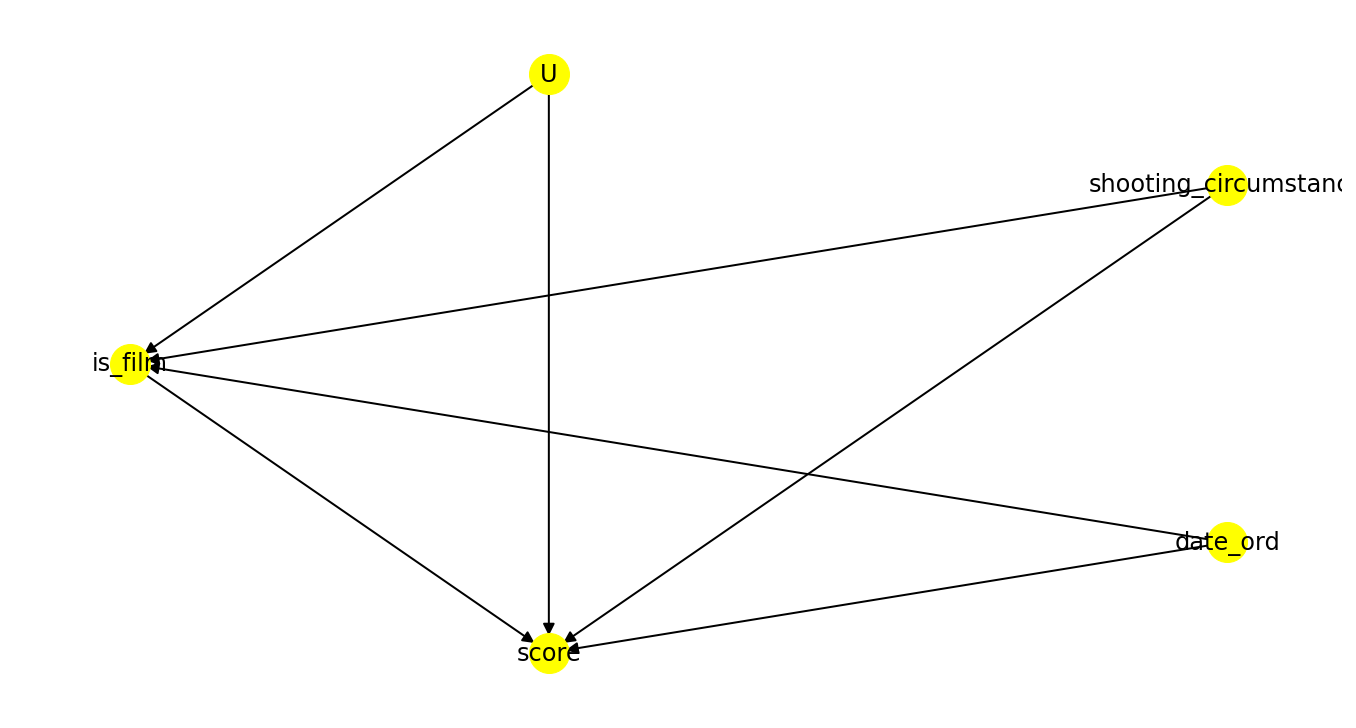

In [456]:
_ = model.view_model()
from IPython.display import Image, display

# II. Identify causal effect and return target estimands
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)  # observational data, not finding all confounders

In [459]:
# Let's start w/ using linear regression as method, since it makes fewer assumptions
#
# btw these are our options using builtins:
# Propensity Score Matching: “backdoor.propensity_score_matching”
# Propensity Score Stratification: “backdoor.propensity_score_stratification”
# Propensity Score-based Inverse Weighting: “backdoor.propensity_score_weighting”
# Linear Regression: “backdoor.linear_regression”
# Generalized Linear Models (e.g., logistic regression): “backdoor.generalized_linear_model”
# Instrumental Variables: “iv.instrumental_variable”
# Regression Discontinuity: “iv.regression_discontinuity”
#
# and also have access to EconML and CausalML methods - e.g. double ML, doubly robust ML, metalearners, etc. 
# (but I am not very optimistic about those very complex techniques on this small + messy dataset)

CAUSAL_METHODS = [
    'backdoor.linear_regression',  # basic linear regression, in some sense less likely to screw up than IPS, which can have outlier/variance issues
    'backdoor.propensity_score_weighting',  # control for selection bias with basic inverse propensity score
    #'backdoor.propensity_score_stratification'  # similar to IPS but with reduced variance issues since stratif is less powerful
]

REFUTATION_STRATS = [
    #"add_unobserved_common_cause",
    "placebo_treatment_refuter",
    "data_subset_refuter",
]

import logging
logger = logging.getLogger("dowhy").setLevel(logging.WARNING)
# only log really bad events
# also ignore that DoWhy feeds 1-column df for y instead of 1d array (series)
from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)


for causal_method in CAUSAL_METHODS:
    # III. Estimate the target estimand using a statistical method.
    estimate = model.estimate_effect(
        identified_estimand,
        method_name=causal_method,
    )
    print('')
    print('')
    print(causal_method)
    print(estimate)
    
    # IV. Refute the obtained estimate using multiple robustness checks.
    for refuter in REFUTATION_STRATS:
        refute_results = model.refute_estimate(
            identified_estimand, 
            estimate,                
            method_name=refuter,
            random_seed=1234,
            silent=True,
        )
        #print('')
        print(refute_results)



backdoor.linear_regression
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: score~is_film+shooting_circumstance+date_ord
Target units: ate

## Estimate
Mean value: 2.4474227815113068

Refute: Use a Placebo Treatment
Estimated effect:2.4474227815113068
New effect:0.1307811137254751
p value:0.45

Refute: Use a subset of data
Estimated effect:2.4474227815113068
New effect:2.4477062589459377
p value:0.5



backdoor.propensity_score_weighting
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: score~is_film+shooting_circumstance+date_ord
Target units: ate

## Estimate
Mean value: -11.45480583241352

Refute: Use a Placebo Treatment
Estimated effect:-11.45480583241352
New effect:0.15454757225775295
p value:0.45

Refute: Use a subset of data
Estimated effect:-11.45480583241352
New effect:-12.016900223770842
p value:0.43999999999999995



__note that our linear & propensity weighting scores are in opposite directions!__

__TODO: further digging__

### Causal Q2: Use DoSampler to investigate effect of resolution

Above used pretty standard econometric approach.  
Let's try the new/experimental DoSampler to investigate continuous variables. I'm particularly interested in the effect of resolution and focal length.

btw, it seems the linear regression approach works w/o DoSampler for continuous treatments


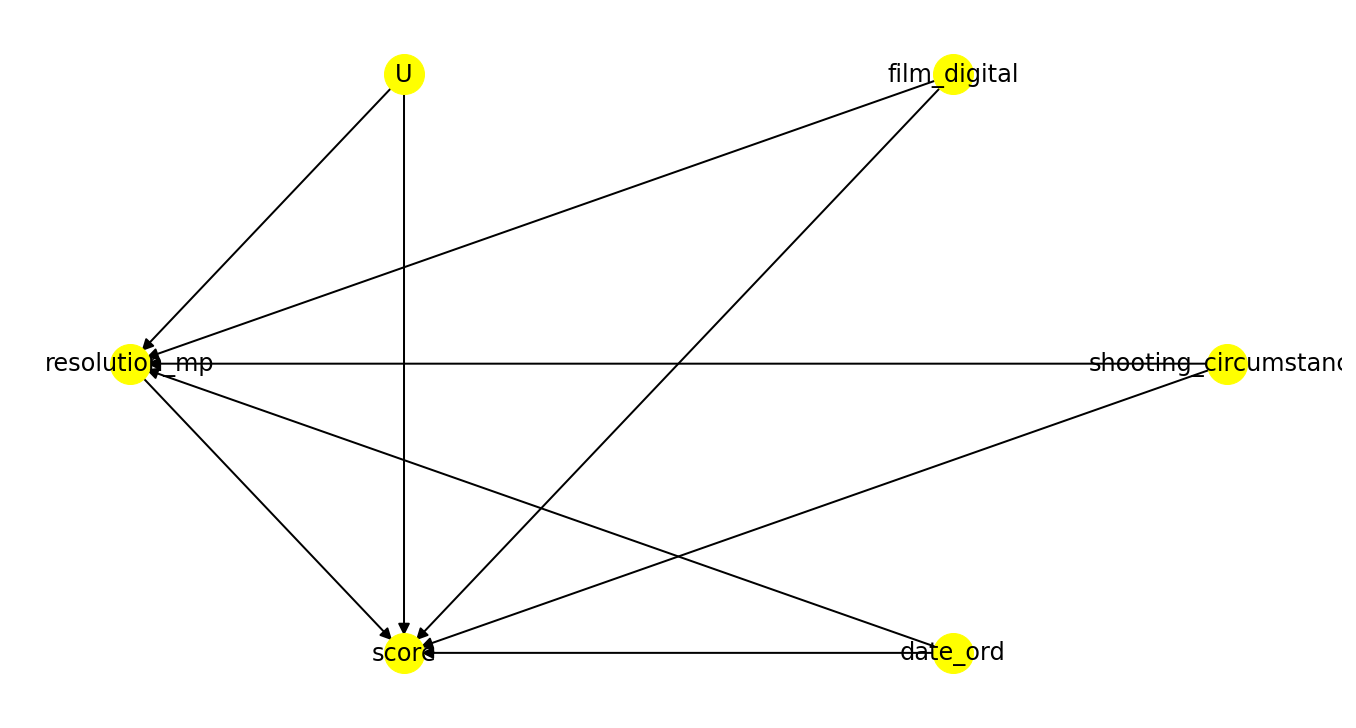

In [101]:
# start w/ basic causal graph
# I would like to generate a full graph eventually (and have drawn one up), but let's start basic.
# say photo quality determined by treatment, confounded by date and circumstance (e.g. landscape, portrait)

from dowhy import CausalModel

COMMON_CAUSES = [
    'date_ord',
    'shooting_circumstance',
    'film_digital',
]
OUTCOME = 'score'
TREATMENT = 'resolution_mp'#'fl'

#ratings['is_film'] = ratings.film_digital != 'digital'

# also exclude p&s since they score low (confounded)
ratings_ = (
    ratings.copy(deep=True)
        .loc[ratings.camera_p_n_s == 0, [TREATMENT] + [OUTCOME] + COMMON_CAUSES]
)

# normalize numeric feature(s)
ratings_.date_ord = (ratings_.date_ord - ratings_.date_ord.mean()) / ratings_.date_ord.std()

model = CausalModel(
        data = ratings_,
        treatment=TREATMENT,
        outcome=OUTCOME,
        common_causes=COMMON_CAUSES,
)

_ = model.view_model()

# II. Identify causal effect and return target estimands
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

In [102]:
ratings_

resolution_mp  score  date_ord shooting_circumstance film_digital
0             12.0     80 -2.294592             newspaper      digital
1             12.0     88 -2.294486             newspaper      digital
2             12.0     88 -2.204039             newspaper      digital
3             12.0     88 -2.153438             newspaper      digital
4             12.0     81 -1.905825             newspaper      digital
..             ...    ...       ...                   ...          ...
242           24.0     58  1.324227              vacation      digital
243          100.0     55  1.405984            after_work      digital
244          100.0     50  1.447434           intentional      digital
245           24.0     57  1.447330           intentional      digital
246          100.0     57  1.470495           intentional      digital

[219 rows x 5 columns]

WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


resolution_mp  score  date_ord shooting_circumstance film_digital  propensity_score     weight
0           22.0     93 -0.495451            incidental      digital          0.011491  87.020998
1           40.0     53  0.259912              vacation     c41_film          0.027400  36.495846
2           42.0     84  0.040767           intentional      digital          0.031827  31.420165
3           10.0     85  0.994348            after_work     c41_film          0.016517  60.543687
4           50.0     81  0.372962            after_work      digital          0.024232  41.267943

<AxesSubplot:xlabel='resolution_mp', ylabel='score'>

<AxesSubplot:xlabel='resolution_mp', ylabel='score'>

Text(0.5, 1.0, 'Resolution -> Photo Goodness? Compare causal & non-causal estimates')

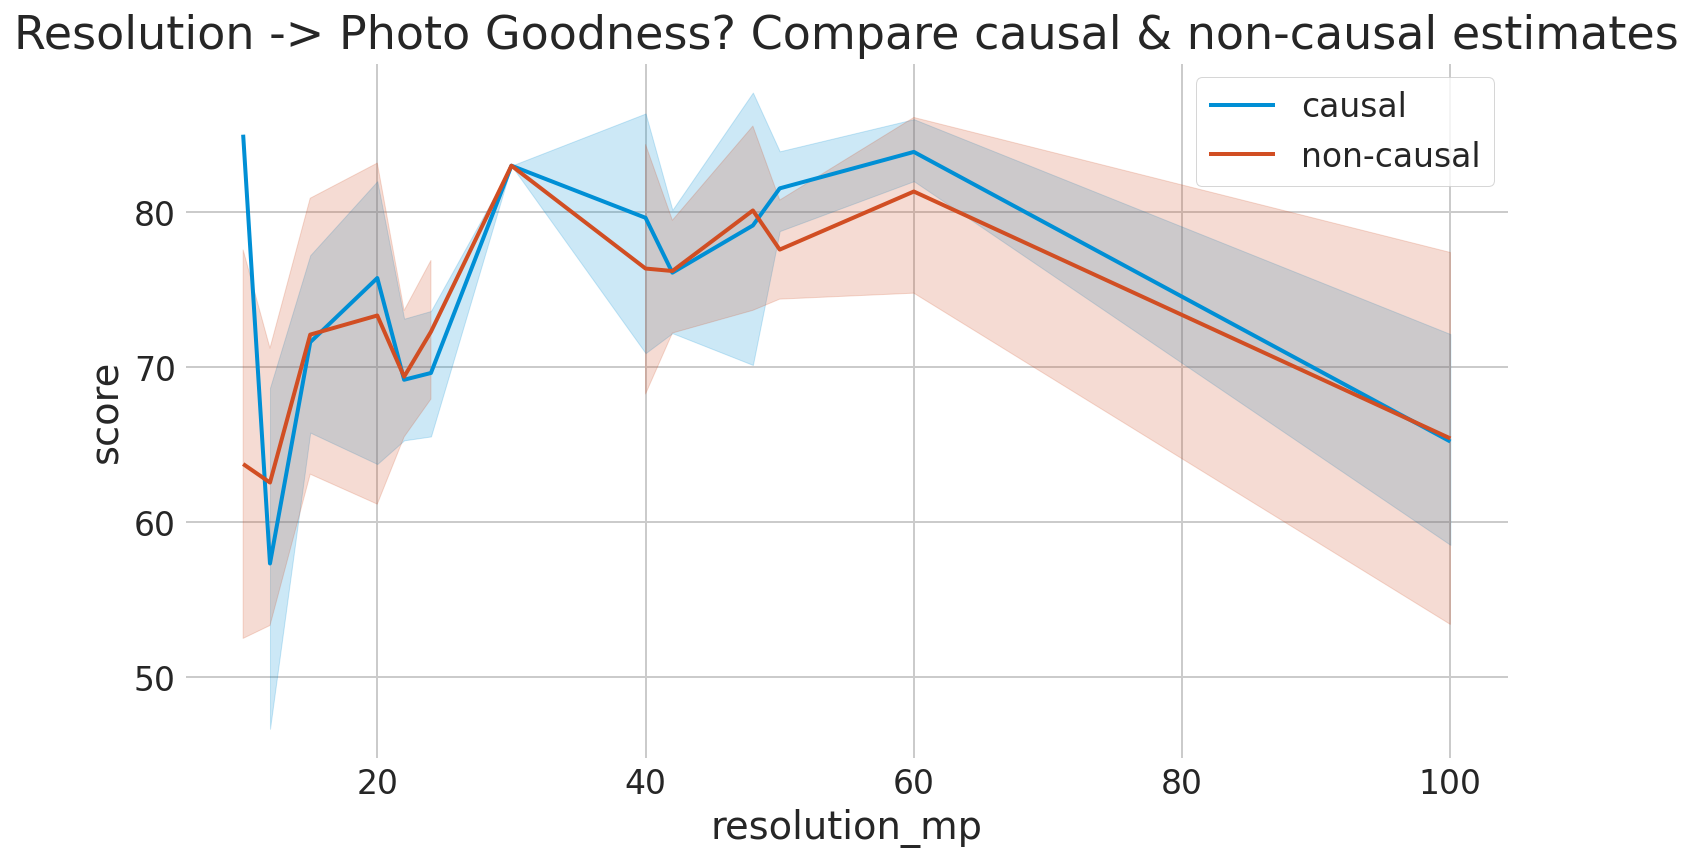

In [103]:
import dowhy as dw
from dowhy.do_samplers.weighting_sampler import WeightingSampler
from dowhy.do_samplers.mcmc_sampler import McmcSampler
from dowhy.do_samplers.kernel_density_sampler import KernelDensitySampler

VAR_TYPES = {
    TREATMENT: 'c',
    OUTCOME: 'c',
    'date_ord': 'c',  # continuous
    'shooting_circumstance': 'd', # discrete
    'film_digital': 'd',
}

sampler = WeightingSampler(
    ratings_,
    causal_model=model,
    keep_original_treatment=True,
    variable_types=VAR_TYPES,
    #proceed_when_unidentifiable=True,  # observational data
    num_cores=1,
)

interventional_df = sampler.do_sample(None)
interventional_df.head()

# causal
sns.lineplot(
    data=interventional_df, 
    x=TREATMENT,
    y=OUTCOME,
)
# non-causal obs baseline
sns.lineplot(
    data=ratings_, 
    x=TREATMENT,
    y=OUTCOME,
)
plt.legend(['causal', 'non-causal'])
plt.title('Resolution -> Photo Goodness? Compare causal & non-causal estimates')

#### TODO more

## Try using metadata instead of manual tags

Since this is automatic, sample will increase dramatically.
But we'll miss out on lots of important details.

I used the ListView plugin for Lightroom for this: https://www.photographers-toolbox.com/products/jbeardsworth/listview/  

In [92]:
ratings_md = pd.read_csv('./photos_dataset_through_2020_v2.csv')  # md = from METADATA

ratings_md.columns = [c.lower().replace(' ', '_') for c in ratings_md.columns]

# fix colnames
ratings_md = ratings_md.rename(columns={'size': 'size_mb', 'model': 'camera', 'date_time': 'taken_at'})  # shadows df.size 
                               
# munge
ratings_md.rating = ratings_md.rating.fillna(0)
ratings_md.taken_at = pd.to_datetime(ratings_md.taken_at)
ratings_md.camera = ratings_md.camera.str.lower()#.astype('category') 
ratings_md.focal_length = ratings_md.focal_length.str.replace(r'[^0-9.]', '', regex=True).astype('float')
ratings_md.iso = ratings_md.iso.str.replace('\D', '', regex=True).astype('float')
# probably care about log iso, since it grows exponentially
ratings_md['ln_iso'] = np.log(ratings_md.iso)
ratings_md[['width_px', '_', 'height_px']] = ratings_md.cropped.str.split(' ', expand=True)
ratings_md.width_px = ratings_md.width_px.astype('float')
ratings_md.height_px = ratings_md.height_px.astype('float')
ratings_md['resolution_mp'] = ratings_md.width_px * ratings_md.height_px / 1_000_000
ratings_md['rated_1_plus'] = ratings_md.rating.str.startswith('*').astype('float').fillna(0)
ratings_md['aspect_ratio'] = ratings_md.width_px / ratings_md.height_px

def try_float(x):
    try:
        return float(x)
    except:
        return np.nan

ratings_md.size_mb = ratings_md.size_mb.apply(lambda x: try_float(x)).astype('float')

ratings_md = ratings_md.drop(['_', 'unnamed:_10'], axis=1)  # columns created as side effect of width and height extraction

ratings_md.info()
ratings_md.sample(20,random_state=123)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28778 entries, 0 to 28777
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   file_name      28778 non-null  object        
 1   taken_at       26731 non-null  datetime64[ns]
 2   camera         28051 non-null  object        
 3   focal_length   25613 non-null  float64       
 4   cropped        28778 non-null  object        
 5   exposure       26440 non-null  object        
 6   size_mb        0 non-null      float64       
 7   rating         28778 non-null  object        
 8   flag           28778 non-null  int64         
 9   iso            26442 non-null  float64       
 10  ln_iso         26442 non-null  float64       
 11  width_px       28778 non-null  float64       
 12  height_px      28778 non-null  float64       
 13  resolution_mp  28778 non-null  float64       
 14  rated_1_plus   28778 non-null  float64       
 15  aspect_ratio   2877

file_name            taken_at                       camera  focal_length       cropped               exposure  \
16208         _DSF4772-HDR.dng 2017-09-17 23:04:47                       x-pro2         23.00   3973 x 5960   1/340 sec at ƒ / 5.6   
23560  IMG_20191022_160957.jpg 2019-10-22 16:09:57                   pixel 3 xl          4.44   3024 x 4032   1/125 sec at ƒ / 1.8   
371               IMG_4845.CR2 2010-06-05 10:14:24  canon eos digital rebel xti         70.00   3888 x 2592  1/2500 sec at ƒ / 2.8   
4715              _J2A2623.CR2 2012-12-03 02:16:57        canon eos 5d mark iii         85.00   5760 x 3840   1/125 sec at ƒ / 5.0   
28274             _DSF0797.RAF 2020-10-10 17:48:53                      gfx 100         50.00  11648 x 8736    1/50 sec at ƒ / 8.0   
21883             LM103837.DNG 2019-05-04 15:14:24                    leica m10         50.00   5976 x 3984   1/350 sec at ƒ / 5.6   
5218              _J2A3187.CR2 2013-02-09 15:16:58        canon eos 5d mark iii         47.00   5760 x 3840    1/30 sec at ƒ / 6.3   
23965             _R000383.DNG 2019-10-26 03:16:42                 ricoh gr iii         18.30   6000 x 4000    1/40 sec at ƒ / 2.8   
190               IMG_4656.CR2 2010-06-01 12:17:44  canon eos digital rebel xti        105.00   3888 x 2592    1/50 sec at ƒ / 2.8   
1539              _MG_9454.CR2 2011-10-12 15:27:21                 canon eos 5d         50.00   2912 x 4368    1/80 sec at ƒ / 1.8   
28544             _DSF1019.RAF 2020-10-21 16:53:26                      gfx 100         50.00  8736 x 11648    1/100 sec at ƒ / 11   
19407      20180704_220236.jpg 2018-07-04 22:02:36                     sm-g955u          4.25   4032 x 1960    1/60 sec at ƒ / 1.7   
6306              DSCF1493.RAF 2013-07-20 00:51:45                 finepix x100         23.00   4288 x 2848    1/60 sec at ƒ / 2.8   
12538             _DSC2070.ARW 2016-09-04 17:58:47                    ilce-7rm2         35.00   7952 x 5304   1/100 sec at ƒ / 5.6   
1004              _MG_0986.CR2 2011-06-14 13:21:57                 canon eos 5d         85.00   2719 x 4078  1/2000 sec at ƒ / 2.0   
534               IMG_5127.CR2 2010-07-31 16:39:35  canon eos digital rebel xti         30.00   3888 x 2592    1/40 sec at ƒ / 4.0   
20484             LM102791.DNG 2018-09-05 09:34:02                    leica m10         50.00   5976 x 3984  1/4000 sec at ƒ / 2.0   
2913              DSCF0055.JPG 2012-05-01 22:11:31                 finepix x100         23.00   2848 x 4288    1/50 sec at ƒ / 2.0   
20986             LM103209.DNG 2018-11-24 12:06:49                    leica m10         50.00   3984 x 5976   1/180 sec at ƒ / 4.0   
24269             LM104596.DNG 2019-10-30 03:53:37                    leica m10         50.00   3984 x 5976   1/125 sec at ƒ / 4.0   

       size_mb rating  flag     iso    ln_iso  width_px  height_px  resolution_mp  rated_1_plus  aspect_ratio  
16208      NaN      0     1   200.0  5.298317    3973.0     5960.0      23.679080           0.0      0.666611  
23560      NaN      0     0  1319.0  7.184629    3024.0     4032.0      12.192768           0.0      0.750000  
371        NaN      0     0   100.0  4.605170    3888.0     2592.0      10.077696           0.0      1.500000  
4715       NaN      0     0   400.0  5.991465    5760.0     3840.0      22.118400           0.0      1.500000  
28274      NaN      0     0   500.0  6.214608   11648.0     8736.0     101.756928           0.0      1.333333  
21883      NaN      0     0   200.0  5.298317    5976.0     3984.0      23.808384           0.0      1.500000  
5218       NaN      0     0   100.0  4.605170    5760.0     3840.0      22.118400           0.0      1.500000  
23965      NaN      0     0   400.0  5.991465    6000.0     4000.0      24.000000           0.0      1.500000  
190        NaN      0     0   800.0  6.684612    3888.0     2592.0      10.077696           0.0      1.500000  
1539       NaN      0     1   100.0  4.605170    2912.0     4368.0      12.719616     

In [93]:
# add dt features

ratings_md['month'] = ratings_md['taken_at'].dt.month
ratings_md['year'] = ratings_md['taken_at'].dt.year

seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
month_to_season = dict(zip(range(1,13), seasons))
ratings_md['ord_season'] = ratings_md['taken_at'].dt.month.map(month_to_season) 

ratings_md['date_ord'] = pd.to_timedelta(ratings_md.taken_at - ratings_md.taken_at.min()) / pd.to_timedelta('1d')
print('min date =', ratings_md.taken_at.min() )
print('max date =', ratings_md.taken_at.max() )

min date = 2010-03-09 11:25:38
max date = 2020-12-26 13:28:16


In [94]:
# fix camera phone FL
ratings_md.loc[ratings_md.camera.isin(['pixel 3 xl', 'sm-g955u']), 'focal_length'] = 28

In [95]:
ratings_md.camera.value_counts()

canon eos 5d mark iii          4920
ilce-7rm2                      4737
leica m10                      3376
gfx 50s                        3219
finepix x100                   2280
canon eos 5d                   2111
gfx 100                        1810
ez controller                  1214
pixel 3 xl                     1162
canon eos digital rebel xti     980
ricoh gr iii                    776
x-t4                            502
sm-g955u                        233
gr                              162
perfectionv800                  155
qss-32_33                       151
x-pro2                           95
perfection v600                  58
canon eos-1d mark ii             44
canon eos digital rebel xsi      34
iphone                           15
canon eos 5d mark ii             11
leica sl                          5
iphone 4                          1
Name: camera, dtype: int64

In [96]:
# exclude very rare cameras that I barely used (e.g. borrowed)

CAMERAS_INCLUDE = [
    'canon eos 5d mark iii',       
    'ilce-7rm2',            
    'leica m10',    
    'gfx 50s' ,
    'finepix x100' ,
    'canon eos 5d',
    'gfx 100',                        
    'ez controller' ,
    'pixel 3 xl' 
    'canon eos digital rebel xti' ,
    'ricoh gr iii',
    'x-t4'   ,
    'sm-g955u'  ,
    'gr'   ,
    'perfectionv800',
    'qss-32_33',
]

ratings_md = ratings_md.loc[ratings_md.camera.isin(CAMERAS_INCLUDE)]

In [97]:
CAMERA_ALIASES = {
    'ilce-7rm2': 'a7r_ii',
    'ez controller': 'noritsu_scanner',
    'qss-32_33': 'noritsu_scanner',
    'sm-g955u': 'samsung_s7_edge',  # s7 edge or s8+, not sure which
    'gr': 'ricoh gr',
}

ratings_md.camera = ratings_md.camera.replace(to_replace=CAMERA_ALIASES)

ratings_md['equiv_fl'] = ratings_md.focal_length.copy()

MFD_CAMERAS = ['gfx 50s', 'gfx 100']  # 0.80x crop factor
ratings_md.loc[ratings_md.camera.isin(MFD_CAMERAS), 'equiv_fl'] = 0.80 * ratings_md.equiv_fl

APSC_CAMERAS = [
    'finepix x100',
    'ricoh gr iii',
    'x-t4',
    'canon eos digital rebel xsi',
]

ratings_md.loc[ratings_md.camera.isin(APSC_CAMERAS), 'equiv_fl'] = 1.50 * ratings_md.equiv_fl  # actually 1.6x for canon, but close enough


In [98]:
# also tag film

fil_scanner = (ratings_md.camera.isin(['noritsu_scanner', 'perfectionv800', 'perfection v600', ]))
# not perfect b/c I do very occasionally shoot macro/product
fil_sony_macro = ((ratings_md.camera == 'a7r_ii') & (ratings_md.focal_length == 90.0))
fil_gf_macro = (
    (ratings_md.camera.isin(['gfx 50s', 'gfx 100'])) & (ratings_md.focal_length == 120)
)  # w/ extension shows up as 425mm, 444mm

ratings_md['is_film'] = (fil_scanner | fil_sony_macro | fil_gf_macro)

ratings_md.loc[(fil_sony_macro | fil_gf_macro), 'equiv_fl'] = np.nan  # actual focal length is taking lens, not scanning lens ;)

# also clip FL at 200mm, some weird data issues
ratings_md.equiv_fl = ratings_md.equiv_fl.clip(upper=200)

ratings_md.sample(10, random_state=2001)


file_name            taken_at        camera  focal_length      cropped               exposure  size_mb rating  flag     iso  \
21213  LM103371-HDR.dng 2019-01-12 15:36:08     leica m10          50.0  3956 x 5935  1/4000 sec at ƒ / 4.8      NaN      0     1   200.0   
12204      _DSC1747.ARW 2016-08-15 12:16:39        a7r_ii          28.0  7952 x 5304    1/60 sec at ƒ / 5.6      NaN      0     0   100.0   
19013      _DSF6696.RAF 2018-06-02 15:27:45       gfx 50s          64.0  8256 x 6192    1/160 sec at ƒ / 10      NaN      0     0   100.0   
23952      LM104392.DNG 2019-10-26 03:04:18     leica m10          50.0  5976 x 3984   1/180 sec at ƒ / 2.4      NaN      0     0   200.0   
6358       DSCF1518.RAF 2013-07-27 23:13:39  finepix x100          23.0  2848 x 4288    1/60 sec at ƒ / 2.8      NaN      0     0  1600.0   
24361      LM104661.DNG 2019-10-31 06:49:13     leica m10          50.0  5976 x 3984  1/1000 sec at ƒ / 4.0      NaN      0     0   250.0   
18090      _DSF6232.RAF 2018-03-04 12:42:51       gfx 50s         120.0  8256 x 6192   1/125 sec at ƒ / 8.0      NaN      0     0   400.0   
17180      _DSF5443.RAF 2017-11-08 15:55:03       gfx 50s          41.1  8256 x 6192   1/160 sec at ƒ / 9.0      NaN      0     0   400.0   
18153      _DSF6295.RAF 2018-03-04 13:35:12       gfx 50s          63.0  8256 x 6192   1/160 sec at ƒ / 8.0      NaN      0     0   250.0   
21064      LM103279.DNG 2018-11-24 13:58:24     leica m10          50.0  5976 x 3984     1/6 sec at ƒ / 2.4      NaN      0     0  1600.0   

         ln_iso  width_px  height_px  resolution_mp  rated_1_plus  aspect_ratio  month    year  ord_season     date_ord  equiv_fl  is_film  
21213  5.298317    3956.0     5935.0      23.478860           0.0      0.666554    1.0  2019.0         1.0  3231.173958     50.00    False  
12204  4.605170    7952.0     5304.0      42.177408           0.0      1.499246    8.0  2016.0         3.0  2351.035428     28.00    False  
19013  4.605170    8256.0     6192.0      51.121152           0.0      1.333333    6.0  2018.0         3.0  3007.168137     51.20    False  
23952  5.298317    5976.0     3984.0      23.808384           0.0      1.500000   10.0  2019.0         4.0  3517.651852     50.00    False  
6358   7.377759    2848.0     4288.0      12.212224           0.0      0.664179    7.0  2013.0         3.0  1236.491678     34.50    False  
24361  5.521461    5976.0     3984.0      23.808384           0.0      1.500000   10.0  2019.0         4.0  3522.808044     50.00    False  
18090  5.991465    8256.0     6192.0      51.121152           0.0      1.333333    3.0  2018.0         2.0  2917.053623       NaN     True  
17180  5.991465    8256.0     6192.0      51.121152           0.0      1.333333   11.0  2017.0         4.0  2801.187095     32.88    False  
18153  5.521461    8256.0     6192.0      51.121152           0.0      1.333333    3.0  2018.0         2.0  2917.089977     50.40    False  
21064  7.377759    5976.0     3984.0      23.808384           0.0      1.500000   11.0  2018.0         4.0  3182.106088     50.00    False

In [99]:
def try_get_list_idx(lst, idx):
    try:
        return lst[idx]
    except TypeError:
        return np.nan

#ratings_md.sample(10, random_state=321).exposure.str.split(' ').apply(lambda x: try_get_list_idx(x, -1))

ratings_md['shutter'] = ratings_md.exposure.str.split(' ').apply(lambda x: try_get_list_idx(x, 0))
ratings_md['aperture'] = ratings_md.exposure.str.split(' ').apply(lambda x: try_get_list_idx(x, -1)).apply(try_float)

In [100]:
def frac_str_to_float(x):
    try: 
        parts = x.split('/')
        if len(parts) == 2:
            return try_float(parts[0]) / try_float(parts[-1])
        else:
            raise(AttributeError())
    except AttributeError:  # already float
        return x
    
    return np.nan

ratings_md['shutter'] = ratings_md['shutter'].apply(frac_str_to_float).astype('float')

In [101]:
# "edge resolution" just the resolution of a square photo's edge. in other words, perceived resolution ~ edge length, not megapixels
# (have to 2x edge length to double perceived resolution, meaning 4x megapixels)
ratings_md['edge_resolution_px'] = np.sqrt(ratings_md.resolution_mp * 1_000_000)

ratings_md['is_vertical'] = ratings_md.aspect_ratio < 1

# transform shutter to normal-ish
ratings_md['ln_shutter'] = np.log(ratings_md['shutter'])

__TODO: add minutes to sunset feature__

### Basic 1-d EDA

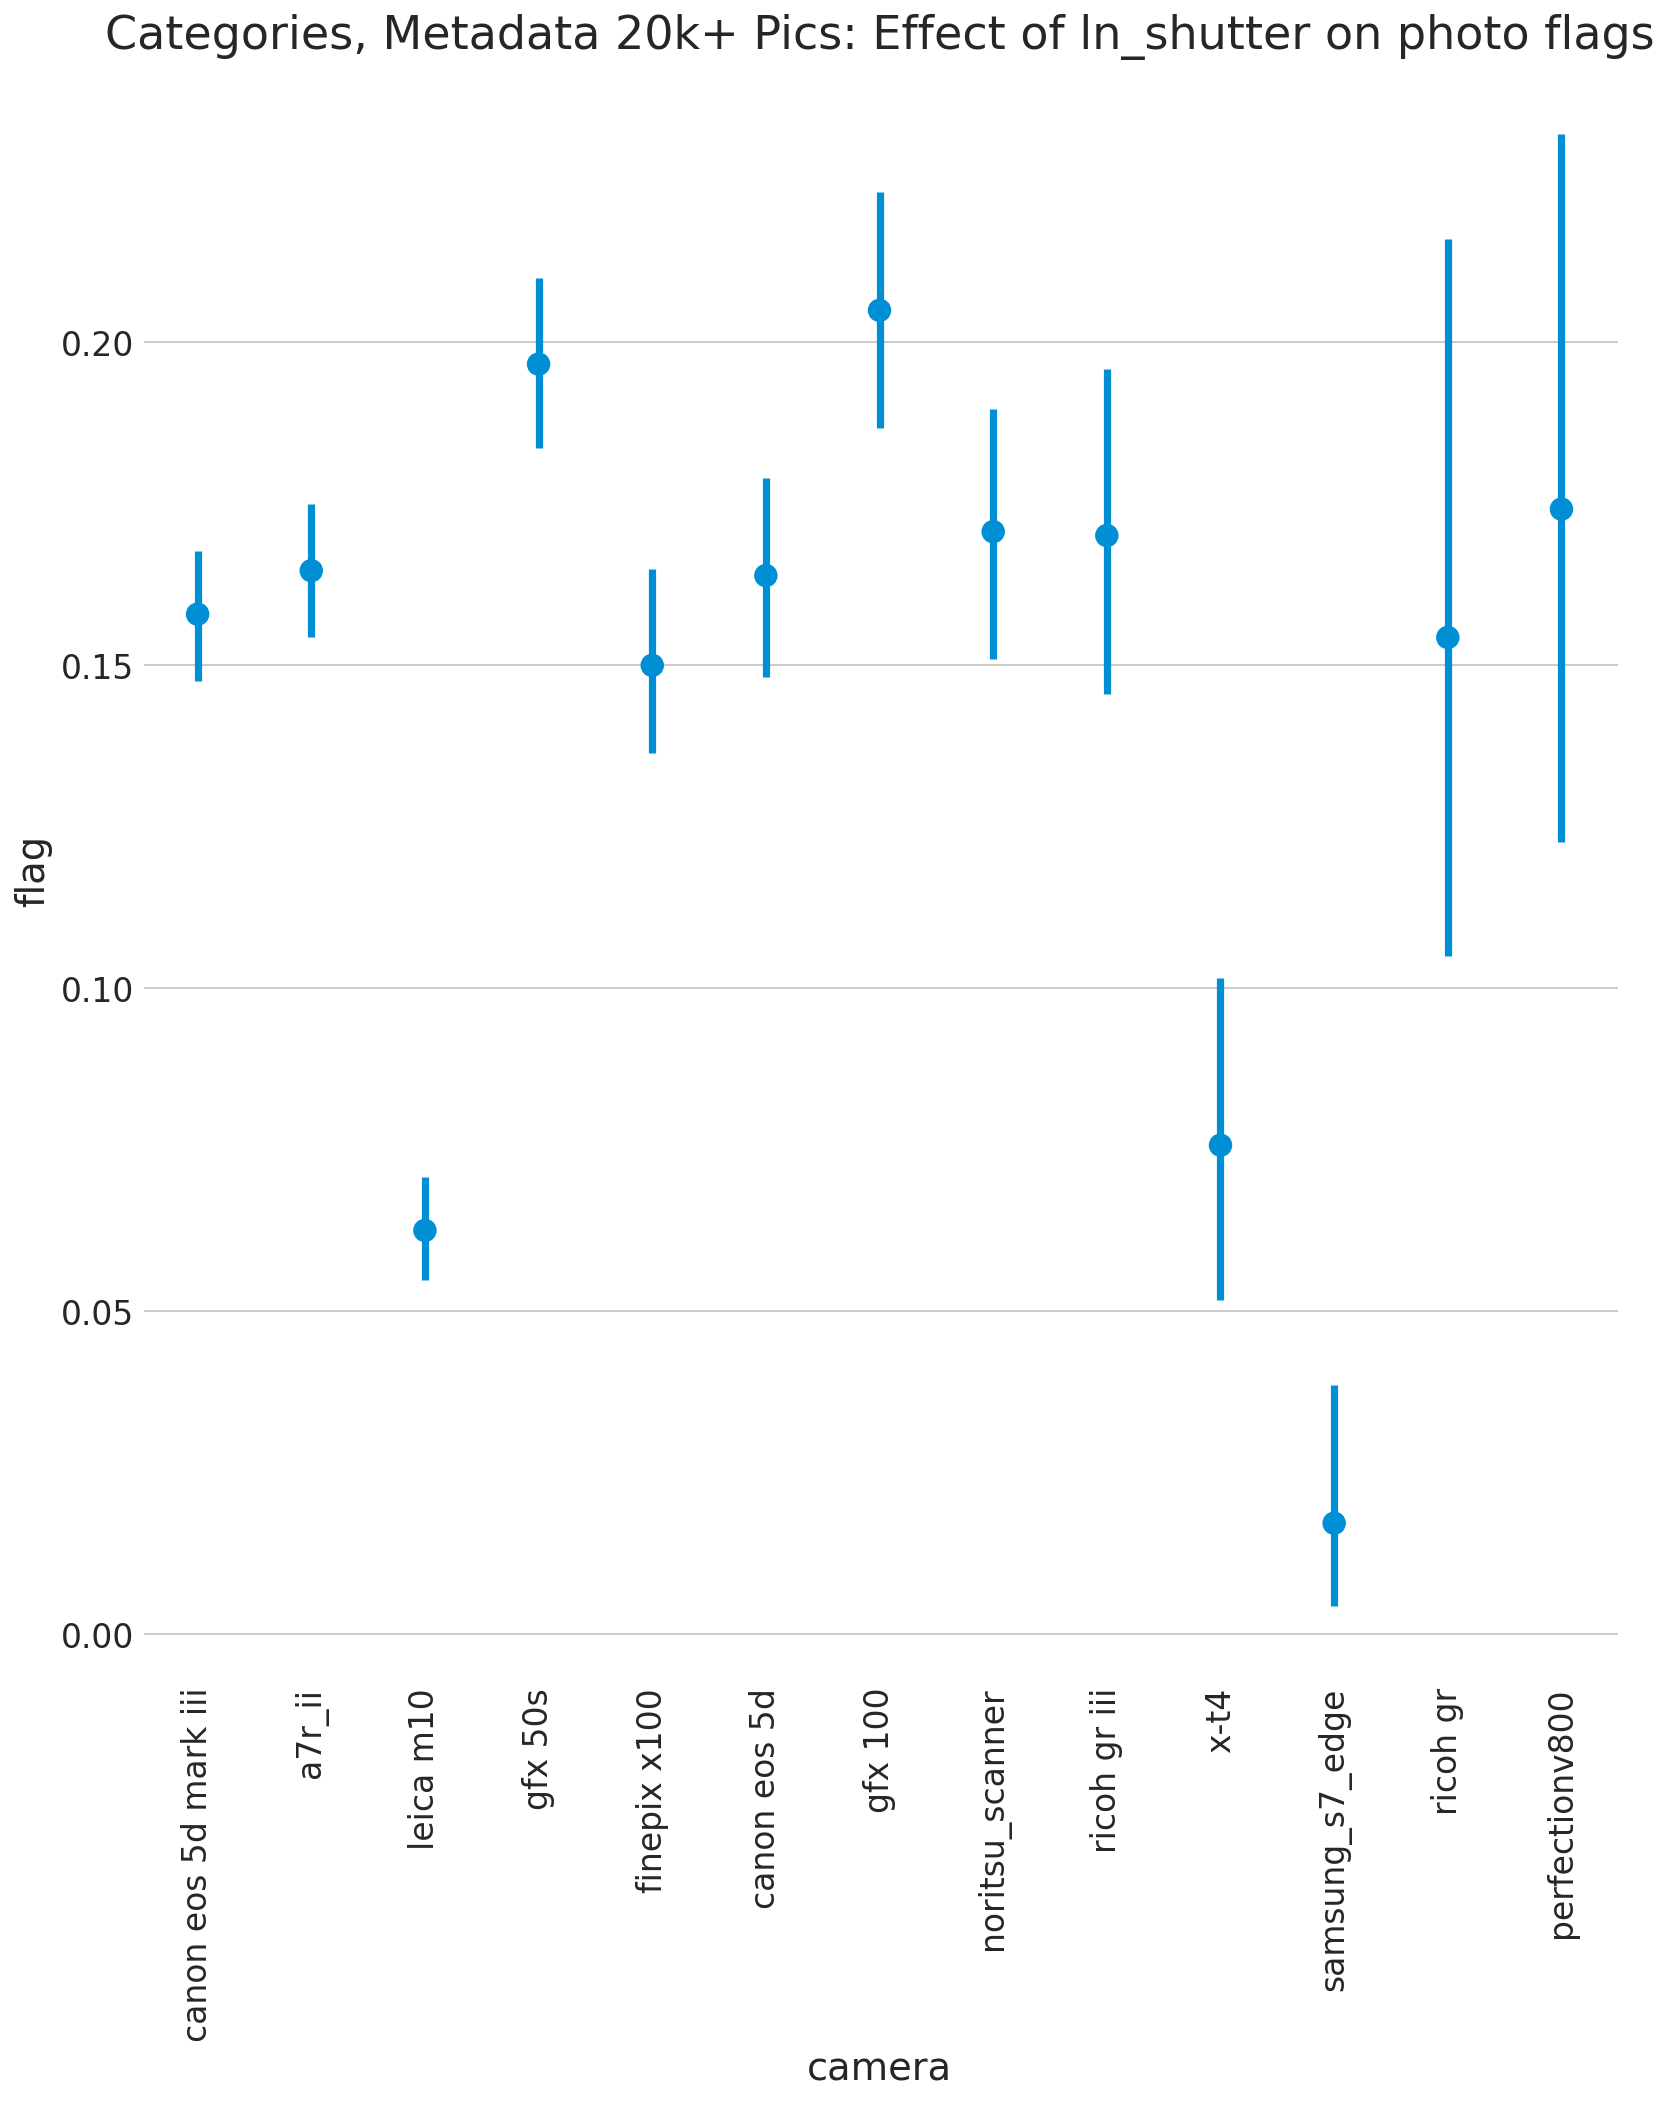

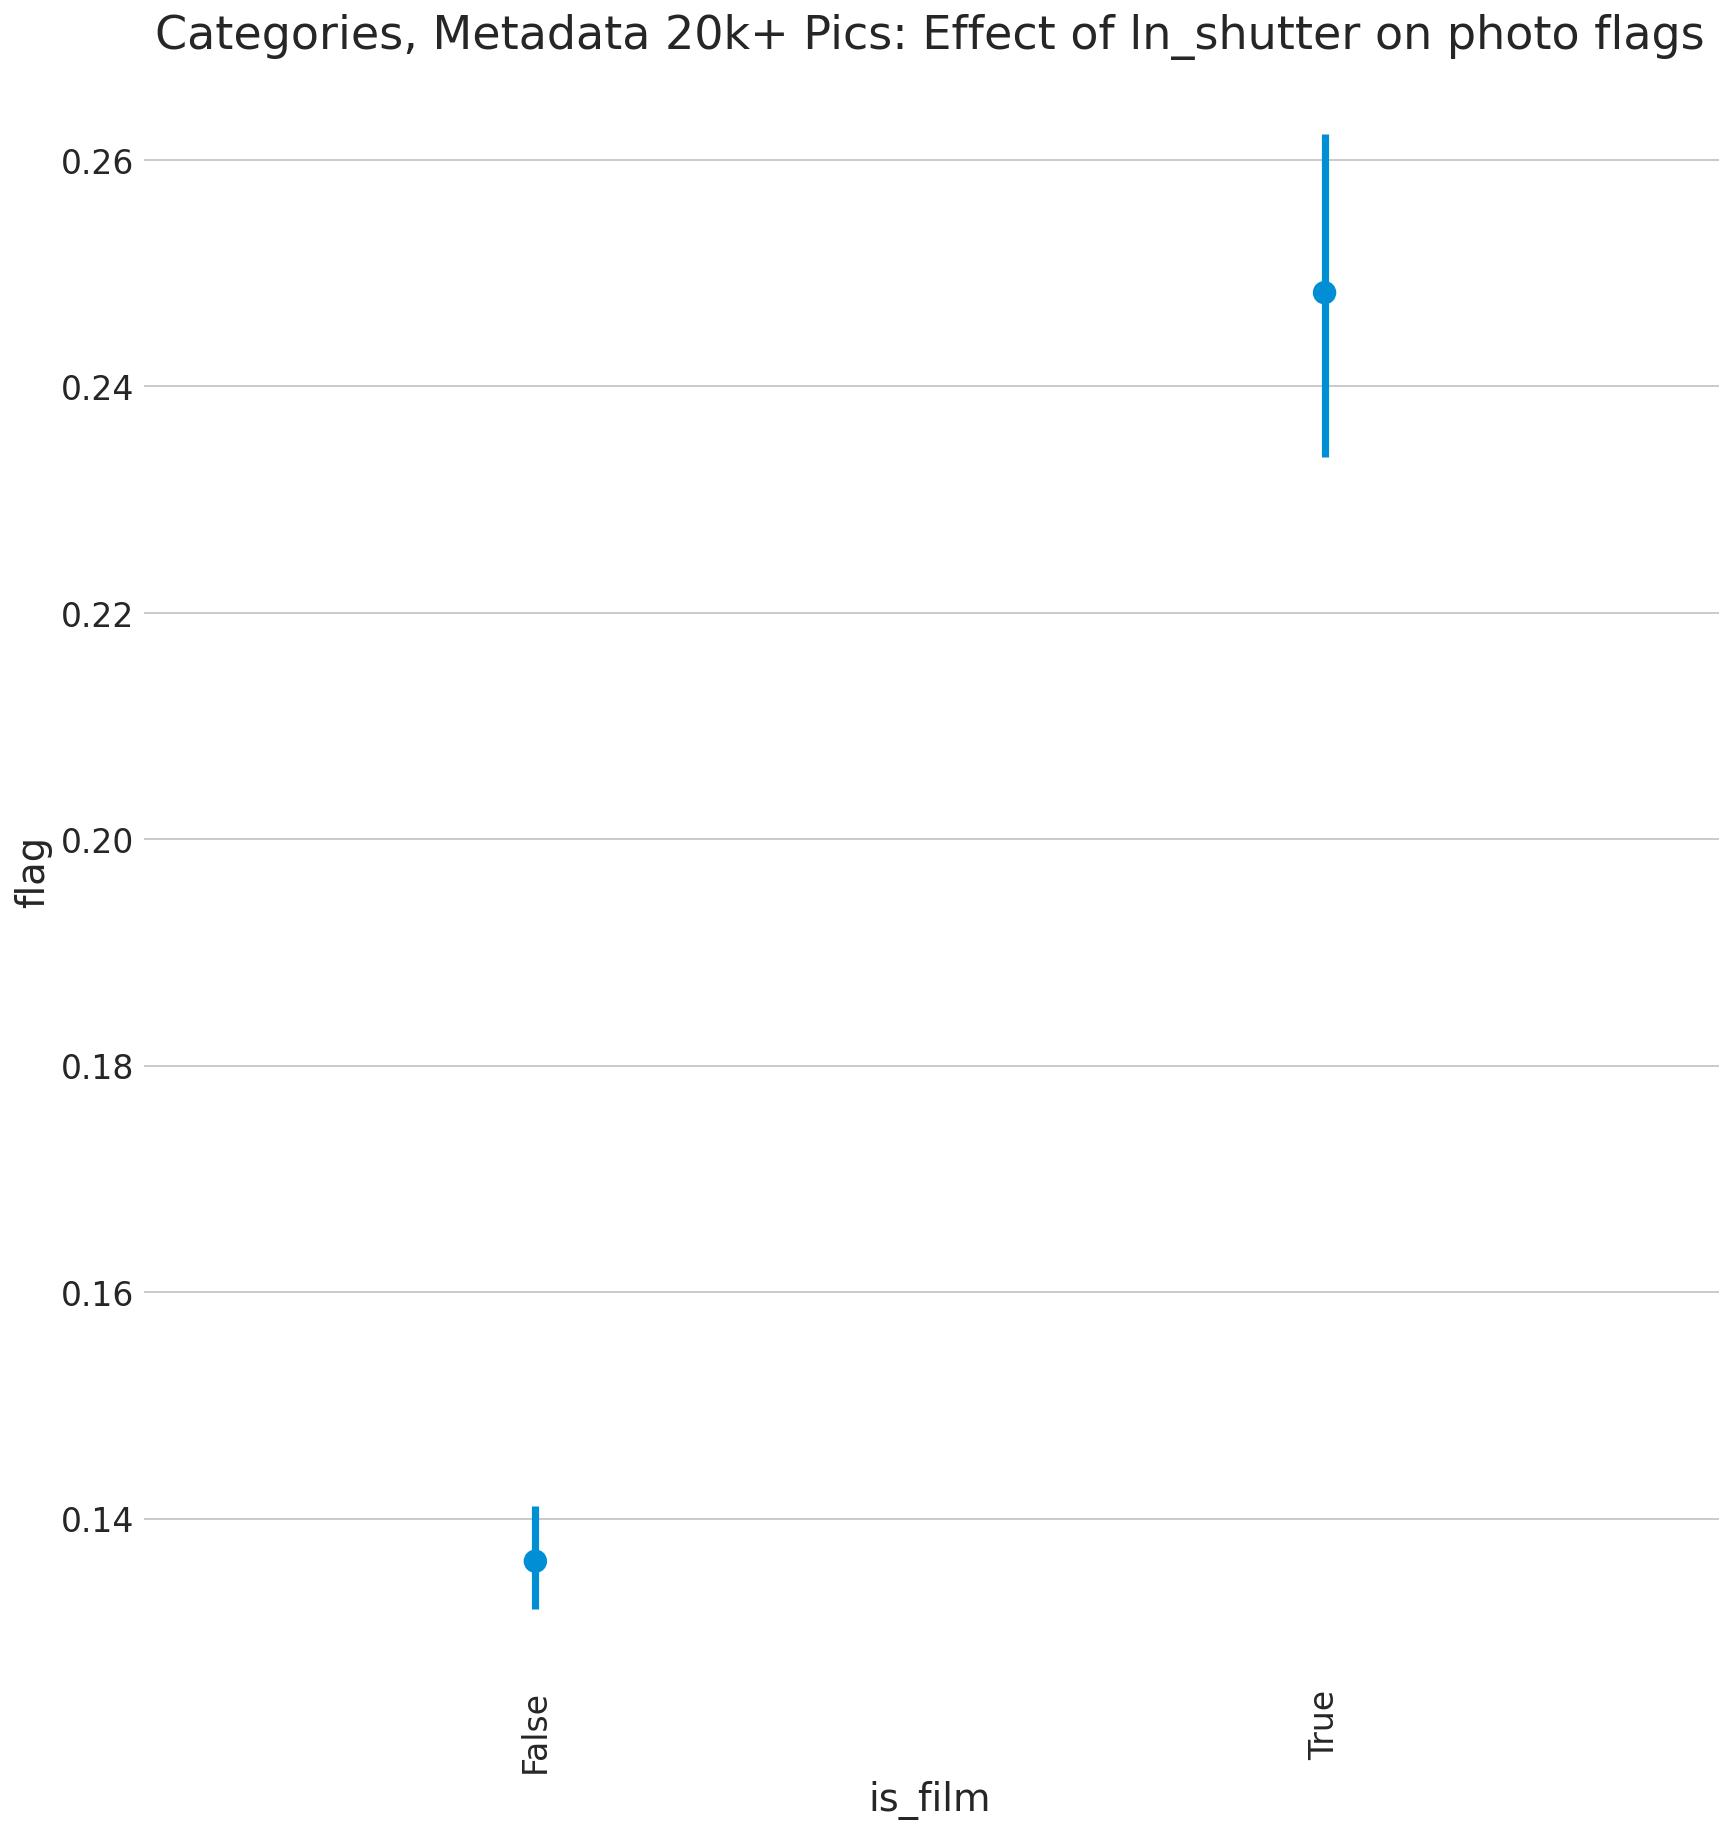

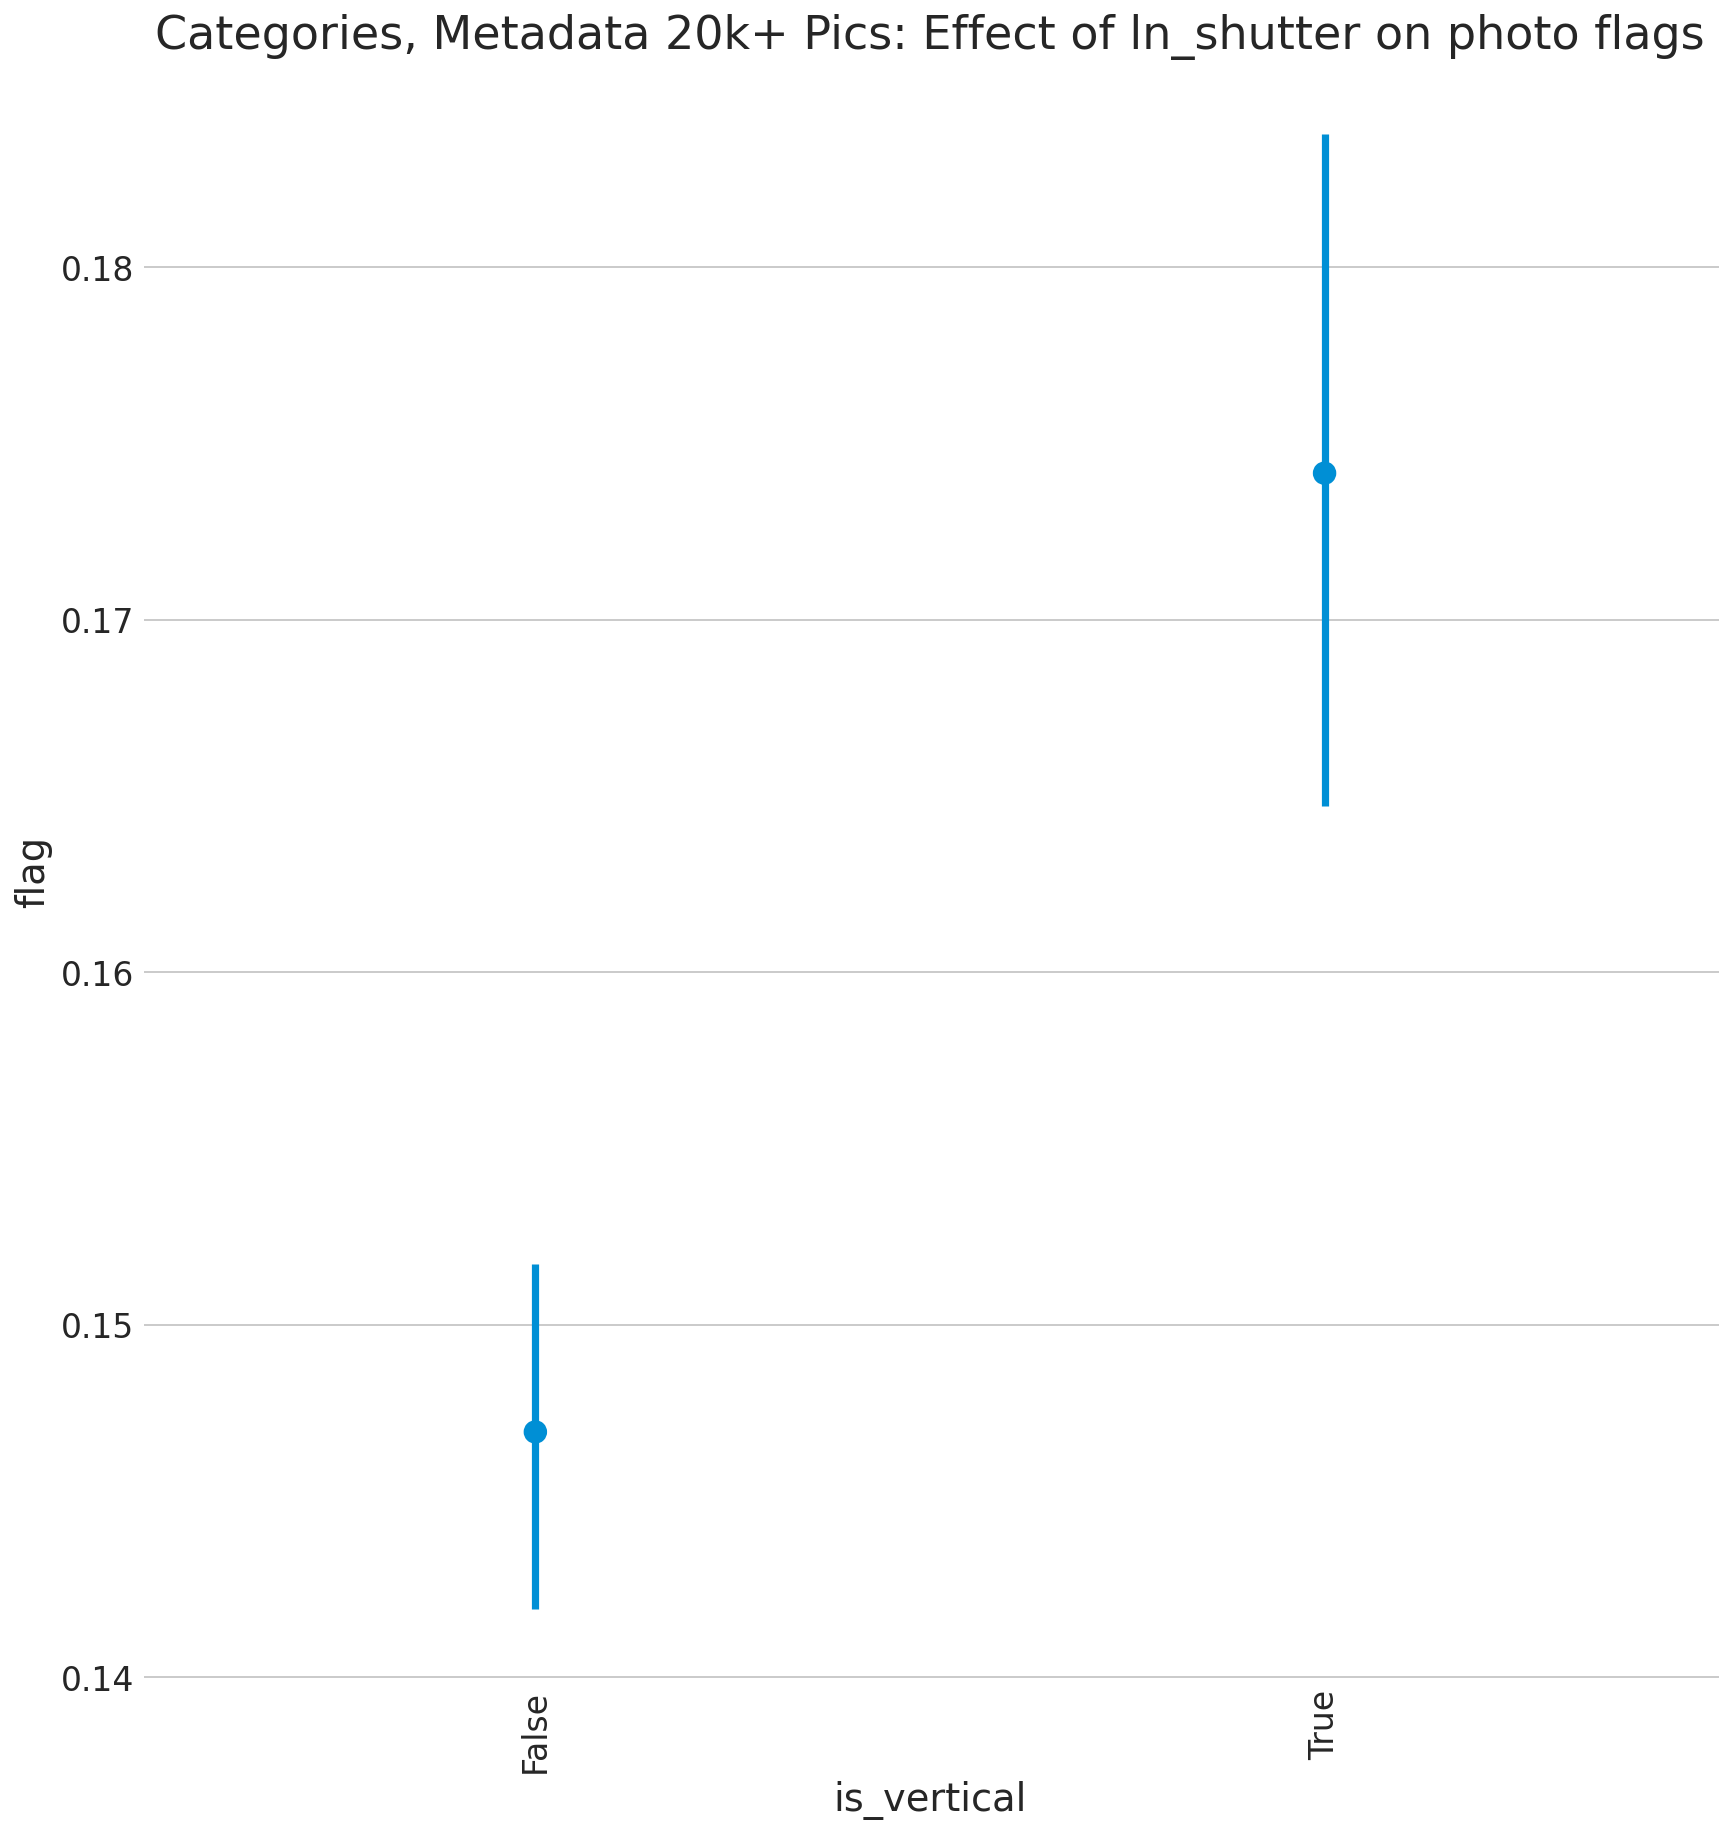

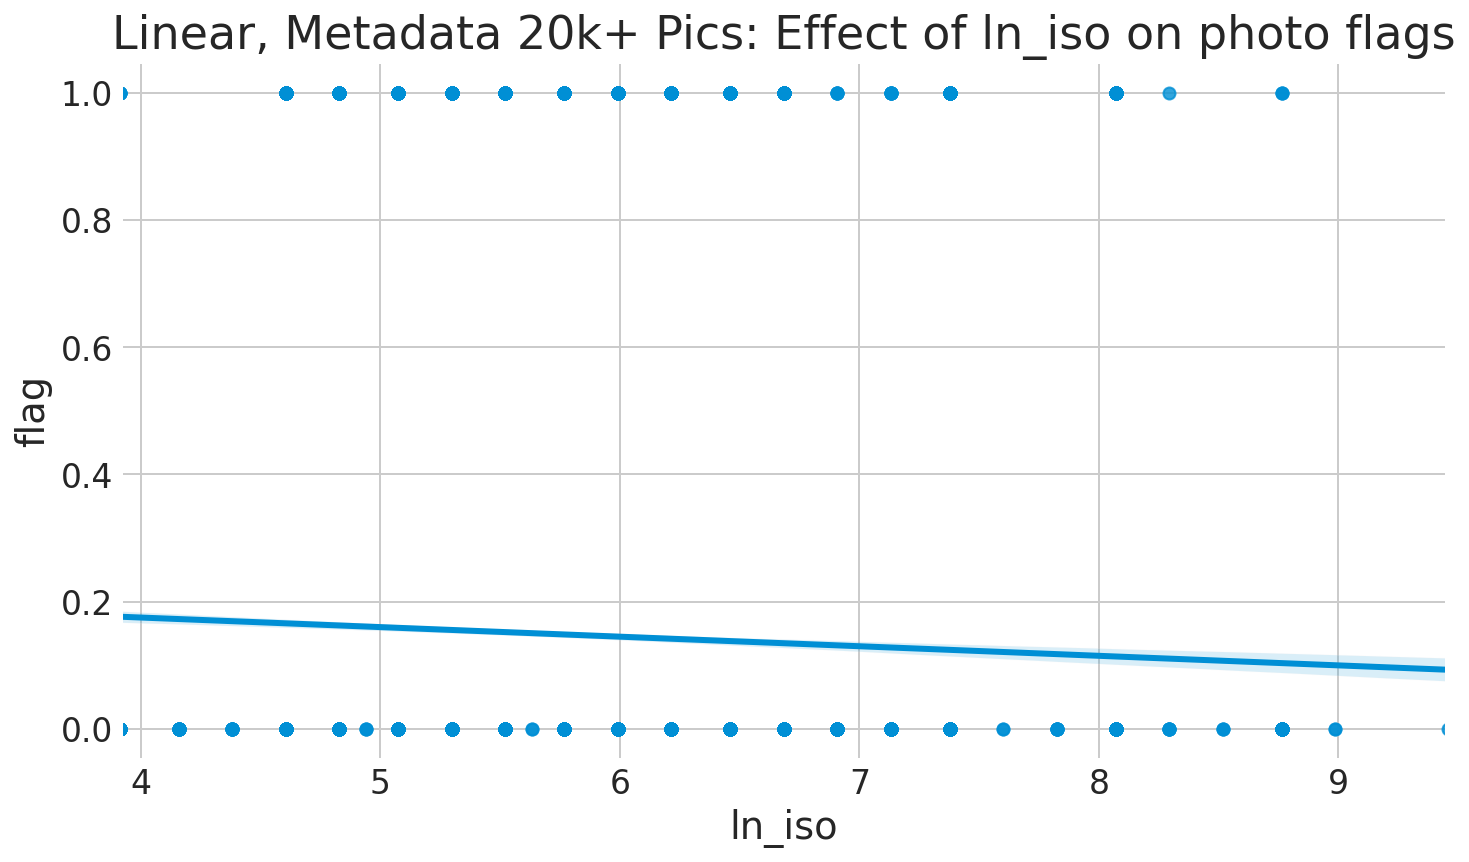

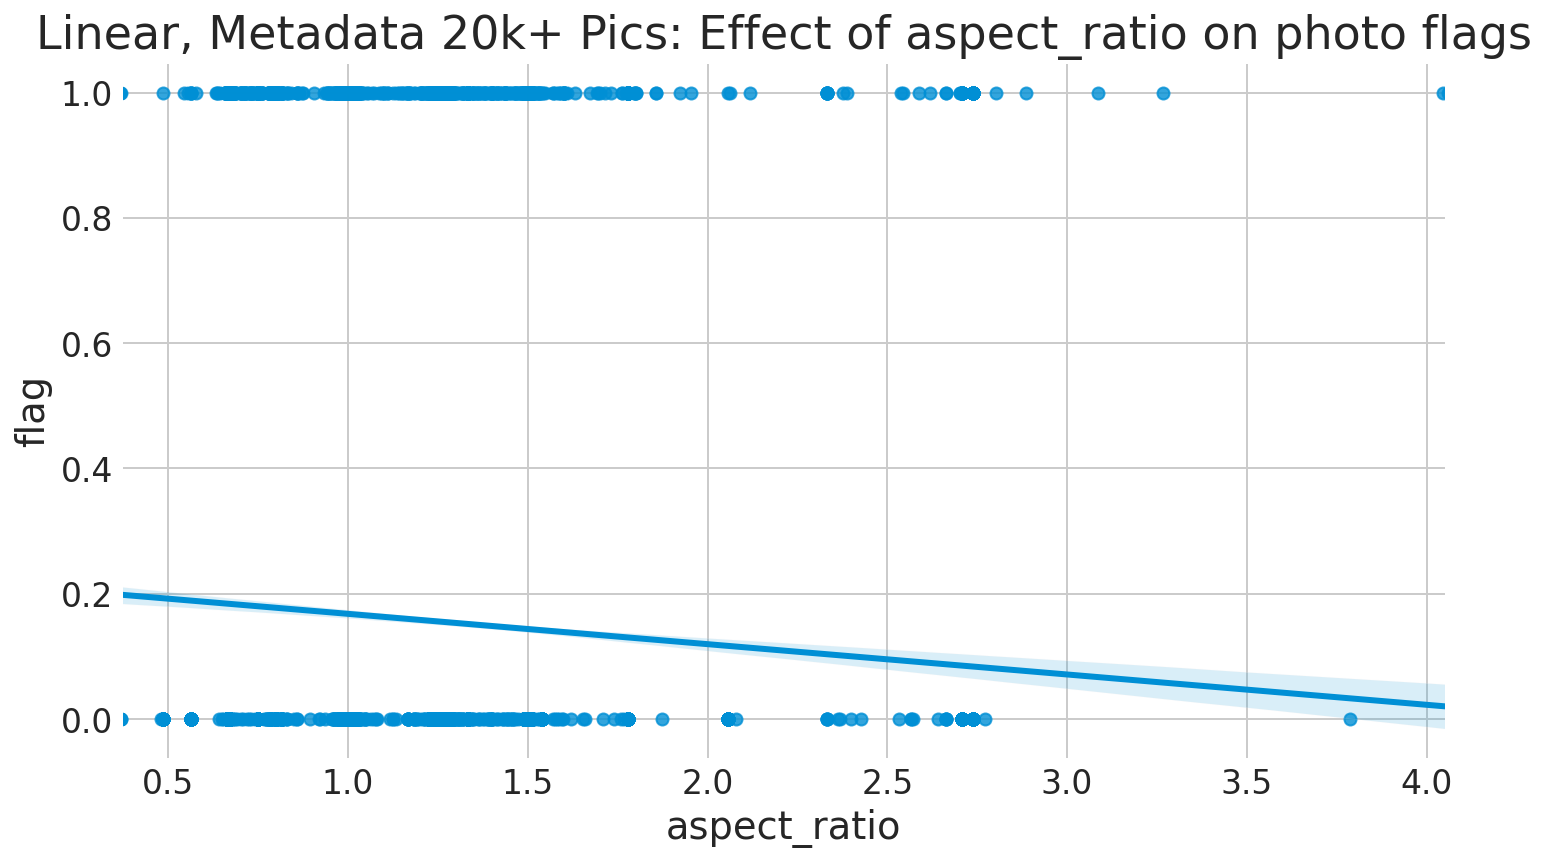

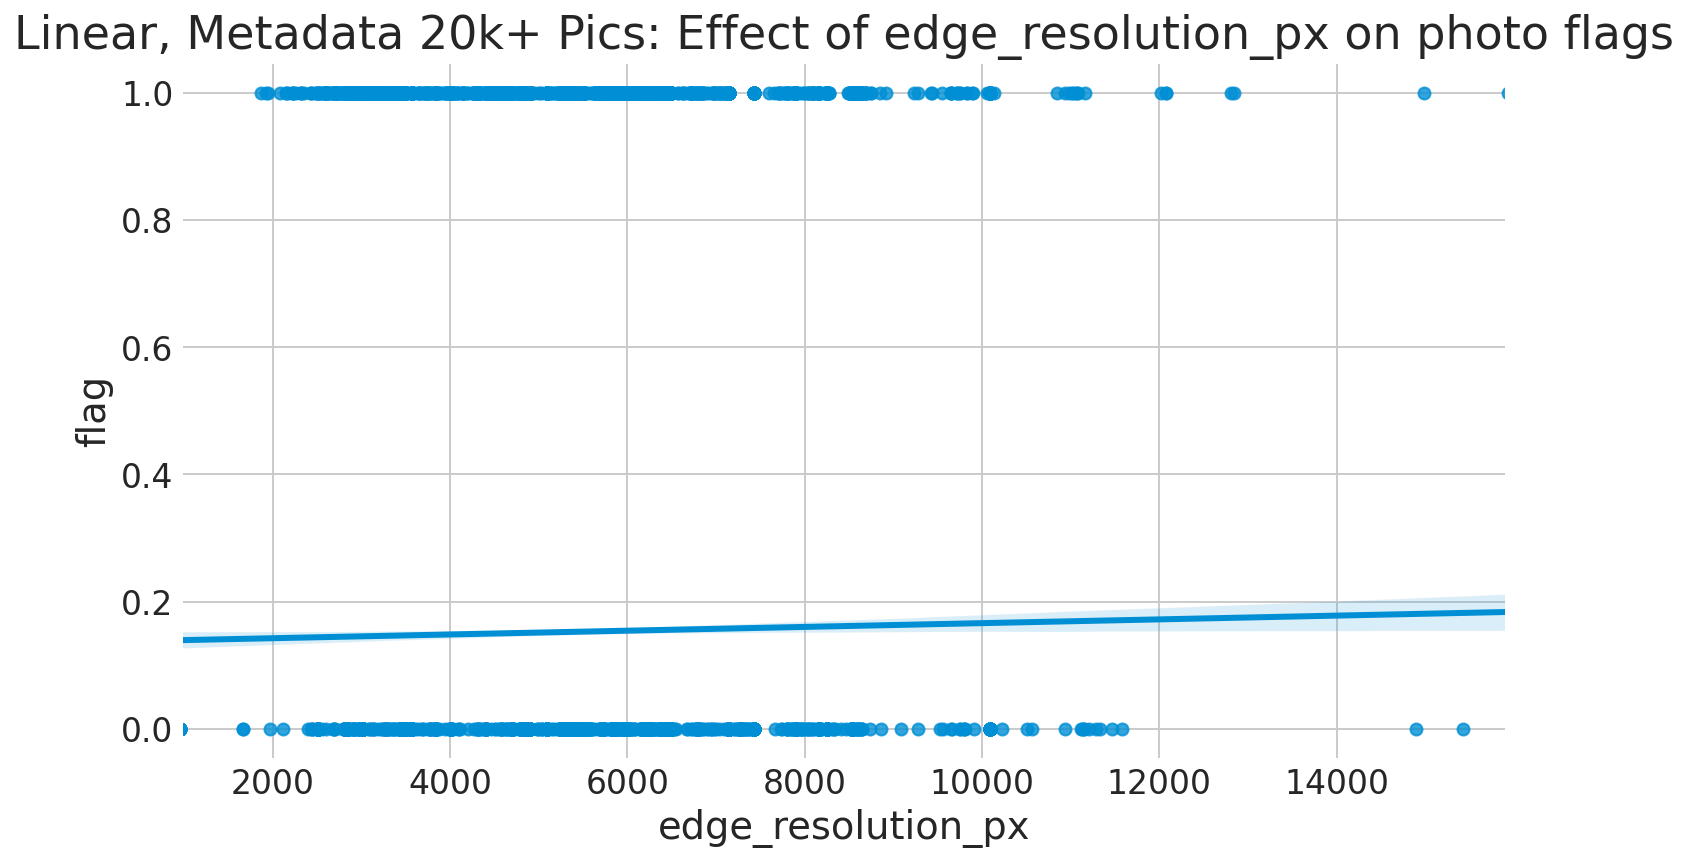

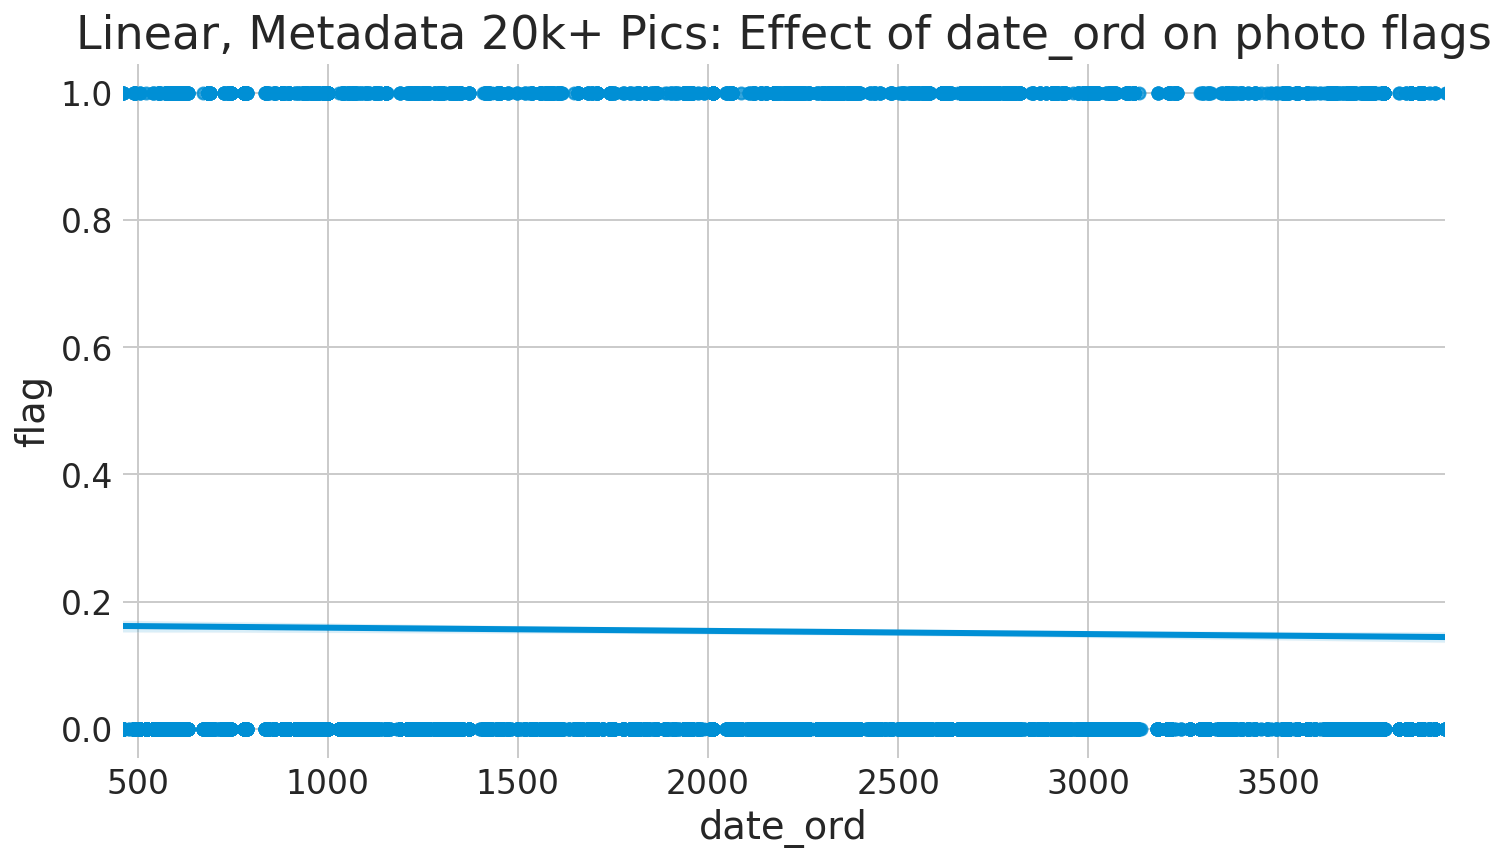

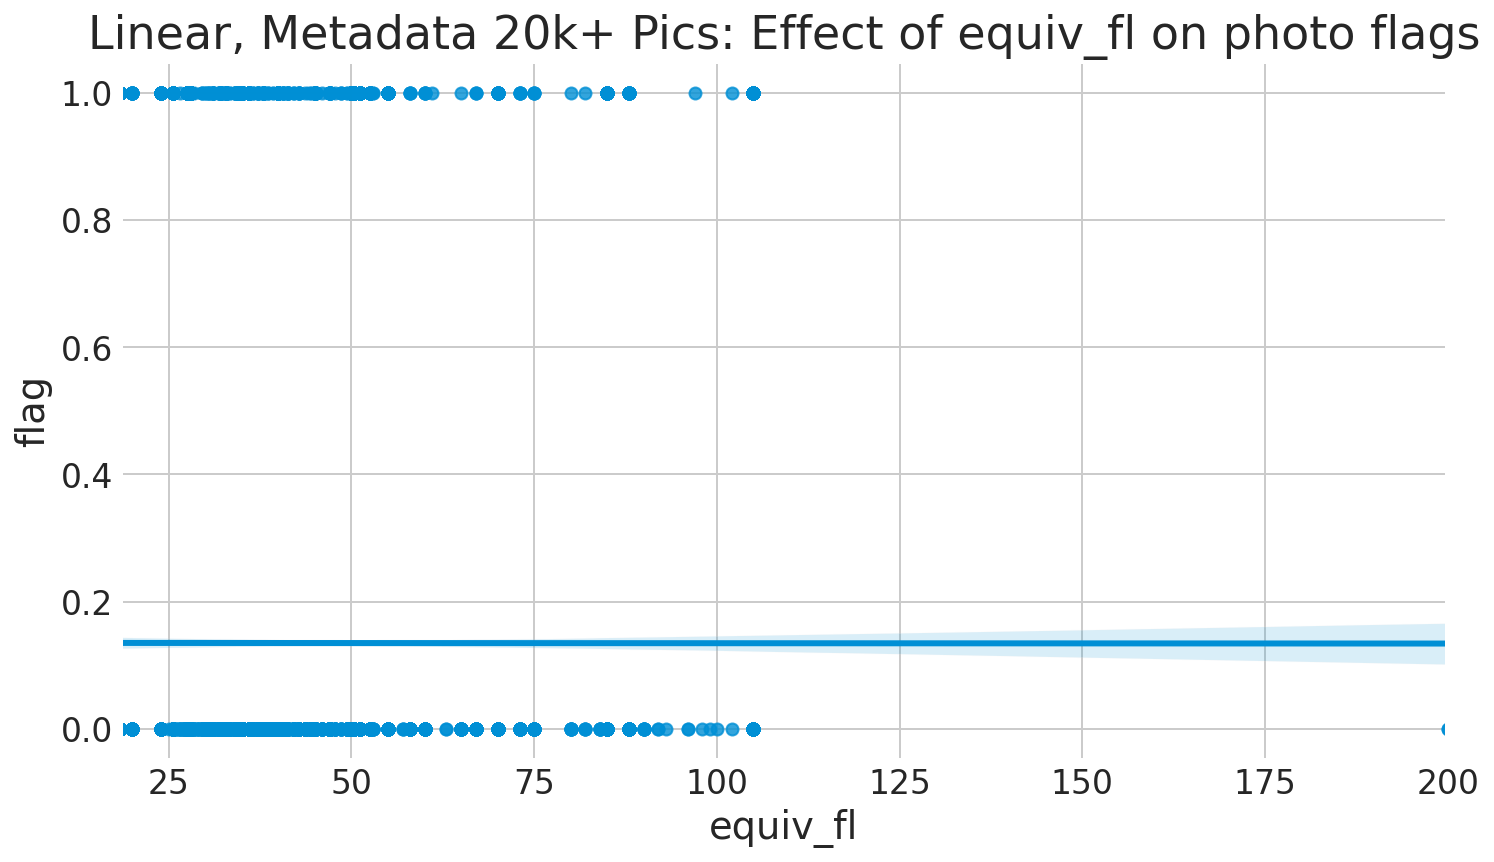

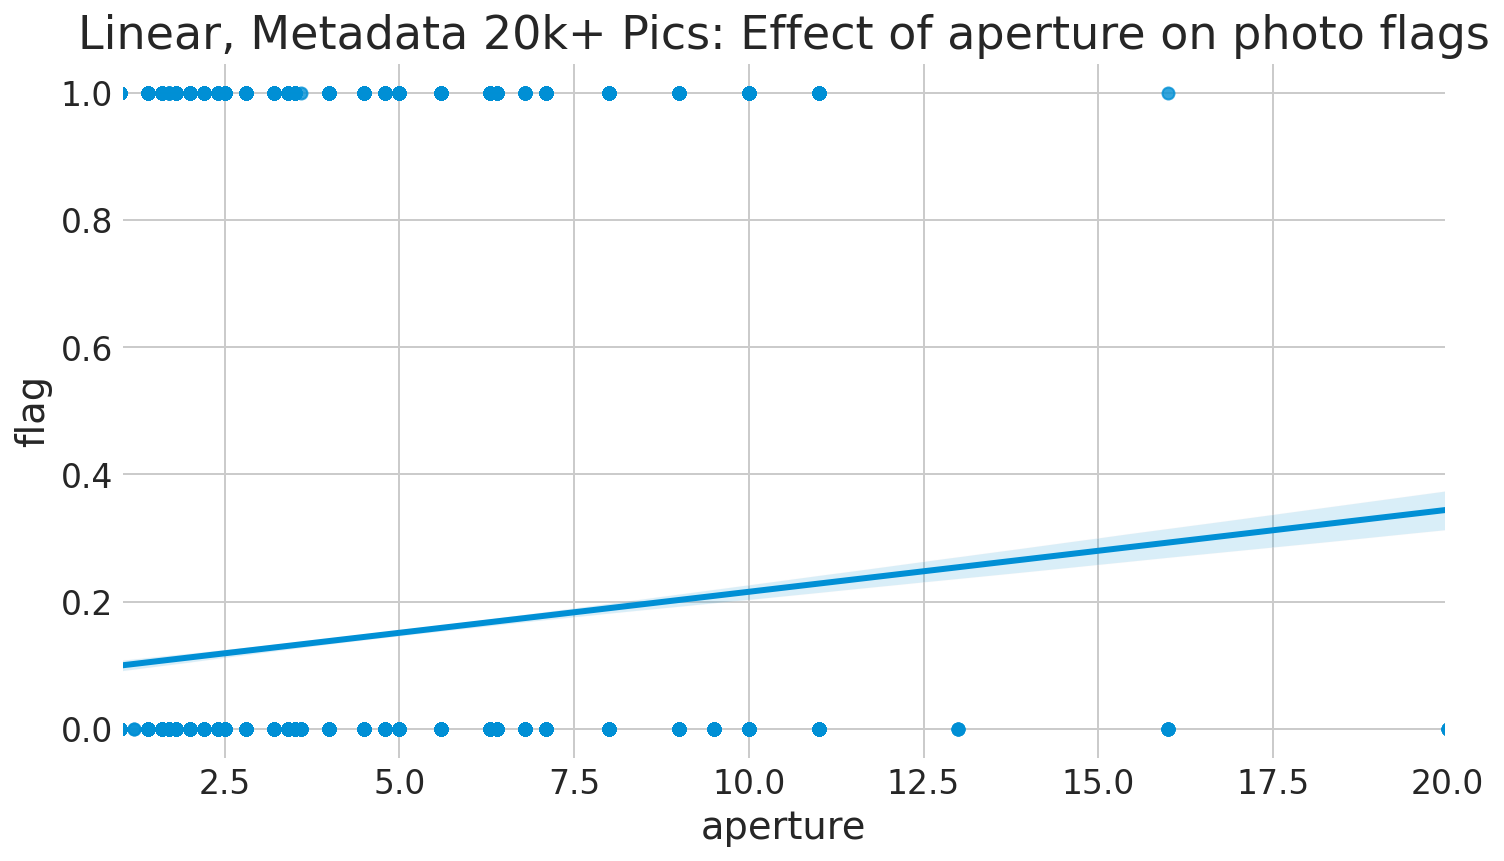

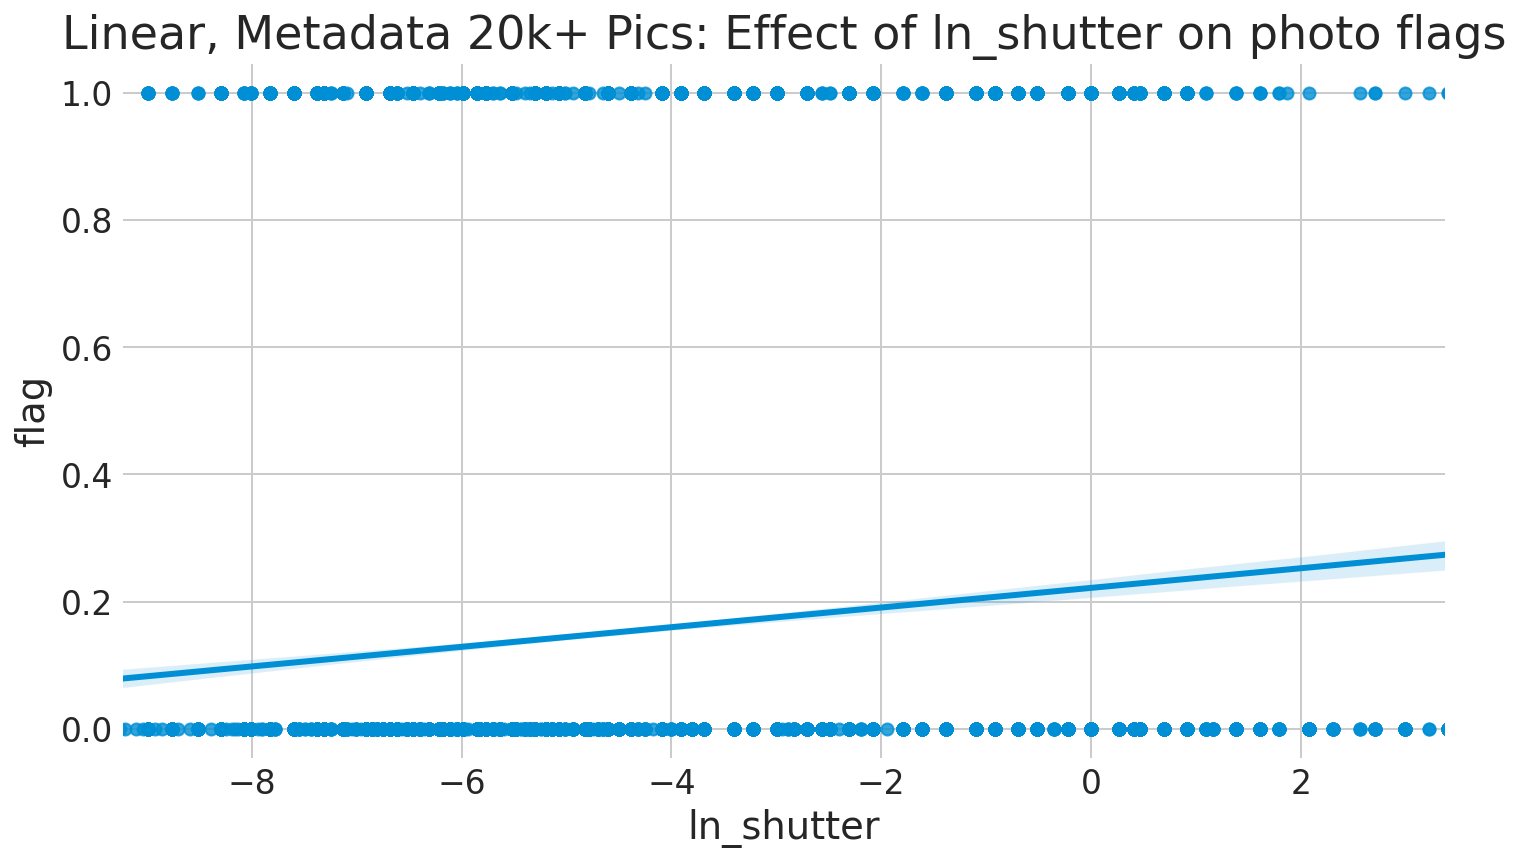

In [115]:
categorical_vars = [
    'camera',
    'is_film',
    'is_vertical',
]

OUTCOME = 'flag'

for factor in categorical_vars:
    freqs = ratings_md[factor].value_counts()
    # Filter on level of var occurred 3+ times; sort by freq
    freqs = freqs.loc[freqs >= 3]
    levels_to_eval = freqs.index
    
    _ = sns.catplot(
        x=factor,
        y=OUTCOME,
        data=ratings_md,
        order=levels_to_eval,
        kind='point',
        join=False,
        height=12,
    )
    _ = plt.title(f'Categories, Metadata 20k+ Pics: Effect of {var} on photo flags')
    _ = plt.xticks(rotation=90)
    plt.show()


cts_vars = [
    'ln_iso',
    'aspect_ratio',
    'edge_resolution_px',
    'date_ord',
    'equiv_fl',
    'aperture',
    'ln_shutter',
]

for var in cts_vars:
    _ = sns.regplot(
        x=var,
        y=OUTCOME,
        data=ratings_md,
        #size=12,
        #alpha=.05,
    )
    _ = plt.title(f"Linear, Metadata 20k+ Pics: Effect of {var} on photo flags")
    _ = plt.show()
    
    # lowess doesn't work for binary outcome
#     sns.regplot(
#         x=var,
#         y=OUTCOME,
#         data=ratings_md,
#         lowess=True
#     )
#     plt.title(f"Lowess, Metadata 20k+ Pics: Effect of {var} on photo flags")
#     plt.show()


- no terribly meaningful effects

#### Basic Frequentist Logistic Regression on 1+ rating  

Considering the above, there's not too much of a reason to proceed. Still, one must imagine Sisyphus happy! We will go on for the sake of exploring these packages (DoWhy, EconML) and methods (causal inference) and maybe finding some effects ;)

In some sense, we can think of this linear (logistic) regression as a causal diagram solution with the estimand being all xs directed toward y and the treatment also directed toward y.  
That is, we "control for" the causal effects of the confounders on y directly _but not their impacts on the treatment, aka selection bias_. We also ignore non-linear effects. (We could explicitly include interactions, but most practitioners rarely do without strong priors or observational data in my experience.)    

A nonlinear model like GBM/GBT includes nonlinear effects and interactions. Still, it is not _quite_ causal. Specifically, feature importance is typically just looking at which features we used to make our tree decisions (tree splits). (And if you fail to normalize your xs, your feature importances can be wildly skewed.)

Reference on causation vs. feature importance: https://microsoft.github.io/dowhy/example_notebooks/DoWhy-The%20Causal%20Story%20Behind%20Hotel%20Booking%20Cancellations.html#Comparing-Results-with-XGBoost-Feature-Importance

It's worth noting that feature importance is a bit flawed, as discussed in the SHAP paper. Still, SHAP effects are not causal - they're "just" the game theoretically optimal explanation for our effects. This isn't "wrong," since SHAP effects aren't intended to be causal!

In [104]:
#sns.distplot(np.log10(ratings_md.shutter))

In [105]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


OHE_X_COLS = [
    'camera',
    #'is_film',
]

RAW_X_COLS = [
    'equiv_fl',
    'ln_iso',
    'edge_resolution_px',
    'aspect_ratio',
    'date_ord',
    'is_film',  # already bool, no need to encode
    'is_vertical', # '''
    'aperture',  # pretty uniform, not normal; but hard to transf to normal
    'ln_shutter',
]


In [106]:
import shap


# XGB Model fixture
XGB_BINARY = XGBClassifier(
    objective="binary:logistic",
    max_depth=5,
    learning_rate=0.02,
    n_estimators=400,
    subsample=.9,
    colsample_bytree=.8,
    reg_alpha=.25,
    tree_method= 'hist',  # fast with less overfit
    grow_policy= 'depthwise',  # less overfit w/ hist vs. lossguide
    n_jobs=4,
)

In [112]:
from typing import List
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.model_selection import TimeSeriesSplit
# The training set has size:
# i * n_samples // (n_splits + 1) + n_samples % (n_splits + 1) in the i``th split,
# with a test set of size ``n_samples//(n_splits + 1), where n_samples is the number of samples.
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error, roc_auc_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
import statsmodels.api as sm
from tqdm.notebook import tqdm

def fit_basic_lr(cts_feats: List[str], ohe_feats: List[str], outcome:str, data:pd.DataFrame = ratings_md,
                  ts_col:str = 'taken_at') -> None:
    """
    d o c s t r i n g  g o e s  h e r e
    """
    # (1) Prep data
    # ensure data sorted
    data = data.copy().sort_values(ts_col, ascending=True).reset_index(drop=True)

    xs = data[cts_feats].copy().astype('float')
    # normalize
    xs = (xs - xs.mean()) / xs.std()
    # Add const for statsmodels
    xs['const'] = 1
    ys = data[outcome].copy()
    # don't normalize binary outcome
    #ys = (ys - ys.mean()) / ys.std()

    for cat in ohe_feats:
        dummies = pd.get_dummies(data[cat])
        xs = xs.merge(dummies, left_index=True, right_index=True, validate='1:1')

    # Basic column-wise fill na with mean.
    xs = xs.fillna(xs.mean())
    #assert(xs.min().min() > -100)
    #assert(xs.max().max() < 100)
    
    print('Fit on following data (sample):')
    print(xs.sample(10, random_state=42))

    # (2) Fit SM OLS for feature signif & diagnosis
    model = sm.Logit(
        ys,
        xs,
    )
    results = model.fit(
        maxiter=10_000,
        method='newton',  # (default in SM)# 'nm',#'lbfgs', # 'bfgs', (tends to work well), 
    )
    print(results.summary())
    
    # (2.5) Optionally also fit reg'd SM model for simplicity
    model = sm.Logit(
        ys,
        xs,
    )
    results = model.fit_regularized(
        method='l1',
        alpha=10.01,  # 'small' amount of reg
        maxiter=5_000,
        trim_mode='size',  # trim coeffs that drop to ~0 after L1 reg
        size_trim_tol=.001,
    )
    print('')
    print('With L1 REG')
    print(results.summary())

    # (3) Fit reg'd SKLearn model for prediction & testing
    #ridge = BayesianRidge()
#     ridge = LogisticRegressionCV(
#         Cs=[1, 10],
#         l1_ratios=[.2, .5, .9],
#         penalty='elasticnet',
#         solver='saga',  # req'd for elasticnet reg
#         max_iter=5_000,
#         cv=3,
#         random_state=123,
#     )

    # bad var name, it's not a ridge :)
    ridge = LogisticRegression(
        C=10,
        l1_ratio=.33,
        penalty='elasticnet',
        solver='saga',  # req'd for elasticnet reg
        max_iter=10_000,
        random_state=123,
    )
    #ridge = LinearRegression()
    ridge.fit(xs, ys)
    preds = ridge.predict(xs)
    
    # Fit XGB for SHAP
    xgb_model = XGB_BINARY.fit(xs, ys)
    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(xs)
    shap.summary_plot(shap_values, xs)
    plt.show()
    shap.summary_plot(shap_values, xs, plot_type="bar")
    plt.show()

    # Now look at CV (OOT CV)
    # SKL ts split func is pretty primitive, not much better than doing it yourself...
    # TSCV is probably overkill here, btw
    tscv = TimeSeriesSplit(
        n_splits=10,
    )
    # just use AUC #mean ae + r2 for now
    #r2s = []
    #mean_aes = []
    #dummy_maes = []
    #dummy = DummyRegressor(strategy='mean')
    aucs = []
    xgb_aucs = []
    
    for train_index, test_index in tqdm(tscv.split(xs)):
        x_train, x_test = xs.iloc[train_index, :], xs.iloc[test_index,:]
        y_train, y_test = ys.iloc[train_index], ys.iloc[test_index]

        ridge.fit(x_train, y_train)

        # confirm works on train
        #preds, pred_stds = ridge.predict(x_train, y_train)
        #train
        #r2 = r2_score(y_train, preds)
        #mean_ae = mean_absolute_error(y_train, preds)

        preds = ridge.predict_proba(x_test)[:, 1] 
        #r2 = r2_score(y_test, preds)
        #mean_ae = mean_absolute_error(y_test, preds)

        #dummy.fit(x_train, y_train)
        #dummy_preds = dummy.predict(x_test)
        #dummy_mae = mean_absolute_error(y_test, dummy_preds)
        
        auc = roc_auc_score(y_test, preds)
        aucs.append(auc)
        
        #r2s.append(r2)
        #mean_aes.append(mean_ae)
        #dummy_maes.append(dummy_mae)
        
        # also try nonlinear model (XGB GBM)
        xgb_model.fit(x_train, y_train)
        preds = xgb_model.predict_proba(x_test)[:, 1] 
        xgb_auc = roc_auc_score(y_test, preds)
        xgb_aucs.append(xgb_auc)

    #r2s = pd.Series(r2s).round(3)
    #mean_aes = pd.Series(mean_aes).round(3)
    #dummy_maes = pd.Series(dummy_maes).round(3)
    aucs = pd.Series(aucs).round(3)
    xgb_aucs = pd.Series(xgb_aucs).round(3)

    print('\n\n * * Fit regularized linear model on timeseries CV: * *')
    print('AUCs by TS slice: ', aucs.tolist(), ' avg: ', aucs.mean())
    print('\n\n * Fit XGB on timeseries CV: * *')
    print('XGB AUCs by TS slice: ', xgb_aucs.tolist(), ' avg: ', xgb_aucs.mean())

Fit on following data (sample):
           equiv_fl    ln_iso  edge_resolution_px  aspect_ratio  date_ord   is_film  is_vertical      aperture  ln_shutter  const  a7r_ii  \
3329   1.238102e-13 -0.241342           -0.485389      0.529563 -1.340697 -0.416672    -0.523579 -1.162569e-13    0.364102      1       0   
866    1.562069e+00 -0.938778           -1.151068      0.529563 -1.720188 -0.416672    -0.523579  3.717626e-02   -0.186619      1       0   
10376 -4.989177e-01 -0.938778            0.563819      0.527469 -0.046132 -0.416672    -0.523579  1.172766e+00   -0.334990      1       1   
24156 -1.073704e+00 -0.241342           -0.370617      0.529563  1.547248 -0.416672    -0.523579  2.642942e-01   -1.302316      1       0   
10606 -1.048514e+00 -0.938778            0.563819      0.527469 -0.013162 -0.416672    -0.523579  1.172766e+00   -0.052502      1       1   
10144 -7.279162e-01 -0.938778            0.115506     -1.255422 -0.091834 -0.416672     1.909858 -6.441774e-01    0.498219

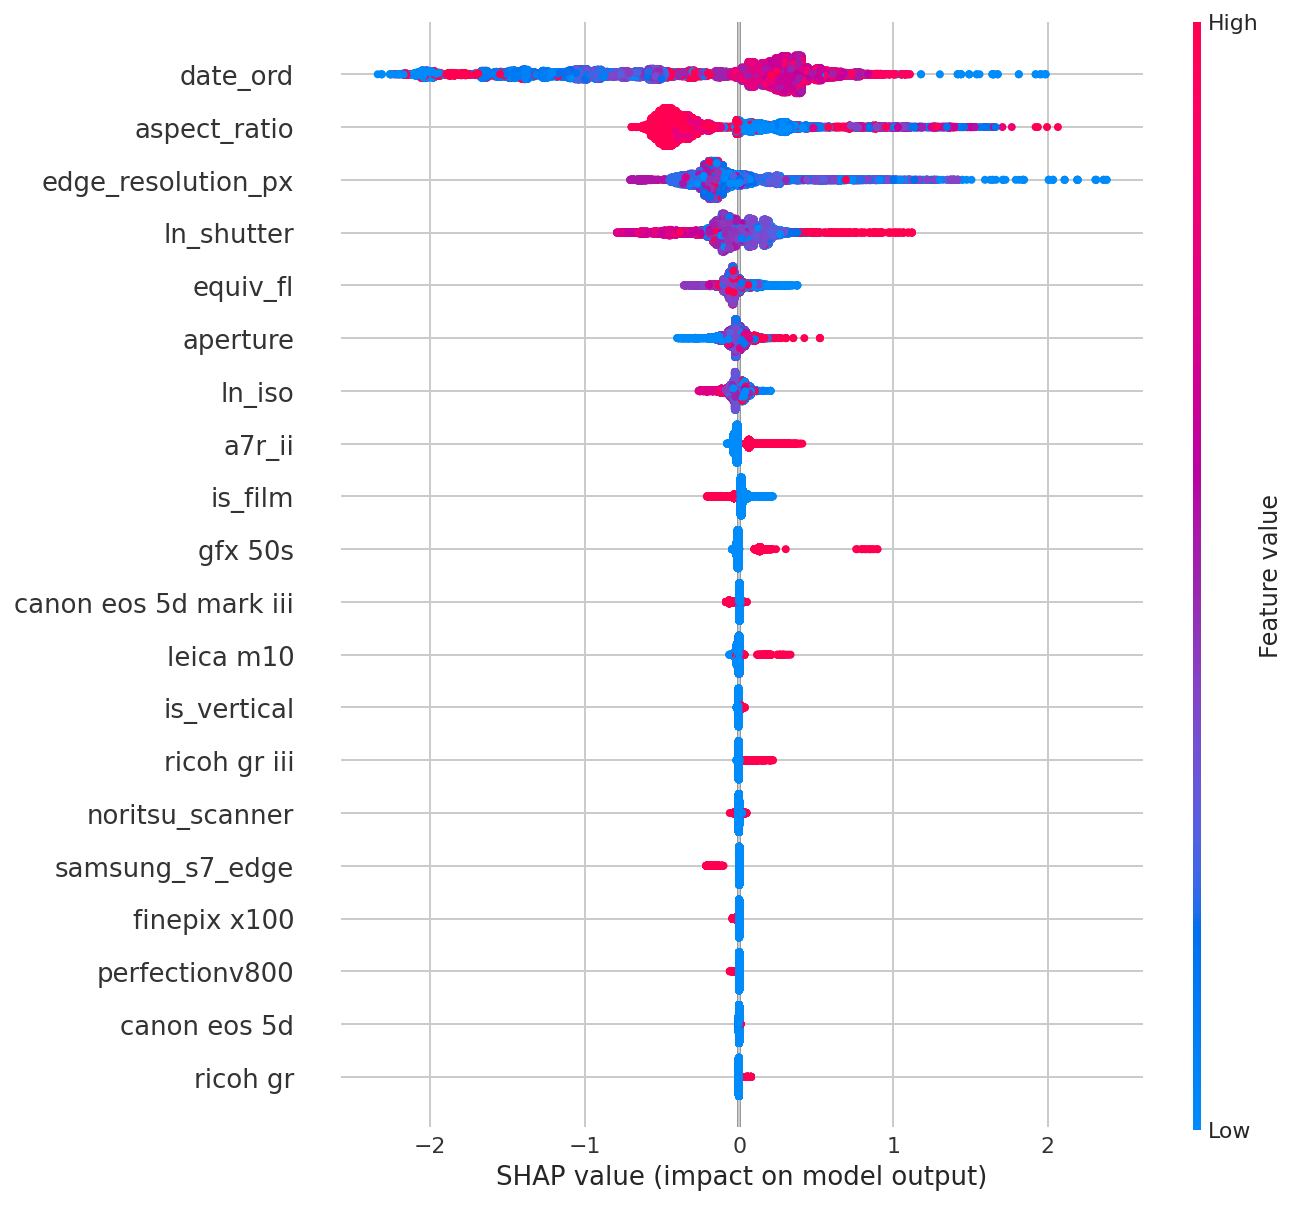

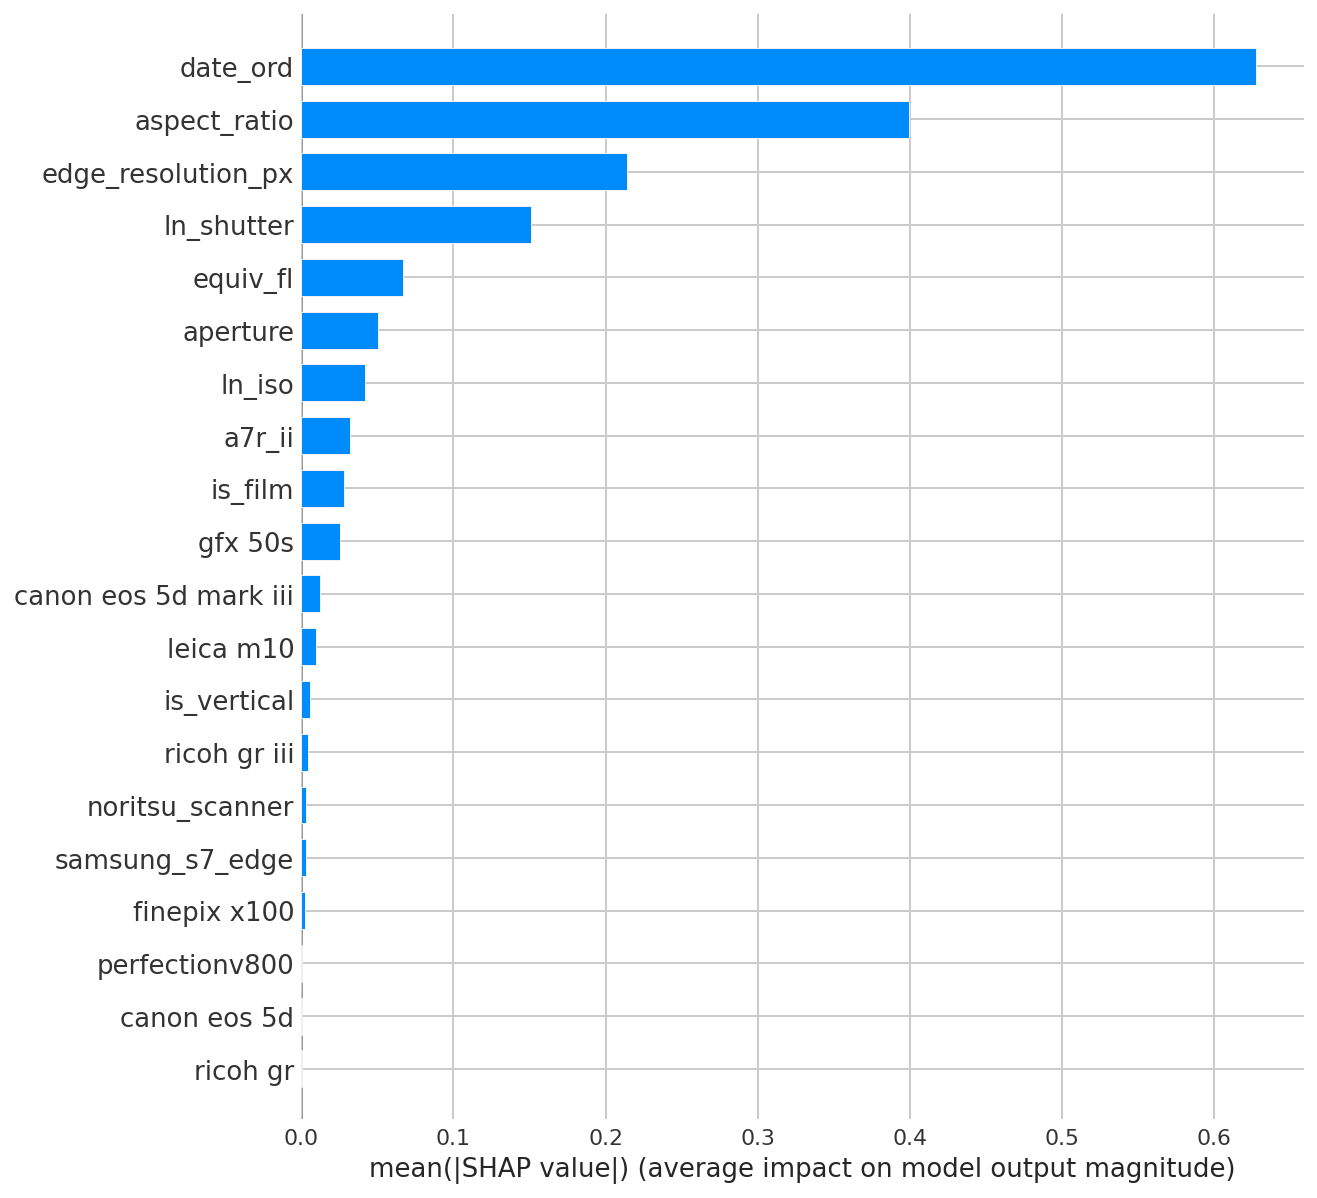




 * * Fit regularized linear model on timeseries CV: * *
AUCs by TS slice:  [0.612, 0.738, 0.531, 0.539, 0.43, 0.677, 0.657, 0.605, 0.593, 0.424]  avg:  0.5806000000000002


 * Fit XGB on timeseries CV: * *
XGB AUCs by TS slice:  [0.54, 0.633, 0.552, 0.499, 0.785, 0.789, 0.652, 0.741, 0.627, 0.582]  avg:  0.6399999999999999


In [108]:
OUTCOME = 'rated_1_plus'

fit_basic_lr(
    RAW_X_COLS,
    OHE_X_COLS,
    OUTCOME,
)

Fit on following data (sample):
           equiv_fl    ln_iso  edge_resolution_px  aspect_ratio  date_ord   is_film  is_vertical      aperture  ln_shutter  const  a7r_ii  \
3329   1.238102e-13 -0.241342           -0.485389      0.529563 -1.340697 -0.416672    -0.523579 -1.162569e-13    0.364102      1       0   
866    1.562069e+00 -0.938778           -1.151068      0.529563 -1.720188 -0.416672    -0.523579  3.717626e-02   -0.186619      1       0   
10376 -4.989177e-01 -0.938778            0.563819      0.527469 -0.046132 -0.416672    -0.523579  1.172766e+00   -0.334990      1       1   
24156 -1.073704e+00 -0.241342           -0.370617      0.529563  1.547248 -0.416672    -0.523579  2.642942e-01   -1.302316      1       0   
10606 -1.048514e+00 -0.938778            0.563819      0.527469 -0.013162 -0.416672    -0.523579  1.172766e+00   -0.052502      1       1   
10144 -7.279162e-01 -0.938778            0.115506     -1.255422 -0.091834 -0.416672     1.909858 -6.441774e-01    0.498219

Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4098529014211549
            Iterations: 199
            Function evaluations: 199
            Gradient evaluations: 199

With L1 REG
                           Logit Regression Results                           
Dep. Variable:                   flag   No. Observations:                25646
Model:                          Logit   Df Residuals:                    25628
Method:                           MLE   Df Model:                           17
Date:                Tue, 29 Dec 2020   Pseudo R-squ.:                 0.05255
Time:                        17:50:01   Log-Likelihood:                -10389.
converged:                       True   LL-Null:                       -10965.
Covariance Type:            nonrobust   LLR p-value:                1.962e-234
                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------

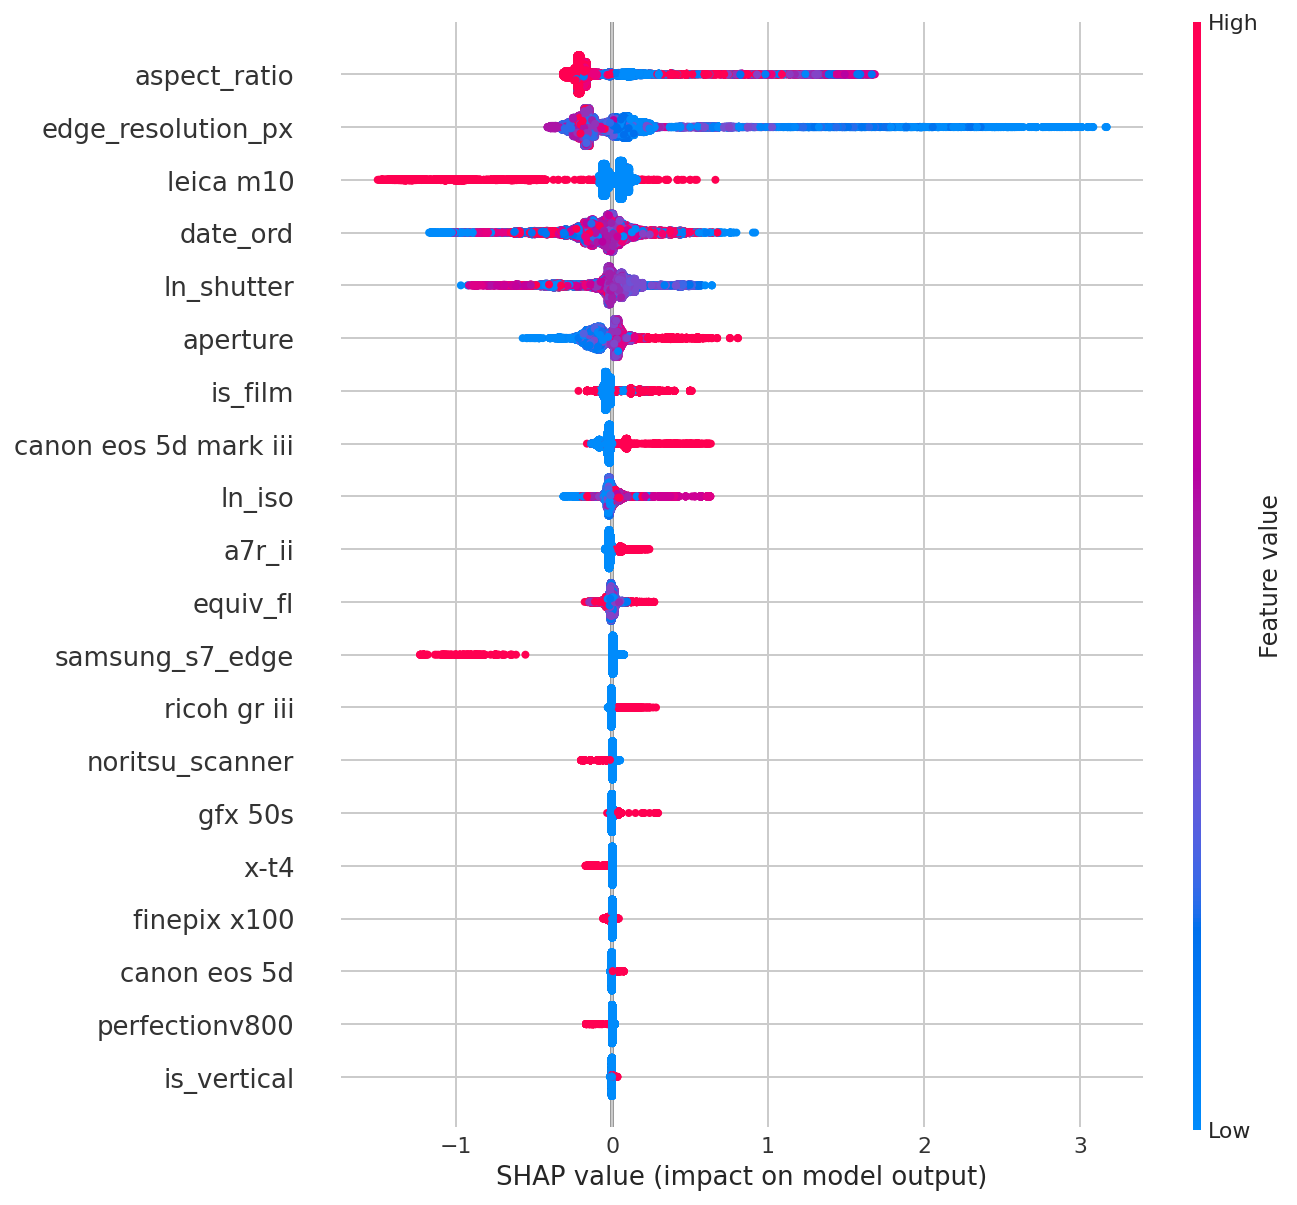

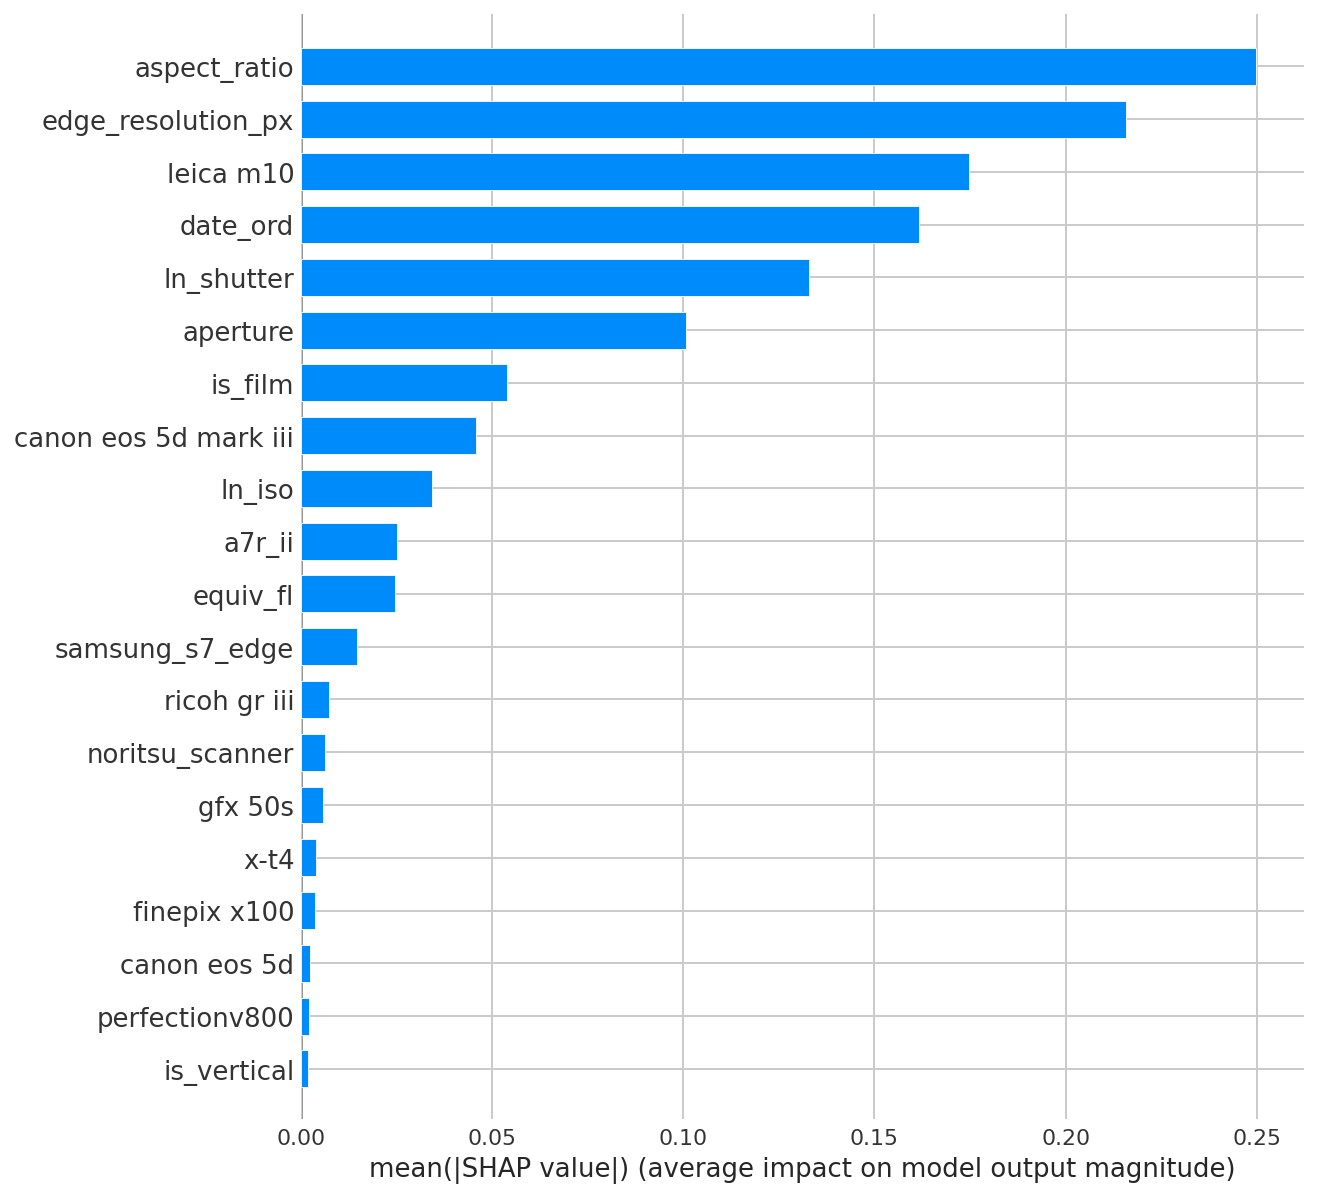




 * * Fit regularized linear model on timeseries CV: * *
AUCs by TS slice:  [0.499, 0.711, 0.573, 0.63, 0.575, 0.67, 0.694, 0.711, 0.564, 0.619]  avg:  0.6245999999999999


 * Fit XGB on timeseries CV: * *
XGB AUCs by TS slice:  [0.645, 0.716, 0.588, 0.612, 0.713, 0.644, 0.624, 0.818, 0.648, 0.593]  avg:  0.6600999999999999


In [113]:
# Try using flagged rather than rated 1+, since my flags are more stable over time
# (I think I used to rate photos less often)

OUTCOME = 'flag'

# -1 is "rejected"; consider it to be unflagged
ratings_md.loc[ratings_md.flag == -1, 'flag'] = 0

fit_basic_lr(
    RAW_X_COLS,
    OHE_X_COLS,
    OUTCOME,
)

#### Takeaways from frequentist LR on full metadata dataset __TODO__

Both outcomes generate pitful (but highly significant) R2.  


better results with:

- lower resolution (but the high resolution cameras score higher - GFX, a7r II - is this a scanning artifact?)
- some cameras (gfx, a7r II; again, above confound)
- more recent (time to pat myself on the back, back but it's a small effect)
- film (better, kinda)
- very small or non-signif effects of: focal length, iso, is-vertical, shutter speed

No effect of:
- focal length
- some cameras

__had some issues w/ solvers not converging.__ already normalized features (often req'd for good convergence.) L1 reg helps.

right now, don't trust camera-OHE effects

### Use this larger dataset (from metadata) to build expanded causal DAG

Needless to say, we will not capture all causal inputs. Thereforce this DAG is incomplete and imperfect!

We'll use our less sparse outcome - photo is flagged (`flag`)

#### Start w/ similar causal model to above before expanding

In [37]:
# Causal inference & DoWhy boilerplate
import category_encoders as ce
from graphviz import Source
import graphviz
from dowhy import CausalModel
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
import statsmodels.api as sm


# only log really bad events, otherwise dowhy gets really verbose
import logging
logger = logging.getLogger("dowhy").setLevel(logging.WARNING)
# also ignore that DoWhy feeds 1-column df for y instead of 1d array (series)
from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)



In [38]:
# DoWhy requires treatments to be encoded as ints, not str 
# (but multiclass treatments are fine for some methods, excl e.g. propensity scoring, stratfication)

ratings_md.camera = ratings_md.camera.str.replace(' ', '_')

CAMERAS_TO_ENC = [
    'canon_eos_5d_mark_iii',    
    'a7r_ii',                   
    'leica_m10',                
    'gfx_50s',                  
    'finepix_x100',             
    'canon_eos_5d',           
    'gfx_100',       
    'noritsu_scanner',
]
# exclude some less common models to simplify interpretation

ratings_md['top_camera'] = ratings_md.camera.copy()
ratings_md.loc[~(ratings_md.camera.isin(CAMERAS_TO_ENC)), 'top_camera'] = 'other'
fil_dslr_scan = (ratings_md.camera.isin(['a7r_ii', 'gfx_50s', 'gfx_100']) & (ratings_md.is_film == 1))
ratings_md.loc[fil_dslr_scan, 'top_camera'] = 'dslr_scan'

camera_encoder = ce.OrdinalEncoder()

# Obnoxiously, some EconML methods seem to require ordinal encoding for treatment be zero-indexed!
ratings_md['camera_discrete_enc'] = camera_encoder.fit_transform(ratings_md.top_camera) - 1  

ratings_md['top_camera'].value_counts(dropna=False)

treat_map = camera_encoder.mapping[0]['mapping'].to_dict()
treat_map
ratings_md['camera_discrete_enc'].value_counts(dropna=False)

canon_eos_5d_mark_iii    4920
a7r_ii                   3894
leica_m10                3376
dslr_scan                2317
finepix_x100             2280
gfx_50s                  2245
canon_eos_5d             2111
other                    1828
noritsu_scanner          1365
gfx_100                  1310
Name: top_camera, dtype: int64

{'canon_eos_5d': 1,
 'finepix_x100': 2,
 'canon_eos_5d_mark_iii': 3,
 'a7r_ii': 4,
 'other': 5,
 'leica_m10': 6,
 'dslr_scan': 7,
 'gfx_50s': 8,
 'noritsu_scanner': 9,
 'gfx_100': 10,
 nan: -2}

2    4920
3    3894
5    3376
6    2317
1    2280
7    2245
0    2111
4    1828
8    1365
9    1310
Name: camera_discrete_enc, dtype: int64

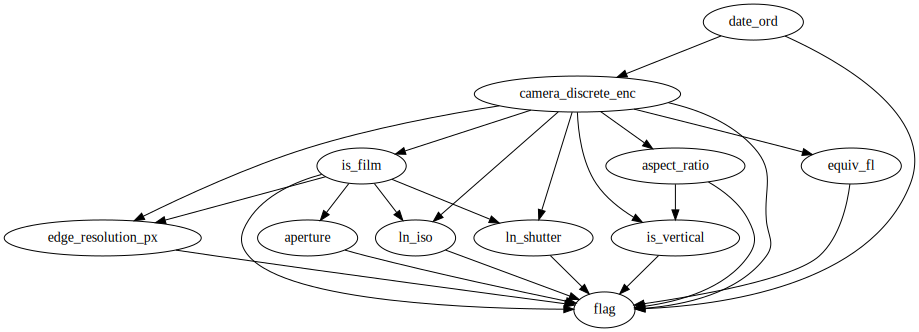

In [39]:
# Configure causal graph

GRAPH = (
"""digraph {
    camera_discrete_enc -> {
        equiv_fl, is_film, edge_resolution_px, aspect_ratio, is_vertical, flag, ln_iso, ln_shutter
    };
    equiv_fl -> flag;
    ln_iso -> flag;
    edge_resolution_px -> flag;
    date_ord -> camera_discrete_enc;
    date_ord -> flag;
    aspect_ratio -> flag;
    aspect_ratio -> is_vertical;
    is_film -> {
        flag; ln_shutter, aperture, ln_iso, edge_resolution_px
    };
    is_vertical -> flag;
    ln_shutter -> flag;
    aperture -> flag;
}"""
).replace('\n',''),  # PyDot accepts with newlines but DoWhy sees as invalid - need to remove.

pydot_src = graphviz.Source(GRAPH)

from IPython.display import Image, display

pydot_src

In [40]:
# constants & prep data

REFUTATION_STRATS = [
    ["random_common_cause", {'effect_strength_on_treatment': 0.1}],
    #["add_unobserved_common_cause", {'effect_strength_on_treatment': 0.1, 'effect_strength_on_outcome': 0.01}],
    #["placebo_treatment_refuter", {}],  # has been slooow
    #["data_subset_refuter", {}],        # same
]
OUTCOME = 'flag'

TREATMENT = 'camera_discrete_enc'

LIN_REG_PARAMS = {
    'num_null_simulations':50,
    'num_simulations':50,
    'num_quantiles_to_discretize_cont_cols':32,
    'fit_method': "statsmodels",
    'need_conditional_estimates': False,
}

LR_PARAMS = {
    'num_null_simulations':50,
    'num_simulations':50,
    'num_quantiles_to_discretize_cont_cols':32,
    'fit_method': "statsmodels",
    'glm_family': sm.families.Binomial(),  # logistic regression
    'need_conditional_estimates': False,
}

BASIC_XGB_REG = XGBRegressor(
    objective='reg:squarederror',
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    subsample=.9,
    colsample_bytree=.8,
    reg_alpha=.25,
    tree_method= 'hist',  # fast with less overfit
    grow_policy= 'depthwise',  # less overfit w/ hist vs. lossguide
    n_jobs=4,
)

BASIC_XGB_BINARY = XGBClassifier(
    objective="binary:logistic",
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    subsample=.9,
    colsample_bytree=.8,
    reg_alpha=.25,
    tree_method= 'hist',  # fast with less overfit
    grow_policy= 'depthwise',  # less overfit w/ hist vs. lossguide
    n_jobs=4,
)

BASIC_XGB_MULTICLASS = XGBClassifier(
    objective="multi:softmax",
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    subsample=.9,
    colsample_bytree=.8,
    reg_alpha=.25,
    tree_method= 'hist',  # fast with less overfit
    grow_policy= 'depthwise',  # less overfit w/ hist vs. lossguide
    n_jobs=4,
)

ECONML_FOREST_DML_PARAMS = {
    "init_params": {
        "model_y": BASIC_XGB_BINARY, 
        "model_t": BASIC_XGB_MULTICLASS,#BASIC_XGB_BINARY
    },  # outcome is binary, treatment is multiclass
    "fit_params": {"inference": "auto"},
}

ECONML_CATE_DML_PARAMS = {
    "init_params":{
        "model_y": BASIC_XGB_BINARY, 
        "model_t": BASIC_XGB_MULTICLASS,
        "model_final":LassoCV(),
        "featurizer":PolynomialFeatures(degree=1, include_bias=True),
    },
    "fit_params":{}
}

# Need to specify params for nuisance models in EconML
# The LinearDRLearner also requires two auxiliary models to model the relationships 
# $T\sim (W, X)$ (model_propensity) and $Y \sim (W, X)$(model_regression). 
# These can be generic, flexible classification and regression models, respectively.
# See: https://github.com/microsoft/EconML/blob/master/notebooks/CustomerScenarios/Case%20Study%20-%20Multi-investment%20Attribution%20at%20A%20Software%20Company%20-%20EconML%20%2B%20DoWhy.ipynb
ECONML_DR_PARAMS = {
    "init_params":{
        'model_regression': BASIC_XGB_REG, #'auto',
        'model_propensity': BASIC_XGB_MULTICLASS, #'auto',
        'categories': 'auto',
        'random_state': 123,
    },
    "fit_params":{},
    'need_conditional_estimates': False,
}


# btw, there's a handy dandy flowchart of EconML methods here:
# https://econml.azurewebsites.net/spec/flowchart.html
#
# and an experimental comparison with examples of necessary kwargs here:
# https://github.com/microsoft/dowhy/blob/master/docs/source/example_notebooks/dowhy_ranking_methods.ipynb

CAUSAL_METHODS = [
    ('backdoor.linear_regression', {'need_conditional_estimates': False}),  # basic linear regression, in some sense less likely to screw up than IPS, which can have outlier/variance issues
    ('backdoor.generalized_linear_model', LR_PARAMS),  # GLM, for logistic reg
    # below 2 only work for binary outcome, we have multiway 
    #'backdoor.propensity_score_weighting',  # control for selection bias with basic inverse propensity score
    #'backdoor.propensity_score_stratification'  # similar to IPS but with reduced variance issues
    ('backdoor.econml.dml.LinearDML', ECONML_FOREST_DML_PARAMS),  # linear-based double ML (for selection & main effect)
    #('backdoor.econml.dml.ForestDML', ECONML_FOREST_DML_PARAMS),  # forest-based double ML (for selection & main effect)
    #('backdoor.econml.dml.DMLCateEstimator', ECONML_CATE_DML_PARAMS),  # TODO EXPLAIN
    ('backdoor.econml.drlearner.LinearDRLearner', ECONML_DR_PARAMS), # linear doubly-robust
    #('backdoor.econml.drlearner.ForestDRLearner', ECONML_DR_PARAMS), # honest-tree-based doubly-robust  
]

ALL_CONFOUNDS = [
    'equiv_fl', 'is_film', 'edge_resolution_px', 'is_vertical', 'aspect_ratio', 'date_ord', 'ln_iso',
]

# This matrix style specification only necessary if you have "factorial" type design where 
# e.g. you can be affected by treatment 1 and 2 but not 3, 1 and 3 but not 2, etc.
# CONDITIONS = [
#     [(1,0,0,0),(0,1,1,1)],
#     [(0,1,0,0),(1,0,1,1)],
#     [(0,0,1,0),(1,1,0,1)],
#     [(0,0,0,1),(1,1,1,0)],
# ]

ratings_md_ = ratings_md.copy()
# Confirm treatment is never null.
ratings_md_ = ratings_md_.loc[ratings_md_[TREATMENT].notna()]
ratings_md_ = ratings_md_.fillna(ratings_md_.mean())

# Make sure we're just using desired cols (not necessary but makes input data more readable)
all_cols_desired = [OUTCOME, TREATMENT] + ALL_CONFOUNDS
ratings_md_ = ratings_md_[all_cols_desired]

# normalize features / confounds (not necessary unless using linear models, but we are)
ratings_md_[ALL_CONFOUNDS] = (
   (ratings_md_[ALL_CONFOUNDS] - ratings_md_[ALL_CONFOUNDS].mean()) / ratings_md_[ALL_CONFOUNDS].std()
)

ratings_md_.sample(10,random_state=42)

flag  camera_discrete_enc   equiv_fl  is_film  edge_resolution_px  is_vertical  aspect_ratio     date_ord    ln_iso
4371      0                    2  59.935041    False         4703.020306        False      1.500000   990.019861  5.298317
1840      0                    0  85.000000    False         3566.457065        False      1.500000   610.095984  4.605170
11545     0                    3  40.000000    False         6494.413599        False      1.499246  2257.446979  8.764053
27094     0                    4  52.500000    False         5094.938665         True      0.666667  3747.079225  5.768321
11775     0                    3  28.000000    False         6494.413599        False      1.499246  2307.164294  4.605170
11313     0                    4  59.935041     True         6801.588197        False      1.273979  2332.244691  5.538176
10035     1                    2  35.000000    False         4703.020306         True      0.666667  2138.387558  7.377759
9707      0                    2  35.000000    False         4703.020306        False      1.500000  2061.027743  5.298317
7301      0                    1  34.500000    False         3494.599262        False      1.505618  1399.027766  5.298317
26036     0                    5  59.935041    False         4879.383568        False      1.500000  3727.301887  6.214608

In [ ]:
# Do inference: does camera affect a photo's "goodness" (likelihood of being flagged as good)

# I. 
model = CausalModel(
    data = ratings_md_,
    treatment=TREATMENT,
    outcome=OUTCOME,
    # use a graph, rather than basic common causes (cause both selection & outcome directly)
    graph=GRAPH,
)

# II. Identify causal effect and return target estimands
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)  # observational data

n_conditions = ratings_md_[TREATMENT].nunique()

for causal_method, causal_method_params in CAUSAL_METHODS:
    print('')
    print('')
    print("* * Causal inference method = ", causal_method)
    print('')
    
    for condition, cond_no in treat_map.items():  # seems we have to test each condition separately?
        # Again, hack since EconML expects 0-indexed treatment idxs and CE outputs 1-idxed, have to manually -1.
        cond_no = cond_no - 1 
        if condition is np.nan:
            break
        # III. Estimate the target estimand using a statistical method.
        print('')
        print(condition, ' condition #:', cond_no)
        estimate = model.estimate_effect(
            identified_estimand,
            method_name=causal_method,
            #test_significance=True,
            #confidence_intervals=True,
            method_params=causal_method_params,
            treatment_value=cond_no,
        )
        print(estimate)

        # IV. Refute the obtained estimate using multiple robustness checks.
        for refuter, args in REFUTATION_STRATS:
            refute_results = model.refute_estimate(
                identified_estimand, 
                estimate,                
                method_name=refuter,
                treatment_value=cond_no,
                #num_simulations=100,
                random_seed=1234,
                silent=True,
                **args,
            )
            print(refute_results)

method:

- linear and GLM->logistic produce near identical results, despite linear being mis-specified



#### Try finding causal effect of is_film

not sure how well-specified this is. that is, is_film is driven by camera, which I'm controlling for?  
so do I need to remove the camera variable?  

In [116]:
TREATMENT_2 = 'is_film'

REFUTATION_STRATS = [
    ["random_common_cause", {'effect_strength_on_treatment': 0.1}],
    ["add_unobserved_common_cause", {'effect_strength_on_treatment': 0.1, 'effect_strength_on_outcome': 0.01}],
    ["placebo_treatment_refuter", {}],  # has been slooow
    ["data_subset_refuter", {}],        # same
]

# binary treatment so replace model_t
ECONML_FOREST_DML_PARAMS = {
    "init_params": {
        "model_y": BASIC_XGB_BINARY, 
        "model_t": BASIC_XGB_BINARY,#BASIC_XGB_BINARY
    },  # outcome is binary, treatment is multiclass
    "fit_params": {"inference": "auto"},
}
# same
ECONML_DR_PARAMS = {
    "init_params":{
        'model_regression': BASIC_XGB_REG, #'auto',
        'model_propensity': BASIC_XGB_BINARY, #'auto',
        'categories': 'auto',
        'random_state': 123,
    },
    "fit_params":{},
    'need_conditional_estimates': False,
}
ECONML_CATE_DML_PARAMS = {
    "init_params":{
        "model_y": BASIC_XGB_BINARY, 
        "model_t": BASIC_XGB_BINARY,
        "model_final":LassoCV(),
        "featurizer":PolynomialFeatures(degree=1, include_bias=True),
    },
    "fit_params":{}
}

CAUSAL_METHODS_2 = [
    ('backdoor.linear_regression', {'need_conditional_estimates': False}),  # basic linear regression, in some sense less likely to screw up than IPS, which can have outlier/variance issues
    ('backdoor.generalized_linear_model', LR_PARAMS),  # GLM, for logistic reg
    # below 2 only work for binary outcome, we have multiway 
    ('backdoor.propensity_score_weighting', {'need_conditional_estimates': False}),  # control for selection bias with basic inverse propensity score
    ('backdoor.propensity_score_stratification', {'need_conditional_estimates': False}),  # similar to IPS but with reduced variance issues
    ('backdoor.propensity_score_matching', {'need_conditional_estimates': False}),  # explanation
    ('backdoor.econml.dml.LinearDML', ECONML_FOREST_DML_PARAMS),  # linear-based double ML (for selection & main effect)
    #('backdoor.econml.dml.ForestDML', ECONML_FOREST_DML_PARAMS),  # forest-based double ML (for selection & main effect)
    #('backdoor.econml.dml.DMLCateEstimator', ECONML_CATE_DML_PARAMS),  # TODO EXPLAIN
    #('backdoor.econml.drlearner.LinearDRLearner', ECONML_DR_PARAMS), # linear doubly-robust
    ('backdoor.econml.drlearner.ForestDRLearner', ECONML_DR_PARAMS), # honest-tree-based doubly-robust  
]

# normalize features / confounds (not necessary unless using linear models)
ALL_CONFOUNDS = [
    'equiv_fl',
    'edge_resolution_px',
    'is_vertical',
    'aspect_ratio',
    'date_ord',
    'ln_iso',
]
ratings_md_[ALL_CONFOUNDS] = (
   (ratings_md_[ALL_CONFOUNDS] - ratings_md_[ALL_CONFOUNDS].mean()) / ratings_md_[ALL_CONFOUNDS].std()
)

ratings_md_.head()

# Do inference

# I.
model = CausalModel(
    data = ratings_md_,
    treatment=TREATMENT_2,
    outcome=OUTCOME,
    # use a graph, rather than basic common causes (cause both selection & outcome directly)
    graph=GRAPH.replace('\n',''),  # pydot accepts with newlines but DoWhy sees as invalid - need to remove.
)

# II. Identify causal effect and return target estimands
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)  # observational data

n_conditions = ratings_md_[TREATMENT_2].nunique()

print('Investigate causal effect of IS_FILM treatment')

for causal_method, causal_method_params in CAUSAL_METHODS_2:
    print('')
    print('')
    print("* * Causal inference method = ", causal_method)
    print('')

    # III. Estimate the target estimand using a statistical method.
    print('')
    estimate = model.estimate_effect(
        identified_estimand,
        method_name=causal_method,
        #test_significance=True,
        #confidence_intervals=True,
        method_params=causal_method_params,
        treatment_value=1,
    )
    #print(causal_method)
    print(estimate)

    # IV. Refute the obtained estimate using multiple robustness checks.
    # EXCL FOR RIGHT NOW FOR VERBOSITY
    for refuter, args in REFUTATION_STRATS:
        refute_results = model.refute_estimate(
            identified_estimand, 
            estimate,                
            method_name=refuter,
            treatment_value=cond_no,
            #num_simulations=100,
            random_seed=1234,
            silent=True,
            **args,
        )
        print(refute_results)

flag  camera_discrete_enc  equiv_fl  is_film  edge_resolution_px  is_vertical  aspect_ratio  date_ord    ln_iso    ps  ips_weight  \
963     0                    0  0.704603    False           -1.151068    -0.523579      0.529563 -1.928095 -0.017344  0.05    0.000041   
964     0                    0  0.704603    False           -1.151068    -0.523579      0.529563 -1.925986 -0.017344  0.05    0.000041   
965     1                    0  0.704603    False           -1.425086    -0.523579      0.529563 -1.925895 -0.968141  0.05    0.000041   
966     0                    0  0.704603    False           -1.151068    -0.523579      0.529563 -1.925895 -0.968141  0.05    0.000041   
967     0                    0  0.704603    False           -1.151068     1.909858     -1.784306 -1.925894 -0.968141  0.05    0.000041   

     tips_weight  cips_weight  ips_normalized_weight  tips_normalized_weight  cips_normalized_weight  ips_stabilized_weight  \
963     0.000014     0.000046               0.000041                0.000013                0.000046               0.000035   
964     0.000014     0.000046               0.000041                0.000013                0.000046               0.000035   
965     0.000014     0.000046               0.000041                0.000013                0.000046               0.000035   
966     0.000014     0.000046               0.000041                0.000013                0.000046               0.000035   
967     0.000014     0.000046               0.000041                0.000013                0.000046               0.000035   

     tips_stabilized_weight  cips_stabilized_weight  d_y  dbar_y  propensity_score  strata  dbar  
963                0.000012                0.000039    0       0          0.025578     9.0     1  
964                0.000012                0.000039    0       0          0.025523     9.0     1  
965                0.000012                0.000039    0       1          0.025520     9.0     1  
966                0.000012                0.000039    0       0          0.025520     9.0     1  
967                0.000012                0.000039    0       0          0.015334     2.0     1

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


Investigate causal effect of IS_FILM treatment


* * Causal inference method =  backdoor.linear_regression


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: flag~is_film+aspect_ratio+date_ord+camera_discrete_enc+equiv_fl+is_vertical+is_film*equiv_fl+is_film*is_vertical+is_film*aspect_ratio
Target units: ate

## Estimate
Mean value: 0.1431155774043262

Refute: Add a Random Common Cause
Estimated effect:0.1431155774043262
New effect:0.14311408625811753

Refute: Add an Unobserved Common Cause
Estimated effect:0.1431155774043262
New effect:0.06654149916359842

Refute: Use a Placebo Treatment
Estimated effect:0.1431155774043262
New effect:0.0004480437496296544
p value:0.45

Refute: Use a subset of data
Estimated effect:0.1431155774043262
New effect:0.143253855575893
p value:0.45



* * Causal inference method =  backdoor.generalized_linear_model


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Re

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

#### Extend: Linear Doubly Robust Regression

Theoretically, doubly robust regression will allow us to mis specify either the selection bias or main regression model. but it's complicated.
see this paper for a thorough and not unconfusing explanation (lol): https://arxiv.org/pdf/0804.2958.pdf

#### Extend: Use Doubly Robust ML with Honest Trees

Honest trees allow us to generate asymptotically normal confidence intervals (no bootstrap, meaning faster and more reliable) 